# Homework 3
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right?

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [1]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.3.0+cu100
# CUDA enabled: True

Version 1.3.1+cu100
CUDA enabled: True


In [2]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
'My Drive'


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to navigate to the BASE_PATH directory and upload the homework2.tar file inside the BASE_PATH, then extract it.



In [0]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/homework3/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

DATA_PATH = BASE_PATH

In [0]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util
import math

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [0]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    #@Helly: Inspired by https://stackoverflow.com/questions/3739909/how-to-strip-all-whitespace-from-string
    # Converts to uppercase, does not account for case
    # - removed case conversion
    data = ' '.join(data.split())
    
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.

    # @Helly: Currently just allocates indices in order
    i = 0
    for char in data:
        if char not in voc2ind.keys():
          voc2ind[char] = i
          i = i + 1

    tokens = []
    for word in data.split():
      token = []
      for char in word:
        token.append(voc2ind[char])
      token.append(voc2ind[' '])
      tokens.append(token)


    ind2voc = {val: key for key, val in voc2ind.items()}

    split_index = math.floor(len(tokens) * 0.8)

    train_text = tokens[:split_index] # TODO Fill this in
    test_text = tokens[split_index:] # TODO Fill this in

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

# Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is 2 and the sequence length is 4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [0]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)


        # TODO: Any preprocessing on the data to get it to the right shape

        
        data = [x for token in dataset['tokens'] for x in token]

        datalength = len(data)
        self.chunk_len = datalength // batch_size

        # print("batch/seq len =", batch_size, sequence_length)
        # print(datalength, self.chunk_len)

        # print("Original Data Length: ", datalength)

        # data = data[:datalength - (datalength % self.sequence_length) + 1]
        data = data[:self.chunk_len*batch_size]
        data = torch.LongTensor(data)

        # print("Stripped Data Length:", len(data))

        self.chunks = torch.split(data, self.chunk_len)
        # self.sequences = torch.split(data[:len(data) - 1], self.sequence_length)
        # self.labels = torch.split(data[1:], self.sequence_length)


    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
         return math.ceil(self.chunk_len / self.sequence_length) * self.batch_size
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.

        # data = None
        # return data[:-1], data[1:]
        chunk = self.chunks[idx % self.batch_size]
        start_idx = (idx // self.batch_size) * self.sequence_length
        end_idx = start_idx + self.sequence_length
        if end_idx >= self.chunk_len:
          end_idx = self.chunk_len - 1

        return chunk[start_idx:end_idx], chunk[start_idx+1:end_idx+1]

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [0]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.

        #@Helly: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
        output = self.encoder(x)
        output, hidden_state = self.gru(output, hidden_state)
        output = self.decoder(output)

        return output, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [0]:
TEMPERATURE = 0.5
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab, device):
    outputs = []
    for ii in range(sequence_length):
        next_char = torch.argmax(output)
        outputs.append(next_char)
        curr_input = torch.LongTensor([outputs[-1]]).to(device)
        output, hidden = model.inference(curr_input, hidden)
    return outputs

# helper function that gets a random word from a given distribution
def get_val_from_dist(dist):
    draw = torch.distributions.multinomial.Multinomial(1, dist).sample()
    ret_val = torch.argmax(draw)
    return ret_val
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab, device):
    outputs = []
    outputs.append(get_val_from_dist(output))
    for ii in range(sequence_length):
        next_char = get_val_from_dist(output)
        outputs.append(next_char)
        curr_input = torch.LongTensor([outputs[-1]]).to(device)
        output, hidden = model.inference(curr_input, hidden, TEMPERATURE)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab, device):
    outputs = []
    beams = [([], output, hidden, 0)]

    for ii in range(sequence_length):
      candidates = []
      for beam in beams:
        curr_sequence, curr_output, curr_hidden, curr_score = beam

        for y in range(beam_width):
          next_char = get_val_from_dist(curr_output)
          next_sequence = curr_sequence + [next_char.item()]
          curr_input = torch.LongTensor([next_char.item()]).to(device)
          next_output, next_hidden = model.inference(curr_input, curr_hidden, TEMPERATURE)

          candidate = (next_sequence, next_output, next_hidden, curr_score + math.log(curr_output[0][next_char]))
          candidates.append(candidate)

      sorted_candidates = sorted(candidates, key=lambda x: x[3], reverse = True)
      beams = sorted_candidates[:beam_width]
    return beams[0][0]


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab, device)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab, device)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, BEAM_WIDTH, model, output, hidden, vocab, device)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [0]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            # if batch_idx % 10 == 0:
                # print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    # test_loader.dataset.vocab.array_to_words(data[0]),
                    # test_loader.dataset.vocab.array_to_words(label[0]),
                    # test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    perplexity = math.exp(test_loss)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy, perplexity

Using device cuda
num workers: 2




  0%|          | 0/390 [00:00<?, ?it/s]


Test set: Average loss: 17.0256, Accuracy: 12199/1254400 (1%)





  0%|          | 1/390 [00:00<00:47,  8.19it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 16.901409




  1%|          | 4/390 [00:00<00:37, 10.18it/s]

  2%|▏         | 7/390 [00:00<00:31, 12.30it/s]

  3%|▎         | 10/390 [00:00<00:26, 14.28it/s]

  3%|▎         | 13/390 [00:00<00:23, 16.21it/s]

Train Epoch: 0 [1280/49920 (3%)]	Loss: 6.324707




  4%|▍         | 16/390 [00:00<00:20, 17.95it/s]

  5%|▍         | 19/390 [00:00<00:19, 19.19it/s]

  6%|▌         | 22/390 [00:01<00:18, 19.65it/s]

  6%|▋         | 25/390 [00:01<00:17, 20.68it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 3.856546




  7%|▋         | 28/390 [00:01<00:16, 21.59it/s]

  8%|▊         | 31/390 [00:01<00:16, 22.19it/s]

  9%|▊         | 34/390 [00:01<00:15, 22.51it/s]

Train Epoch: 0 [3840/49920 (8%)]	Loss: 2.794702




  9%|▉         | 37/390 [00:01<00:15, 22.92it/s]

 10%|█         | 40/390 [00:01<00:15, 23.27it/s]

 11%|█         | 43/390 [00:01<00:14, 23.43it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 2.426361




 12%|█▏        | 46/390 [00:02<00:14, 23.04it/s]

 13%|█▎        | 49/390 [00:02<00:14, 23.32it/s]

 13%|█▎        | 52/390 [00:02<00:14, 23.02it/s]

 14%|█▍        | 55/390 [00:02<00:14, 23.27it/s]

Train Epoch: 0 [6400/49920 (13%)]	Loss: 2.130860




 15%|█▍        | 58/390 [00:02<00:14, 23.28it/s]

 16%|█▌        | 61/390 [00:02<00:14, 23.23it/s]

 16%|█▋        | 64/390 [00:02<00:14, 23.29it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 2.427317




 17%|█▋        | 67/390 [00:02<00:13, 23.59it/s]

 18%|█▊        | 70/390 [00:03<00:13, 23.23it/s]

 19%|█▊        | 73/390 [00:03<00:13, 23.21it/s]

Train Epoch: 0 [8960/49920 (18%)]	Loss: 2.268405




 19%|█▉        | 76/390 [00:03<00:13, 23.10it/s]

 20%|██        | 79/390 [00:03<00:13, 22.95it/s]

 21%|██        | 82/390 [00:03<00:13, 22.74it/s]

 22%|██▏       | 85/390 [00:03<00:13, 22.96it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 2.319036




 23%|██▎       | 88/390 [00:03<00:13, 22.88it/s]

 23%|██▎       | 91/390 [00:04<00:13, 22.87it/s]

 24%|██▍       | 94/390 [00:04<00:12, 22.83it/s]

Train Epoch: 0 [11520/49920 (23%)]	Loss: 2.155214




 25%|██▍       | 97/390 [00:04<00:12, 22.93it/s]

 26%|██▌       | 100/390 [00:04<00:12, 22.88it/s]

 26%|██▋       | 103/390 [00:04<00:12, 22.81it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 2.017834




 27%|██▋       | 106/390 [00:04<00:12, 22.89it/s]

 28%|██▊       | 109/390 [00:04<00:12, 22.86it/s]

 29%|██▊       | 112/390 [00:04<00:11, 23.17it/s]

 29%|██▉       | 115/390 [00:05<00:11, 23.26it/s]

Train Epoch: 0 [14080/49920 (28%)]	Loss: 2.038083




 30%|███       | 118/390 [00:05<00:11, 23.26it/s]

 31%|███       | 121/390 [00:05<00:11, 23.22it/s]

 32%|███▏      | 124/390 [00:05<00:11, 22.90it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 2.020647




 33%|███▎      | 127/390 [00:05<00:11, 23.18it/s]

 33%|███▎      | 130/390 [00:05<00:11, 22.76it/s]

 34%|███▍      | 133/390 [00:05<00:11, 23.11it/s]

Train Epoch: 0 [16640/49920 (33%)]	Loss: 2.044239




 35%|███▍      | 136/390 [00:05<00:11, 23.09it/s]

 36%|███▌      | 139/390 [00:06<00:10, 23.03it/s]

 36%|███▋      | 142/390 [00:06<00:10, 23.11it/s]

 37%|███▋      | 145/390 [00:06<00:10, 22.83it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 2.049317




 38%|███▊      | 148/390 [00:06<00:10, 23.09it/s]

 39%|███▊      | 151/390 [00:06<00:10, 22.82it/s]

 39%|███▉      | 154/390 [00:06<00:10, 22.70it/s]

Train Epoch: 0 [19200/49920 (38%)]	Loss: 2.101503




 40%|████      | 157/390 [00:06<00:10, 22.76it/s]

 41%|████      | 160/390 [00:07<00:10, 22.77it/s]

 42%|████▏     | 163/390 [00:07<00:09, 22.72it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 1.967740




 43%|████▎     | 166/390 [00:07<00:09, 23.16it/s]

 43%|████▎     | 169/390 [00:07<00:09, 23.03it/s]

 44%|████▍     | 172/390 [00:07<00:09, 23.01it/s]

 45%|████▍     | 175/390 [00:07<00:09, 23.17it/s]

Train Epoch: 0 [21760/49920 (44%)]	Loss: 1.975719




 46%|████▌     | 178/390 [00:07<00:09, 22.96it/s]

 46%|████▋     | 181/390 [00:07<00:09, 23.14it/s]

 47%|████▋     | 184/390 [00:08<00:09, 22.84it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 1.862448




 48%|████▊     | 187/390 [00:08<00:08, 23.13it/s]

 49%|████▊     | 190/390 [00:08<00:08, 22.88it/s]

 49%|████▉     | 193/390 [00:08<00:08, 23.03it/s]

Train Epoch: 0 [24320/49920 (49%)]	Loss: 1.851925




 50%|█████     | 196/390 [00:08<00:08, 22.53it/s]

 51%|█████     | 199/390 [00:08<00:08, 22.47it/s]

 52%|█████▏    | 202/390 [00:08<00:08, 22.51it/s]

 53%|█████▎    | 205/390 [00:08<00:08, 22.38it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 1.822230




 53%|█████▎    | 208/390 [00:09<00:08, 22.61it/s]

 54%|█████▍    | 211/390 [00:09<00:07, 22.57it/s]

 55%|█████▍    | 214/390 [00:09<00:07, 22.74it/s]

Train Epoch: 0 [26880/49920 (54%)]	Loss: 1.834109




 56%|█████▌    | 217/390 [00:09<00:07, 22.55it/s]

 56%|█████▋    | 220/390 [00:09<00:07, 22.40it/s]

 57%|█████▋    | 223/390 [00:09<00:07, 22.53it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 1.797576




 58%|█████▊    | 226/390 [00:09<00:07, 22.34it/s]

 59%|█████▊    | 229/390 [00:10<00:07, 22.46it/s]

 59%|█████▉    | 232/390 [00:10<00:07, 22.46it/s]

 60%|██████    | 235/390 [00:10<00:06, 22.59it/s]

Train Epoch: 0 [29440/49920 (59%)]	Loss: 1.804612




 61%|██████    | 238/390 [00:10<00:06, 22.53it/s]

 62%|██████▏   | 241/390 [00:10<00:06, 22.71it/s]

 63%|██████▎   | 244/390 [00:10<00:06, 22.63it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 1.816341




 63%|██████▎   | 247/390 [00:10<00:06, 22.56it/s]

 64%|██████▍   | 250/390 [00:10<00:06, 22.75it/s]

 65%|██████▍   | 253/390 [00:11<00:06, 22.46it/s]

Train Epoch: 0 [32000/49920 (64%)]	Loss: 1.821593




 66%|██████▌   | 256/390 [00:11<00:05, 22.70it/s]

 66%|██████▋   | 259/390 [00:11<00:05, 22.58it/s]

 67%|██████▋   | 262/390 [00:11<00:05, 22.49it/s]

 68%|██████▊   | 265/390 [00:11<00:05, 22.53it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 1.923380




 69%|██████▊   | 268/390 [00:11<00:05, 22.45it/s]

 69%|██████▉   | 271/390 [00:11<00:05, 22.64it/s]

 70%|███████   | 274/390 [00:12<00:05, 22.42it/s]

Train Epoch: 0 [34560/49920 (69%)]	Loss: 1.842761




 71%|███████   | 277/390 [00:12<00:05, 22.27it/s]

 72%|███████▏  | 280/390 [00:12<00:04, 22.42it/s]

 73%|███████▎  | 283/390 [00:12<00:04, 22.35it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 1.729445




 73%|███████▎  | 286/390 [00:12<00:04, 22.46it/s]

 74%|███████▍  | 289/390 [00:12<00:04, 22.43it/s]

 75%|███████▍  | 292/390 [00:12<00:04, 22.20it/s]

 76%|███████▌  | 295/390 [00:12<00:04, 22.35it/s]

Train Epoch: 0 [37120/49920 (74%)]	Loss: 1.788689




 76%|███████▋  | 298/390 [00:13<00:04, 22.20it/s]

 77%|███████▋  | 301/390 [00:13<00:04, 22.12it/s]

 78%|███████▊  | 304/390 [00:13<00:03, 22.35it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 1.760781




 79%|███████▊  | 307/390 [00:13<00:03, 22.37it/s]

 79%|███████▉  | 310/390 [00:13<00:03, 22.68it/s]

 80%|████████  | 313/390 [00:13<00:03, 22.76it/s]

Train Epoch: 0 [39680/49920 (79%)]	Loss: 1.681074




 81%|████████  | 316/390 [00:13<00:03, 22.68it/s]

 82%|████████▏ | 319/390 [00:14<00:03, 22.42it/s]

 83%|████████▎ | 322/390 [00:14<00:03, 22.03it/s]

 83%|████████▎ | 325/390 [00:14<00:02, 22.29it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 1.819300




 84%|████████▍ | 328/390 [00:14<00:02, 22.37it/s]

 85%|████████▍ | 331/390 [00:14<00:02, 22.18it/s]

 86%|████████▌ | 334/390 [00:14<00:02, 22.38it/s]

Train Epoch: 0 [42240/49920 (85%)]	Loss: 1.818092




 86%|████████▋ | 337/390 [00:14<00:02, 22.34it/s]

 87%|████████▋ | 340/390 [00:14<00:02, 22.66it/s]

 88%|████████▊ | 343/390 [00:15<00:02, 22.33it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 1.760202




 89%|████████▊ | 346/390 [00:15<00:01, 22.25it/s]

 89%|████████▉ | 349/390 [00:15<00:01, 22.48it/s]

 90%|█████████ | 352/390 [00:15<00:01, 22.29it/s]

 91%|█████████ | 355/390 [00:15<00:01, 22.13it/s]

Train Epoch: 0 [44800/49920 (90%)]	Loss: 1.758263




 92%|█████████▏| 358/390 [00:15<00:01, 22.41it/s]

 93%|█████████▎| 361/390 [00:15<00:01, 22.37it/s]

 93%|█████████▎| 364/390 [00:16<00:01, 22.54it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 1.710864




 94%|█████████▍| 367/390 [00:16<00:01, 22.31it/s]

 95%|█████████▍| 370/390 [00:16<00:00, 22.65it/s]

 96%|█████████▌| 373/390 [00:16<00:00, 22.46it/s]

Train Epoch: 0 [47360/49920 (95%)]	Loss: 1.798672




 96%|█████████▋| 376/390 [00:16<00:00, 22.26it/s]

 97%|█████████▋| 379/390 [00:16<00:00, 22.45it/s]

 98%|█████████▊| 382/390 [00:16<00:00, 22.27it/s]

 99%|█████████▊| 385/390 [00:17<00:00, 22.30it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 1.687696




 99%|█████████▉| 388/390 [00:17<00:00, 22.52it/s]

100%|██████████| 390/390 [00:17<00:00, 22.62it/s]


Test set: Average loss: 1.7041, Accuracy: 630032/1254400 (50%)

Saved /gdrive/My Drive/colab_files/homework3/checkpoints/000.pt

train perplexity = 9.461219794525203
test perplexity = 5.496557274022481
generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What had a sure was staring and the conto the conto the conto the conto the conto the conto the conto the conto the conto the conto the conto the conto the conto the conto the conto the conto the con
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. HNothing for the scare was a said a strued to the contone of the Sirius was still chan a had been felloned out of the contanted to seconded. "What he cone, what have a voice, and Harry and the cont of 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. TAs the sure had a starin feeling as hell that was surried and the done everyone had have been a feeling and a have been a few in the had to the conting he had a spect of 



  0%|          | 0/390 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The had and the conto the conto the conto the conto the conto the conto the conto the conto the conto the conto the conto the conto the conto the conto the conto the conto the conto the conto the cont





  0%|          | 1/390 [00:00<01:01,  6.37it/s]

Train Epoch: 1 [0/49920 (0%)]	Loss: 1.699130




  1%|          | 3/390 [00:00<00:50,  7.73it/s]

  2%|▏         | 6/390 [00:00<00:39,  9.74it/s]

  2%|▏         | 9/390 [00:00<00:32, 11.78it/s]

  3%|▎         | 12/390 [00:00<00:27, 13.84it/s]

  4%|▍         | 15/390 [00:00<00:23, 15.91it/s]

Train Epoch: 1 [1280/49920 (3%)]	Loss: 1.695251




  5%|▍         | 18/390 [00:00<00:20, 17.78it/s]

  5%|▌         | 21/390 [00:01<00:19, 19.31it/s]

  6%|▌         | 24/390 [00:01<00:18, 20.18it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 1.675289




  7%|▋         | 27/390 [00:01<00:17, 21.05it/s]

  8%|▊         | 30/390 [00:01<00:16, 21.90it/s]

  8%|▊         | 33/390 [00:01<00:15, 22.60it/s]

Train Epoch: 1 [3840/49920 (8%)]	Loss: 1.704924




  9%|▉         | 36/390 [00:01<00:15, 22.69it/s]

 10%|█         | 39/390 [00:01<00:15, 23.04it/s]

 11%|█         | 42/390 [00:01<00:14, 23.31it/s]

 12%|█▏        | 45/390 [00:02<00:14, 23.44it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 1.700285




 12%|█▏        | 48/390 [00:02<00:14, 23.40it/s]

 13%|█▎        | 51/390 [00:02<00:14, 23.56it/s]

 14%|█▍        | 54/390 [00:02<00:14, 23.65it/s]

Train Epoch: 1 [6400/49920 (13%)]	Loss: 1.658110




 15%|█▍        | 57/390 [00:02<00:13, 23.98it/s]

 15%|█▌        | 60/390 [00:02<00:13, 24.11it/s]

 16%|█▌        | 63/390 [00:02<00:13, 23.76it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 1.644448




 17%|█▋        | 66/390 [00:02<00:13, 23.82it/s]

 18%|█▊        | 69/390 [00:03<00:13, 23.81it/s]

 18%|█▊        | 72/390 [00:03<00:13, 23.87it/s]

 19%|█▉        | 75/390 [00:03<00:13, 23.91it/s]

Train Epoch: 1 [8960/49920 (18%)]	Loss: 1.642567




 20%|██        | 78/390 [00:03<00:13, 23.88it/s]

 21%|██        | 81/390 [00:03<00:13, 23.74it/s]

 22%|██▏       | 84/390 [00:03<00:12, 23.92it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 1.615184




 22%|██▏       | 87/390 [00:03<00:12, 24.06it/s]

 23%|██▎       | 90/390 [00:03<00:12, 24.25it/s]

 24%|██▍       | 93/390 [00:04<00:12, 24.33it/s]

Train Epoch: 1 [11520/49920 (23%)]	Loss: 1.679592




 25%|██▍       | 96/390 [00:04<00:12, 24.24it/s]

 25%|██▌       | 99/390 [00:04<00:12, 23.91it/s]

 26%|██▌       | 102/390 [00:04<00:12, 23.75it/s]

 27%|██▋       | 105/390 [00:04<00:11, 23.79it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 1.765554




 28%|██▊       | 108/390 [00:04<00:11, 23.62it/s]

 28%|██▊       | 111/390 [00:04<00:11, 23.64it/s]

 29%|██▉       | 114/390 [00:04<00:11, 23.74it/s]

Train Epoch: 1 [14080/49920 (28%)]	Loss: 1.821707




 30%|███       | 117/390 [00:05<00:11, 23.74it/s]

 31%|███       | 120/390 [00:05<00:11, 23.70it/s]

 32%|███▏      | 123/390 [00:05<00:11, 23.42it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 1.690042




 32%|███▏      | 126/390 [00:05<00:11, 23.58it/s]

 33%|███▎      | 129/390 [00:05<00:11, 23.69it/s]

 34%|███▍      | 132/390 [00:05<00:11, 23.32it/s]

 35%|███▍      | 135/390 [00:05<00:10, 23.54it/s]

Train Epoch: 1 [16640/49920 (33%)]	Loss: 1.611731




 35%|███▌      | 138/390 [00:05<00:10, 23.50it/s]

 36%|███▌      | 141/390 [00:06<00:10, 23.32it/s]

 37%|███▋      | 144/390 [00:06<00:10, 23.51it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 1.644323




 38%|███▊      | 147/390 [00:06<00:10, 23.39it/s]

 38%|███▊      | 150/390 [00:06<00:10, 23.31it/s]

 39%|███▉      | 153/390 [00:06<00:10, 23.34it/s]

Train Epoch: 1 [19200/49920 (38%)]	Loss: 1.595677




 40%|████      | 156/390 [00:06<00:10, 23.10it/s]

 41%|████      | 159/390 [00:06<00:09, 23.28it/s]

 42%|████▏     | 162/390 [00:06<00:09, 23.67it/s]

 42%|████▏     | 165/390 [00:07<00:09, 23.51it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 1.630944




 43%|████▎     | 168/390 [00:07<00:09, 23.46it/s]

 44%|████▍     | 171/390 [00:07<00:09, 23.63it/s]

 45%|████▍     | 174/390 [00:07<00:09, 23.48it/s]

Train Epoch: 1 [21760/49920 (44%)]	Loss: 1.623125




 45%|████▌     | 177/390 [00:07<00:09, 23.53it/s]

 46%|████▌     | 180/390 [00:07<00:08, 23.49it/s]

 47%|████▋     | 183/390 [00:07<00:08, 23.31it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 1.595015




 48%|████▊     | 186/390 [00:08<00:08, 23.33it/s]

 48%|████▊     | 189/390 [00:08<00:08, 23.48it/s]

 49%|████▉     | 192/390 [00:08<00:08, 23.72it/s]

 50%|█████     | 195/390 [00:08<00:08, 23.55it/s]

Train Epoch: 1 [24320/49920 (49%)]	Loss: 1.618119




 51%|█████     | 198/390 [00:08<00:08, 23.42it/s]

 52%|█████▏    | 201/390 [00:08<00:07, 23.70it/s]

 52%|█████▏    | 204/390 [00:08<00:07, 23.31it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 1.701557




 53%|█████▎    | 207/390 [00:08<00:07, 23.48it/s]

 54%|█████▍    | 210/390 [00:09<00:07, 23.21it/s]

 55%|█████▍    | 213/390 [00:09<00:07, 23.10it/s]

Train Epoch: 1 [26880/49920 (54%)]	Loss: 1.630414




 55%|█████▌    | 216/390 [00:09<00:07, 23.08it/s]

 56%|█████▌    | 219/390 [00:09<00:07, 23.20it/s]

 57%|█████▋    | 222/390 [00:09<00:07, 23.12it/s]

 58%|█████▊    | 225/390 [00:09<00:07, 23.39it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 1.575454




 58%|█████▊    | 228/390 [00:09<00:06, 23.55it/s]

 59%|█████▉    | 231/390 [00:09<00:06, 23.27it/s]

 60%|██████    | 234/390 [00:10<00:06, 23.24it/s]

Train Epoch: 1 [29440/49920 (59%)]	Loss: 1.576801




 61%|██████    | 237/390 [00:10<00:06, 23.07it/s]

 62%|██████▏   | 240/390 [00:10<00:06, 23.26it/s]

 62%|██████▏   | 243/390 [00:10<00:06, 23.01it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 1.575353




 63%|██████▎   | 246/390 [00:10<00:06, 23.16it/s]

 64%|██████▍   | 249/390 [00:10<00:05, 23.55it/s]

 65%|██████▍   | 252/390 [00:10<00:05, 23.24it/s]

 65%|██████▌   | 255/390 [00:10<00:05, 23.18it/s]

Train Epoch: 1 [32000/49920 (64%)]	Loss: 1.538458




 66%|██████▌   | 258/390 [00:11<00:05, 23.07it/s]

 67%|██████▋   | 261/390 [00:11<00:05, 23.00it/s]

 68%|██████▊   | 264/390 [00:11<00:05, 23.33it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 1.573243




 68%|██████▊   | 267/390 [00:11<00:05, 23.27it/s]

 69%|██████▉   | 270/390 [00:11<00:05, 23.23it/s]

 70%|███████   | 273/390 [00:11<00:04, 23.45it/s]

Train Epoch: 1 [34560/49920 (69%)]	Loss: 1.607017




 71%|███████   | 276/390 [00:11<00:04, 23.36it/s]

 72%|███████▏  | 279/390 [00:12<00:04, 23.20it/s]

 72%|███████▏  | 282/390 [00:12<00:04, 23.03it/s]

 73%|███████▎  | 285/390 [00:12<00:04, 22.92it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 1.596747




 74%|███████▍  | 288/390 [00:12<00:04, 23.21it/s]

 75%|███████▍  | 291/390 [00:12<00:04, 23.11it/s]

 75%|███████▌  | 294/390 [00:12<00:04, 23.24it/s]

Train Epoch: 1 [37120/49920 (74%)]	Loss: 1.640030




 76%|███████▌  | 297/390 [00:12<00:03, 23.54it/s]

 77%|███████▋  | 300/390 [00:12<00:03, 23.48it/s]

 78%|███████▊  | 303/390 [00:13<00:03, 23.17it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 1.626668




 78%|███████▊  | 306/390 [00:13<00:03, 23.11it/s]

 79%|███████▉  | 309/390 [00:13<00:03, 22.98it/s]

 80%|████████  | 312/390 [00:13<00:03, 22.90it/s]

 81%|████████  | 315/390 [00:13<00:03, 23.11it/s]

Train Epoch: 1 [39680/49920 (79%)]	Loss: 1.553427




 82%|████████▏ | 318/390 [00:13<00:03, 23.27it/s]

 82%|████████▏ | 321/390 [00:13<00:02, 23.16it/s]

 83%|████████▎ | 324/390 [00:13<00:02, 23.12it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 1.535696




 84%|████████▍ | 327/390 [00:14<00:02, 22.93it/s]

 85%|████████▍ | 330/390 [00:14<00:02, 22.93it/s]

 85%|████████▌ | 333/390 [00:14<00:02, 23.27it/s]

Train Epoch: 1 [42240/49920 (85%)]	Loss: 1.541776




 86%|████████▌ | 336/390 [00:14<00:02, 22.97it/s]

 87%|████████▋ | 339/390 [00:14<00:02, 23.14it/s]

 88%|████████▊ | 342/390 [00:14<00:02, 23.19it/s]

 88%|████████▊ | 345/390 [00:14<00:01, 23.12it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 1.523809




 89%|████████▉ | 348/390 [00:14<00:01, 23.31it/s]

 90%|█████████ | 351/390 [00:15<00:01, 23.24it/s]

 91%|█████████ | 354/390 [00:15<00:01, 23.29it/s]

Train Epoch: 1 [44800/49920 (90%)]	Loss: 1.520746




 92%|█████████▏| 357/390 [00:15<00:01, 23.47it/s]

 92%|█████████▏| 360/390 [00:15<00:01, 23.28it/s]

 93%|█████████▎| 363/390 [00:15<00:01, 23.18it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 1.549440




 94%|█████████▍| 366/390 [00:15<00:01, 23.47it/s]

 95%|█████████▍| 369/390 [00:15<00:00, 23.15it/s]

 95%|█████████▌| 372/390 [00:16<00:00, 23.27it/s]

 96%|█████████▌| 375/390 [00:16<00:00, 23.26it/s]

Train Epoch: 1 [47360/49920 (95%)]	Loss: 1.538857




 97%|█████████▋| 378/390 [00:16<00:00, 23.03it/s]

 98%|█████████▊| 381/390 [00:16<00:00, 23.23it/s]

 98%|█████████▊| 384/390 [00:16<00:00, 22.98it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 1.471440




 99%|█████████▉| 387/390 [00:16<00:00, 23.18it/s]

100%|██████████| 390/390 [00:16<00:00, 24.82it/s]




Test set: Average loss: 1.5508, Accuracy: 677351/1254400 (54%)

Saved /gdrive/My Drive/colab_files/homework3/checkpoints/001.pt

train perplexity = 5.013820808219599
test perplexity = 4.715246240796219
generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What had a sure the door was a long and a so the conside that he was a going to the conside that he was a going to the conside that he was a going to the conside that he was a going to the conside th
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Potter than the conto the cart the bag and feel in feeling, and the swarng to scare had a few the could see his face in the canger up to the fireling the stand and he was sudden so that have to wave t
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "He was not supposed to he had to do the fire to the signored and any off the fores it was signing it the door was still have a doness and he said her the contant over he 



  0%|          | 0/390 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The conside that he was a going to the conside that he was a going to the conside that he was a going to the conside that he was a going to the conside that he was a going to the conside that he was a





  0%|          | 1/390 [00:00<01:00,  6.41it/s]

Train Epoch: 2 [0/49920 (0%)]	Loss: 1.532681




  1%|          | 3/390 [00:00<00:50,  7.71it/s]

  1%|▏         | 5/390 [00:00<00:41,  9.32it/s]

  2%|▏         | 8/390 [00:00<00:33, 11.36it/s]

  3%|▎         | 11/390 [00:00<00:28, 13.39it/s]

  4%|▎         | 14/390 [00:00<00:24, 15.38it/s]

Train Epoch: 2 [1280/49920 (3%)]	Loss: 1.534223




  4%|▍         | 17/390 [00:00<00:21, 17.10it/s]

  5%|▌         | 20/390 [00:01<00:19, 18.64it/s]

  6%|▌         | 23/390 [00:01<00:18, 20.10it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 1.544983




  7%|▋         | 26/390 [00:01<00:17, 20.87it/s]

  7%|▋         | 29/390 [00:01<00:16, 21.55it/s]

  8%|▊         | 32/390 [00:01<00:16, 22.24it/s]

  9%|▉         | 35/390 [00:01<00:15, 22.85it/s]

Train Epoch: 2 [3840/49920 (8%)]	Loss: 1.550864




 10%|▉         | 38/390 [00:01<00:15, 22.70it/s]

 11%|█         | 41/390 [00:01<00:15, 23.01it/s]

 11%|█▏        | 44/390 [00:02<00:15, 22.81it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 1.549088




 12%|█▏        | 47/390 [00:02<00:14, 22.95it/s]

 13%|█▎        | 50/390 [00:02<00:14, 23.09it/s]

 14%|█▎        | 53/390 [00:02<00:14, 23.05it/s]

Train Epoch: 2 [6400/49920 (13%)]	Loss: 1.498678




 14%|█▍        | 56/390 [00:02<00:14, 23.21it/s]

 15%|█▌        | 59/390 [00:02<00:14, 23.29it/s]

 16%|█▌        | 62/390 [00:02<00:14, 23.11it/s]

 17%|█▋        | 65/390 [00:02<00:13, 23.37it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 1.532737




 17%|█▋        | 68/390 [00:03<00:13, 23.71it/s]

 18%|█▊        | 71/390 [00:03<00:13, 23.55it/s]

 19%|█▉        | 74/390 [00:03<00:13, 23.38it/s]

Train Epoch: 2 [8960/49920 (18%)]	Loss: 1.540869




 20%|█▉        | 77/390 [00:03<00:13, 23.29it/s]

 21%|██        | 80/390 [00:03<00:13, 23.08it/s]

 21%|██▏       | 83/390 [00:03<00:13, 23.28it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 1.531209




 22%|██▏       | 86/390 [00:03<00:13, 23.37it/s]

 23%|██▎       | 89/390 [00:03<00:12, 23.42it/s]

 24%|██▎       | 92/390 [00:04<00:12, 23.60it/s]

 24%|██▍       | 95/390 [00:04<00:12, 23.74it/s]

Train Epoch: 2 [11520/49920 (23%)]	Loss: 1.530078




 25%|██▌       | 98/390 [00:04<00:12, 23.35it/s]

 26%|██▌       | 101/390 [00:04<00:12, 23.29it/s]

 27%|██▋       | 104/390 [00:04<00:12, 22.93it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 1.513858




 27%|██▋       | 107/390 [00:04<00:12, 22.77it/s]

 28%|██▊       | 110/390 [00:04<00:12, 22.65it/s]

 29%|██▉       | 113/390 [00:05<00:12, 22.50it/s]

Train Epoch: 2 [14080/49920 (28%)]	Loss: 1.535246




 30%|██▉       | 116/390 [00:05<00:12, 22.76it/s]

 31%|███       | 119/390 [00:05<00:11, 22.86it/s]

 31%|███▏      | 122/390 [00:05<00:11, 22.75it/s]

 32%|███▏      | 125/390 [00:05<00:11, 23.05it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 1.546661




 33%|███▎      | 128/390 [00:05<00:11, 22.86it/s]

 34%|███▎      | 131/390 [00:05<00:11, 23.14it/s]

 34%|███▍      | 134/390 [00:05<00:11, 23.09it/s]

Train Epoch: 2 [16640/49920 (33%)]	Loss: 1.494573




 35%|███▌      | 137/390 [00:06<00:10, 23.05it/s]

 36%|███▌      | 140/390 [00:06<00:10, 23.30it/s]

 37%|███▋      | 143/390 [00:06<00:10, 23.11it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 1.549910




 37%|███▋      | 146/390 [00:06<00:10, 23.19it/s]

 38%|███▊      | 149/390 [00:06<00:10, 23.47it/s]

 39%|███▉      | 152/390 [00:06<00:10, 23.11it/s]

 40%|███▉      | 155/390 [00:06<00:10, 23.27it/s]

Train Epoch: 2 [19200/49920 (38%)]	Loss: 1.492399




 41%|████      | 158/390 [00:06<00:10, 23.17it/s]

 41%|████▏     | 161/390 [00:07<00:09, 23.03it/s]

 42%|████▏     | 164/390 [00:07<00:09, 22.91it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 1.530206




 43%|████▎     | 167/390 [00:07<00:09, 23.03it/s]

 44%|████▎     | 170/390 [00:07<00:09, 22.92it/s]

 44%|████▍     | 173/390 [00:07<00:09, 23.01it/s]

Train Epoch: 2 [21760/49920 (44%)]	Loss: 1.526080




 45%|████▌     | 176/390 [00:07<00:09, 23.06it/s]

 46%|████▌     | 179/390 [00:07<00:09, 22.90it/s]

 47%|████▋     | 182/390 [00:08<00:08, 23.12it/s]

 47%|████▋     | 185/390 [00:08<00:08, 23.09it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 1.506548




 48%|████▊     | 188/390 [00:08<00:08, 23.06it/s]

 49%|████▉     | 191/390 [00:08<00:08, 23.04it/s]

 50%|████▉     | 194/390 [00:08<00:08, 22.94it/s]

Train Epoch: 2 [24320/49920 (49%)]	Loss: 1.520162




 51%|█████     | 197/390 [00:08<00:08, 22.82it/s]

 51%|█████▏    | 200/390 [00:08<00:08, 22.86it/s]

 52%|█████▏    | 203/390 [00:08<00:08, 22.89it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 1.518283




 53%|█████▎    | 206/390 [00:09<00:08, 22.93it/s]

 54%|█████▎    | 209/390 [00:09<00:07, 23.06it/s]

 54%|█████▍    | 212/390 [00:09<00:07, 22.75it/s]

 55%|█████▌    | 215/390 [00:09<00:07, 23.05it/s]

Train Epoch: 2 [26880/49920 (54%)]	Loss: 1.508524




 56%|█████▌    | 218/390 [00:09<00:07, 22.97it/s]

 57%|█████▋    | 221/390 [00:09<00:07, 23.04it/s]

 57%|█████▋    | 224/390 [00:09<00:07, 22.69it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 1.482157




 58%|█████▊    | 227/390 [00:09<00:07, 22.94it/s]

 59%|█████▉    | 230/390 [00:10<00:06, 22.96it/s]

 60%|█████▉    | 233/390 [00:10<00:06, 22.95it/s]

Train Epoch: 2 [29440/49920 (59%)]	Loss: 1.485855




 61%|██████    | 236/390 [00:10<00:06, 22.79it/s]

 61%|██████▏   | 239/390 [00:10<00:06, 22.96it/s]

 62%|██████▏   | 242/390 [00:10<00:06, 23.14it/s]

 63%|██████▎   | 245/390 [00:10<00:06, 23.03it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 1.486618




 64%|██████▎   | 248/390 [00:10<00:06, 23.16it/s]

 64%|██████▍   | 251/390 [00:11<00:06, 22.96it/s]

 65%|██████▌   | 254/390 [00:11<00:05, 22.80it/s]

Train Epoch: 2 [32000/49920 (64%)]	Loss: 1.445888




 66%|██████▌   | 257/390 [00:11<00:05, 22.65it/s]

 67%|██████▋   | 260/390 [00:11<00:05, 22.82it/s]

 67%|██████▋   | 263/390 [00:11<00:05, 22.79it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 1.480164




 68%|██████▊   | 266/390 [00:11<00:05, 22.76it/s]

 69%|██████▉   | 269/390 [00:11<00:05, 22.74it/s]

 70%|██████▉   | 272/390 [00:11<00:05, 22.59it/s]

 71%|███████   | 275/390 [00:12<00:05, 22.75it/s]

Train Epoch: 2 [34560/49920 (69%)]	Loss: 1.520364




 71%|███████▏  | 278/390 [00:12<00:04, 23.06it/s]

 72%|███████▏  | 281/390 [00:12<00:04, 22.79it/s]

 73%|███████▎  | 284/390 [00:12<00:04, 22.37it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 1.459160




 74%|███████▎  | 287/390 [00:12<00:04, 22.69it/s]

 74%|███████▍  | 290/390 [00:12<00:04, 22.54it/s]

 75%|███████▌  | 293/390 [00:12<00:04, 22.81it/s]

Train Epoch: 2 [37120/49920 (74%)]	Loss: 1.494819




 76%|███████▌  | 296/390 [00:13<00:04, 22.84it/s]

 77%|███████▋  | 299/390 [00:13<00:03, 22.98it/s]

 77%|███████▋  | 302/390 [00:13<00:03, 23.10it/s]

 78%|███████▊  | 305/390 [00:13<00:03, 22.76it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 1.516509




 79%|███████▉  | 308/390 [00:13<00:03, 22.63it/s]

 80%|███████▉  | 311/390 [00:13<00:03, 22.76it/s]

 81%|████████  | 314/390 [00:13<00:03, 22.71it/s]

Train Epoch: 2 [39680/49920 (79%)]	Loss: 1.469528




 81%|████████▏ | 317/390 [00:13<00:03, 22.77it/s]

 82%|████████▏ | 320/390 [00:14<00:03, 22.63it/s]

 83%|████████▎ | 323/390 [00:14<00:02, 22.83it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 1.458814




 84%|████████▎ | 326/390 [00:14<00:02, 22.71it/s]

 84%|████████▍ | 329/390 [00:14<00:02, 22.77it/s]

 85%|████████▌ | 332/390 [00:14<00:02, 22.74it/s]

 86%|████████▌ | 335/390 [00:14<00:02, 22.87it/s]

Train Epoch: 2 [42240/49920 (85%)]	Loss: 1.460631




 87%|████████▋ | 338/390 [00:14<00:02, 22.81it/s]

 87%|████████▋ | 341/390 [00:14<00:02, 22.73it/s]

 88%|████████▊ | 344/390 [00:15<00:02, 22.34it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 1.446514




 89%|████████▉ | 347/390 [00:15<00:01, 22.29it/s]

 90%|████████▉ | 350/390 [00:15<00:01, 22.36it/s]

 91%|█████████ | 353/390 [00:15<00:01, 22.34it/s]

Train Epoch: 2 [44800/49920 (90%)]	Loss: 1.460752




 91%|█████████▏| 356/390 [00:15<00:01, 22.36it/s]

 92%|█████████▏| 359/390 [00:15<00:01, 22.50it/s]

 93%|█████████▎| 362/390 [00:15<00:01, 22.68it/s]

 94%|█████████▎| 365/390 [00:16<00:01, 22.70it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 1.487172




 94%|█████████▍| 368/390 [00:16<00:00, 22.54it/s]

 95%|█████████▌| 371/390 [00:16<00:00, 22.77it/s]

 96%|█████████▌| 374/390 [00:16<00:00, 22.61it/s]

Train Epoch: 2 [47360/49920 (95%)]	Loss: 1.491864




 97%|█████████▋| 377/390 [00:16<00:00, 22.81it/s]

 97%|█████████▋| 380/390 [00:16<00:00, 22.58it/s]

 98%|█████████▊| 383/390 [00:16<00:00, 22.86it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 1.412438




 99%|█████████▉| 386/390 [00:16<00:00, 22.58it/s]

100%|█████████▉| 389/390 [00:17<00:00, 22.79it/s]

100%|██████████| 390/390 [00:17<00:00, 22.68it/s]


Test set: Average loss: 1.4858, Accuracy: 697488/1254400 (56%)

Saved /gdrive/My Drive/colab_files/homework3/checkpoints/002.pt

train perplexity = 4.468347273896864
test perplexity = 4.418442422240785
generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What a seemed to see it a sure that he was a sure that he was a sure that he was a sure that he was a sure that he was a sure that he was a sure that he was a sure that he was a sure that he was a su
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. W"Mers... I see the doores and he had everyone sight, he had a see long it beaming and a few down about the dark shoulder and the witch nobody lot and as the depart come of the door and after that he d
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. H"I got a sure you all that Harry and Ron struggly and he was sure that he had come of the door of the firell silence and he had a peering as he saw him another as the doo



  0%|          | 0/390 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He was sure that he was a sure that he was a sure that he was a sure that he was a sure that he was a sure that he was a sure that he was a sure that he was a sure that he was a sure that he was a sur





  0%|          | 1/390 [00:00<01:01,  6.30it/s]

Train Epoch: 3 [0/49920 (0%)]	Loss: 1.464490




  1%|          | 3/390 [00:00<00:50,  7.66it/s]

  2%|▏         | 6/390 [00:00<00:40,  9.59it/s]

  2%|▏         | 9/390 [00:00<00:32, 11.65it/s]

  3%|▎         | 12/390 [00:00<00:27, 13.73it/s]

  4%|▍         | 15/390 [00:00<00:24, 15.58it/s]

Train Epoch: 3 [1280/49920 (3%)]	Loss: 1.470214




  5%|▍         | 18/390 [00:00<00:21, 17.31it/s]

  5%|▌         | 21/390 [00:01<00:19, 18.64it/s]

  6%|▌         | 24/390 [00:01<00:18, 19.84it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 1.485720




  7%|▋         | 27/390 [00:01<00:17, 20.90it/s]

  8%|▊         | 30/390 [00:01<00:16, 21.29it/s]

  8%|▊         | 33/390 [00:01<00:16, 22.01it/s]

Train Epoch: 3 [3840/49920 (8%)]	Loss: 1.470474




  9%|▉         | 36/390 [00:01<00:15, 22.54it/s]

 10%|█         | 39/390 [00:01<00:15, 22.73it/s]

 11%|█         | 42/390 [00:01<00:15, 22.88it/s]

 12%|█▏        | 45/390 [00:02<00:14, 23.09it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 1.484270




 12%|█▏        | 48/390 [00:02<00:14, 22.93it/s]

 13%|█▎        | 51/390 [00:02<00:14, 23.18it/s]

 14%|█▍        | 54/390 [00:02<00:14, 23.28it/s]

Train Epoch: 3 [6400/49920 (13%)]	Loss: 1.447662




 15%|█▍        | 57/390 [00:02<00:14, 23.19it/s]

 15%|█▌        | 60/390 [00:02<00:14, 23.41it/s]

 16%|█▌        | 63/390 [00:02<00:13, 23.64it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 1.458192




 17%|█▋        | 66/390 [00:02<00:13, 23.34it/s]

 18%|█▊        | 69/390 [00:03<00:13, 23.32it/s]

 18%|█▊        | 72/390 [00:03<00:13, 23.07it/s]

 19%|█▉        | 75/390 [00:03<00:13, 23.15it/s]

Train Epoch: 3 [8960/49920 (18%)]	Loss: 1.470059




 20%|██        | 78/390 [00:03<00:13, 23.43it/s]

 21%|██        | 81/390 [00:03<00:13, 23.18it/s]

 22%|██▏       | 84/390 [00:03<00:13, 23.34it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 1.454567




 22%|██▏       | 87/390 [00:03<00:12, 23.45it/s]

 23%|██▎       | 90/390 [00:04<00:12, 23.31it/s]

 24%|██▍       | 93/390 [00:04<00:12, 23.38it/s]

Train Epoch: 3 [11520/49920 (23%)]	Loss: 1.458804




 25%|██▍       | 96/390 [00:04<00:12, 23.52it/s]

 25%|██▌       | 99/390 [00:04<00:12, 23.25it/s]

 26%|██▌       | 102/390 [00:04<00:12, 23.26it/s]

 27%|██▋       | 105/390 [00:04<00:12, 23.49it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 1.449065




 28%|██▊       | 108/390 [00:04<00:12, 23.36it/s]

 28%|██▊       | 111/390 [00:04<00:12, 23.23it/s]

 29%|██▉       | 114/390 [00:05<00:11, 23.05it/s]

Train Epoch: 3 [14080/49920 (28%)]	Loss: 1.461638




 30%|███       | 117/390 [00:05<00:11, 23.09it/s]

 31%|███       | 120/390 [00:05<00:11, 23.13it/s]

 32%|███▏      | 123/390 [00:05<00:11, 22.89it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 1.476174




 32%|███▏      | 126/390 [00:05<00:11, 22.84it/s]

 33%|███▎      | 129/390 [00:05<00:11, 22.90it/s]

 34%|███▍      | 132/390 [00:05<00:11, 23.11it/s]

 35%|███▍      | 135/390 [00:05<00:11, 23.09it/s]

Train Epoch: 3 [16640/49920 (33%)]	Loss: 1.439377




 35%|███▌      | 138/390 [00:06<00:10, 23.22it/s]

 36%|███▌      | 141/390 [00:06<00:10, 23.37it/s]

 37%|███▋      | 144/390 [00:06<00:10, 22.97it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 1.479545




 38%|███▊      | 147/390 [00:06<00:10, 22.97it/s]

 38%|███▊      | 150/390 [00:06<00:10, 22.80it/s]

 39%|███▉      | 153/390 [00:06<00:10, 23.11it/s]

Train Epoch: 3 [19200/49920 (38%)]	Loss: 1.428357




 40%|████      | 156/390 [00:06<00:10, 23.02it/s]

 41%|████      | 159/390 [00:07<00:10, 23.08it/s]

 42%|████▏     | 162/390 [00:07<00:09, 23.31it/s]

 42%|████▏     | 165/390 [00:07<00:09, 23.01it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 1.473811




 43%|████▎     | 168/390 [00:07<00:09, 22.68it/s]

 44%|████▍     | 171/390 [00:07<00:09, 22.81it/s]

 45%|████▍     | 174/390 [00:07<00:09, 22.73it/s]

Train Epoch: 3 [21760/49920 (44%)]	Loss: 1.468613




 45%|████▌     | 177/390 [00:07<00:09, 22.80it/s]

 46%|████▌     | 180/390 [00:07<00:09, 22.72it/s]

 47%|████▋     | 183/390 [00:08<00:09, 22.89it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 1.451109




 48%|████▊     | 186/390 [00:08<00:08, 22.74it/s]

 48%|████▊     | 189/390 [00:08<00:08, 22.84it/s]

 49%|████▉     | 192/390 [00:08<00:08, 22.96it/s]

 50%|█████     | 195/390 [00:08<00:08, 23.00it/s]

Train Epoch: 3 [24320/49920 (49%)]	Loss: 1.447916




 51%|█████     | 198/390 [00:08<00:08, 22.62it/s]

 52%|█████▏    | 201/390 [00:08<00:08, 22.79it/s]

 52%|█████▏    | 204/390 [00:08<00:08, 22.80it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 1.462612




 53%|█████▎    | 207/390 [00:09<00:08, 22.75it/s]

 54%|█████▍    | 210/390 [00:09<00:07, 22.65it/s]

 55%|█████▍    | 213/390 [00:09<00:07, 22.72it/s]

Train Epoch: 3 [26880/49920 (54%)]	Loss: 1.455250




 55%|█████▌    | 216/390 [00:09<00:07, 22.62it/s]

 56%|█████▌    | 219/390 [00:09<00:07, 22.84it/s]

 57%|█████▋    | 222/390 [00:09<00:07, 23.03it/s]

 58%|█████▊    | 225/390 [00:09<00:07, 22.96it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 1.441522




 58%|█████▊    | 228/390 [00:10<00:06, 23.29it/s]

 59%|█████▉    | 231/390 [00:10<00:06, 23.18it/s]

 60%|██████    | 234/390 [00:10<00:06, 22.99it/s]

Train Epoch: 3 [29440/49920 (59%)]	Loss: 1.442815




 61%|██████    | 237/390 [00:10<00:06, 22.99it/s]

 62%|██████▏   | 240/390 [00:10<00:06, 23.04it/s]

 62%|██████▏   | 243/390 [00:10<00:06, 23.05it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 1.432675




 63%|██████▎   | 246/390 [00:10<00:06, 22.91it/s]

 64%|██████▍   | 249/390 [00:10<00:06, 23.16it/s]

 65%|██████▍   | 252/390 [00:11<00:06, 22.93it/s]

 65%|██████▌   | 255/390 [00:11<00:05, 23.10it/s]

Train Epoch: 3 [32000/49920 (64%)]	Loss: 1.402544




 66%|██████▌   | 258/390 [00:11<00:05, 23.25it/s]

 67%|██████▋   | 261/390 [00:11<00:05, 22.91it/s]

 68%|██████▊   | 264/390 [00:11<00:05, 23.15it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 1.421468




 68%|██████▊   | 267/390 [00:11<00:05, 22.89it/s]

 69%|██████▉   | 270/390 [00:11<00:05, 23.10it/s]

 70%|███████   | 273/390 [00:11<00:05, 22.86it/s]

Train Epoch: 3 [34560/49920 (69%)]	Loss: 1.449191




 71%|███████   | 276/390 [00:12<00:04, 23.13it/s]

 72%|███████▏  | 279/390 [00:12<00:04, 22.94it/s]

 72%|███████▏  | 282/390 [00:12<00:04, 22.88it/s]

 73%|███████▎  | 285/390 [00:12<00:04, 22.79it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 1.422844




 74%|███████▍  | 288/390 [00:12<00:04, 22.36it/s]

 75%|███████▍  | 291/390 [00:12<00:04, 22.53it/s]

 75%|███████▌  | 294/390 [00:12<00:04, 22.50it/s]

Train Epoch: 3 [37120/49920 (74%)]	Loss: 1.428025




 76%|███████▌  | 297/390 [00:13<00:04, 22.69it/s]

 77%|███████▋  | 300/390 [00:13<00:03, 22.62it/s]

 78%|███████▊  | 303/390 [00:13<00:03, 22.87it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 1.444220




 78%|███████▊  | 306/390 [00:13<00:03, 22.74it/s]

 79%|███████▉  | 309/390 [00:13<00:03, 22.75it/s]

 80%|████████  | 312/390 [00:13<00:03, 22.61it/s]

 81%|████████  | 315/390 [00:13<00:03, 22.79it/s]

Train Epoch: 3 [39680/49920 (79%)]	Loss: 1.403725




 82%|████████▏ | 318/390 [00:13<00:03, 22.72it/s]

 82%|████████▏ | 321/390 [00:14<00:03, 22.81it/s]

 83%|████████▎ | 324/390 [00:14<00:02, 22.77it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 1.409678




 84%|████████▍ | 327/390 [00:14<00:02, 22.88it/s]

 85%|████████▍ | 330/390 [00:14<00:02, 23.05it/s]

 85%|████████▌ | 333/390 [00:14<00:02, 22.88it/s]

Train Epoch: 3 [42240/49920 (85%)]	Loss: 1.421357




 86%|████████▌ | 336/390 [00:14<00:02, 22.84it/s]

 87%|████████▋ | 339/390 [00:14<00:02, 22.74it/s]

 88%|████████▊ | 342/390 [00:15<00:02, 22.90it/s]

 88%|████████▊ | 345/390 [00:15<00:01, 22.82it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 1.397734




 89%|████████▉ | 348/390 [00:15<00:01, 22.97it/s]

 90%|█████████ | 351/390 [00:15<00:01, 22.78it/s]

 91%|█████████ | 354/390 [00:15<00:01, 23.01it/s]

Train Epoch: 3 [44800/49920 (90%)]	Loss: 1.434619




 92%|█████████▏| 357/390 [00:15<00:01, 22.65it/s]

 92%|█████████▏| 360/390 [00:15<00:01, 22.43it/s]

 93%|█████████▎| 363/390 [00:15<00:01, 22.63it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 1.431634




 94%|█████████▍| 366/390 [00:16<00:01, 22.49it/s]

 95%|█████████▍| 369/390 [00:16<00:00, 22.65it/s]

 95%|█████████▌| 372/390 [00:16<00:00, 22.60it/s]

 96%|█████████▌| 375/390 [00:16<00:00, 22.69it/s]

Train Epoch: 3 [47360/49920 (95%)]	Loss: 1.442165




 97%|█████████▋| 378/390 [00:16<00:00, 22.57it/s]

 98%|█████████▊| 381/390 [00:16<00:00, 22.30it/s]

 98%|█████████▊| 384/390 [00:16<00:00, 22.55it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 1.368508




 99%|█████████▉| 387/390 [00:17<00:00, 22.63it/s]

100%|██████████| 390/390 [00:17<00:00, 24.24it/s]




Test set: Average loss: 1.4474, Accuracy: 706213/1254400 (56%)

Saved /gdrive/My Drive/colab_files/homework3/checkpoints/003.pt

train perplexity = 4.21698317975865
test perplexity = 4.252109972642655
generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't know what have to say that have to say that have to say that have to say that have to say that have to say that have to say that have to say that have to say that have to say that have to say
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. .and he said. "There was a few sick have loned at the defenters and worsel... They had been a sign of his caught his hands and a transfle of the doors and the grounds from the hair and and saw that he 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. A"No, that's a my offered and a few so that has he said that the way to the others and along, siring as the doors and a trying into the manders were still as though his han



  0%|          | 0/390 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Hermione, has hand and the doors and the doors and the doors and the doors and the doors and the doors and the doors and the doors and the doors and the doors and the doors and the doors and the doors





  0%|          | 1/390 [00:00<01:02,  6.20it/s]

Train Epoch: 4 [0/49920 (0%)]	Loss: 1.427849




  1%|          | 3/390 [00:00<00:51,  7.52it/s]

  1%|▏         | 5/390 [00:00<00:41,  9.17it/s]

  2%|▏         | 8/390 [00:00<00:33, 11.29it/s]

  3%|▎         | 11/390 [00:00<00:28, 13.46it/s]

  4%|▎         | 14/390 [00:00<00:24, 15.38it/s]

Train Epoch: 4 [1280/49920 (3%)]	Loss: 1.432150




  4%|▍         | 17/390 [00:00<00:21, 17.10it/s]

  5%|▌         | 20/390 [00:01<00:19, 18.66it/s]

  6%|▌         | 23/390 [00:01<00:18, 20.04it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 1.433774




  7%|▋         | 26/390 [00:01<00:17, 21.07it/s]

  7%|▋         | 29/390 [00:01<00:16, 21.66it/s]

  8%|▊         | 32/390 [00:01<00:16, 22.17it/s]

  9%|▉         | 35/390 [00:01<00:15, 22.31it/s]

Train Epoch: 4 [3840/49920 (8%)]	Loss: 1.414649




 10%|▉         | 38/390 [00:01<00:15, 22.65it/s]

 11%|█         | 41/390 [00:01<00:15, 23.07it/s]

 11%|█▏        | 44/390 [00:02<00:14, 23.35it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 1.433460




 12%|█▏        | 47/390 [00:02<00:14, 23.19it/s]

 13%|█▎        | 50/390 [00:02<00:14, 23.37it/s]

 14%|█▎        | 53/390 [00:02<00:14, 23.53it/s]

Train Epoch: 4 [6400/49920 (13%)]	Loss: 1.405045




 14%|█▍        | 56/390 [00:02<00:14, 23.09it/s]

 15%|█▌        | 59/390 [00:02<00:14, 23.39it/s]

 16%|█▌        | 62/390 [00:02<00:13, 23.66it/s]

 17%|█▋        | 65/390 [00:02<00:13, 23.35it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 1.404498




 17%|█▋        | 68/390 [00:03<00:13, 23.38it/s]

 18%|█▊        | 71/390 [00:03<00:13, 23.54it/s]

 19%|█▉        | 74/390 [00:03<00:13, 23.22it/s]

Train Epoch: 4 [8960/49920 (18%)]	Loss: 1.437718




 20%|█▉        | 77/390 [00:03<00:13, 23.38it/s]

 21%|██        | 80/390 [00:03<00:13, 23.58it/s]

 21%|██▏       | 83/390 [00:03<00:13, 23.35it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 1.412204




 22%|██▏       | 86/390 [00:03<00:13, 23.32it/s]

 23%|██▎       | 89/390 [00:03<00:12, 23.51it/s]

 24%|██▎       | 92/390 [00:04<00:12, 23.40it/s]

 24%|██▍       | 95/390 [00:04<00:12, 23.35it/s]

Train Epoch: 4 [11520/49920 (23%)]	Loss: 1.417430




 25%|██▌       | 98/390 [00:04<00:12, 23.50it/s]

 26%|██▌       | 101/390 [00:04<00:12, 23.77it/s]

 27%|██▋       | 104/390 [00:04<00:11, 24.01it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 1.407284




 27%|██▋       | 107/390 [00:04<00:11, 24.19it/s]

 28%|██▊       | 110/390 [00:04<00:11, 23.65it/s]

 29%|██▉       | 113/390 [00:04<00:11, 23.68it/s]

Train Epoch: 4 [14080/49920 (28%)]	Loss: 1.420144




 30%|██▉       | 116/390 [00:05<00:11, 23.84it/s]

 31%|███       | 119/390 [00:05<00:11, 23.46it/s]

 31%|███▏      | 122/390 [00:05<00:11, 23.40it/s]

 32%|███▏      | 125/390 [00:05<00:11, 23.68it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 1.447550




 33%|███▎      | 128/390 [00:05<00:11, 23.44it/s]

 34%|███▎      | 131/390 [00:05<00:11, 23.30it/s]

 34%|███▍      | 134/390 [00:05<00:10, 23.45it/s]

Train Epoch: 4 [16640/49920 (33%)]	Loss: 1.395743




 35%|███▌      | 137/390 [00:06<00:10, 23.29it/s]

 36%|███▌      | 140/390 [00:06<00:10, 23.41it/s]

 37%|███▋      | 143/390 [00:06<00:10, 23.58it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 1.438086




 37%|███▋      | 146/390 [00:06<00:10, 23.78it/s]

 38%|███▊      | 149/390 [00:06<00:10, 23.36it/s]

 39%|███▉      | 152/390 [00:06<00:10, 23.42it/s]

 40%|███▉      | 155/390 [00:06<00:10, 23.15it/s]

Train Epoch: 4 [19200/49920 (38%)]	Loss: 1.392929




 41%|████      | 158/390 [00:06<00:09, 23.23it/s]

 41%|████▏     | 161/390 [00:07<00:09, 23.60it/s]

 42%|████▏     | 164/390 [00:07<00:09, 23.50it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 1.436389




 43%|████▎     | 167/390 [00:07<00:09, 23.36it/s]

 44%|████▎     | 170/390 [00:07<00:09, 23.46it/s]

 44%|████▍     | 173/390 [00:07<00:09, 23.71it/s]

Train Epoch: 4 [21760/49920 (44%)]	Loss: 1.434509




 45%|████▌     | 176/390 [00:07<00:09, 23.52it/s]

 46%|████▌     | 179/390 [00:07<00:09, 23.43it/s]

 47%|████▋     | 182/390 [00:07<00:08, 23.55it/s]

 47%|████▋     | 185/390 [00:08<00:08, 23.59it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 1.412719




 48%|████▊     | 188/390 [00:08<00:08, 23.23it/s]

 49%|████▉     | 191/390 [00:08<00:08, 23.48it/s]

 50%|████▉     | 194/390 [00:08<00:08, 23.14it/s]

Train Epoch: 4 [24320/49920 (49%)]	Loss: 1.421787




 51%|█████     | 197/390 [00:08<00:08, 23.06it/s]

 51%|█████▏    | 200/390 [00:08<00:08, 22.81it/s]

 52%|█████▏    | 203/390 [00:08<00:08, 22.98it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 1.433012




 53%|█████▎    | 206/390 [00:08<00:08, 22.84it/s]

 54%|█████▎    | 209/390 [00:09<00:07, 23.02it/s]

 54%|█████▍    | 212/390 [00:09<00:07, 23.26it/s]

 55%|█████▌    | 215/390 [00:09<00:07, 23.11it/s]

Train Epoch: 4 [26880/49920 (54%)]	Loss: 1.426679




 56%|█████▌    | 218/390 [00:09<00:07, 23.09it/s]

 57%|█████▋    | 221/390 [00:09<00:07, 23.16it/s]

 57%|█████▋    | 224/390 [00:09<00:07, 23.09it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 1.405052




 58%|█████▊    | 227/390 [00:09<00:06, 23.42it/s]

 59%|█████▉    | 230/390 [00:09<00:06, 23.46it/s]

 60%|█████▉    | 233/390 [00:10<00:06, 23.30it/s]

Train Epoch: 4 [29440/49920 (59%)]	Loss: 1.406902




 61%|██████    | 236/390 [00:10<00:06, 23.43it/s]

 61%|██████▏   | 239/390 [00:10<00:06, 23.71it/s]

 62%|██████▏   | 242/390 [00:10<00:06, 23.31it/s]

 63%|██████▎   | 245/390 [00:10<00:06, 23.30it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 1.409248




 64%|██████▎   | 248/390 [00:10<00:06, 23.15it/s]

 64%|██████▍   | 251/390 [00:10<00:06, 23.15it/s]

 65%|██████▌   | 254/390 [00:11<00:05, 22.89it/s]

Train Epoch: 4 [32000/49920 (64%)]	Loss: 1.371603




 66%|██████▌   | 257/390 [00:11<00:05, 22.99it/s]

 67%|██████▋   | 260/390 [00:11<00:05, 23.37it/s]

 67%|██████▋   | 263/390 [00:11<00:05, 23.17it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 1.396348




 68%|██████▊   | 266/390 [00:11<00:05, 23.19it/s]

 69%|██████▉   | 269/390 [00:11<00:05, 23.18it/s]

 70%|██████▉   | 272/390 [00:11<00:05, 23.07it/s]

 71%|███████   | 275/390 [00:11<00:04, 23.31it/s]

Train Epoch: 4 [34560/49920 (69%)]	Loss: 1.421892




 71%|███████▏  | 278/390 [00:12<00:04, 23.28it/s]

 72%|███████▏  | 281/390 [00:12<00:04, 23.11it/s]

 73%|███████▎  | 284/390 [00:12<00:04, 23.32it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 1.381201




 74%|███████▎  | 287/390 [00:12<00:04, 23.29it/s]

 74%|███████▍  | 290/390 [00:12<00:04, 23.12it/s]

 75%|███████▌  | 293/390 [00:12<00:04, 23.19it/s]

Train Epoch: 4 [37120/49920 (74%)]	Loss: 1.398468




 76%|███████▌  | 296/390 [00:12<00:04, 23.17it/s]

 77%|███████▋  | 299/390 [00:12<00:03, 23.39it/s]

 77%|███████▋  | 302/390 [00:13<00:03, 23.15it/s]

 78%|███████▊  | 305/390 [00:13<00:03, 23.06it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 1.418745




 79%|███████▉  | 308/390 [00:13<00:03, 23.04it/s]

 80%|███████▉  | 311/390 [00:13<00:03, 22.93it/s]

 81%|████████  | 314/390 [00:13<00:03, 22.93it/s]

Train Epoch: 4 [39680/49920 (79%)]	Loss: 1.371789




 81%|████████▏ | 317/390 [00:13<00:03, 23.07it/s]

 82%|████████▏ | 320/390 [00:13<00:03, 23.17it/s]

 83%|████████▎ | 323/390 [00:14<00:02, 23.28it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 1.395590




 84%|████████▎ | 326/390 [00:14<00:02, 23.00it/s]

 84%|████████▍ | 329/390 [00:14<00:02, 23.34it/s]

 85%|████████▌ | 332/390 [00:14<00:02, 22.99it/s]

 86%|████████▌ | 335/390 [00:14<00:02, 23.18it/s]

Train Epoch: 4 [42240/49920 (85%)]	Loss: 1.409512




 87%|████████▋ | 338/390 [00:14<00:02, 22.91it/s]

 87%|████████▋ | 341/390 [00:14<00:02, 22.94it/s]

 88%|████████▊ | 344/390 [00:14<00:02, 22.80it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 1.378392




 89%|████████▉ | 347/390 [00:15<00:01, 22.98it/s]

 90%|████████▉ | 350/390 [00:15<00:01, 22.89it/s]

 91%|█████████ | 353/390 [00:15<00:01, 22.84it/s]

Train Epoch: 4 [44800/49920 (90%)]	Loss: 1.386912




 91%|█████████▏| 356/390 [00:15<00:01, 22.69it/s]

 92%|█████████▏| 359/390 [00:15<00:01, 22.85it/s]

 93%|█████████▎| 362/390 [00:15<00:01, 22.70it/s]

 94%|█████████▎| 365/390 [00:15<00:01, 23.00it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 1.394580




 94%|█████████▍| 368/390 [00:15<00:00, 23.34it/s]

 95%|█████████▌| 371/390 [00:16<00:00, 23.05it/s]

 96%|█████████▌| 374/390 [00:16<00:00, 23.13it/s]

Train Epoch: 4 [47360/49920 (95%)]	Loss: 1.414766




 97%|█████████▋| 377/390 [00:16<00:00, 23.01it/s]

 97%|█████████▋| 380/390 [00:16<00:00, 22.99it/s]

 98%|█████████▊| 383/390 [00:16<00:00, 23.11it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 1.346975




 99%|█████████▉| 386/390 [00:16<00:00, 22.94it/s]

100%|█████████▉| 389/390 [00:16<00:00, 23.08it/s]

100%|██████████| 390/390 [00:16<00:00, 23.01it/s]


Test set: Average loss: 1.4203, Accuracy: 715350/1254400 (57%)

Saved /gdrive/My Drive/colab_files/homework3/checkpoints/004.pt

train perplexity = 4.072222249230453
test perplexity = 4.138226252986285
generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't know what have to say that had have to say that had happened to say that he was so that had happened to say that he was so that had happened to say that he was so that had happened to say tha
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. APotter, and Hermione was spit to say that had forgotten him, and it on a deep in a fer his wand and with his hands on the doors, and shall around at his last carring to the other had on the desperated
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. HJumbledore as he had haved a death anything a minutes hand all the others are so half and was still have to the dones around at the fire is a talking at the evening it. H



  0%|          | 0/390 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The doors and he had to see his hand and he had to see him a deep in the deskerted to the doors and he was starting to the doors and he was starting to the doors and he was starting to the doors and h





  0%|          | 1/390 [00:00<01:01,  6.35it/s]

Train Epoch: 5 [0/49920 (0%)]	Loss: 1.398869




  1%|          | 3/390 [00:00<00:50,  7.68it/s]

  2%|▏         | 6/390 [00:00<00:39,  9.65it/s]

  2%|▏         | 9/390 [00:00<00:32, 11.77it/s]

  3%|▎         | 12/390 [00:00<00:27, 13.91it/s]

  4%|▍         | 15/390 [00:00<00:23, 15.98it/s]

Train Epoch: 5 [1280/49920 (3%)]	Loss: 1.398873




  5%|▍         | 18/390 [00:00<00:20, 17.89it/s]

  5%|▌         | 21/390 [00:01<00:19, 19.41it/s]

  6%|▌         | 24/390 [00:01<00:17, 20.38it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 1.403375




  7%|▋         | 27/390 [00:01<00:17, 21.27it/s]

  8%|▊         | 30/390 [00:01<00:16, 22.10it/s]

  8%|▊         | 33/390 [00:01<00:15, 22.68it/s]

Train Epoch: 5 [3840/49920 (8%)]	Loss: 1.389864




  9%|▉         | 36/390 [00:01<00:15, 22.82it/s]

 10%|█         | 39/390 [00:01<00:15, 23.09it/s]

 11%|█         | 42/390 [00:01<00:14, 23.43it/s]

 12%|█▏        | 45/390 [00:02<00:14, 23.68it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 1.405498




 12%|█▏        | 48/390 [00:02<00:14, 24.01it/s]

 13%|█▎        | 51/390 [00:02<00:14, 24.10it/s]

 14%|█▍        | 54/390 [00:02<00:13, 24.05it/s]

Train Epoch: 5 [6400/49920 (13%)]	Loss: 1.374656




 15%|█▍        | 57/390 [00:02<00:14, 23.78it/s]

 15%|█▌        | 60/390 [00:02<00:13, 23.70it/s]

 16%|█▌        | 63/390 [00:02<00:13, 23.77it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 1.387547




 17%|█▋        | 66/390 [00:02<00:13, 23.66it/s]

 18%|█▊        | 69/390 [00:03<00:13, 23.50it/s]

 18%|█▊        | 72/390 [00:03<00:13, 23.80it/s]

 19%|█▉        | 75/390 [00:03<00:13, 23.89it/s]

Train Epoch: 5 [8960/49920 (18%)]	Loss: 1.407438




 20%|██        | 78/390 [00:03<00:13, 23.28it/s]

 21%|██        | 81/390 [00:03<00:13, 23.48it/s]

 22%|██▏       | 84/390 [00:03<00:12, 23.61it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 1.381032




 22%|██▏       | 87/390 [00:03<00:12, 23.91it/s]

 23%|██▎       | 90/390 [00:03<00:12, 24.09it/s]

 24%|██▍       | 93/390 [00:04<00:12, 23.74it/s]

Train Epoch: 5 [11520/49920 (23%)]	Loss: 1.393566




 25%|██▍       | 96/390 [00:04<00:12, 23.73it/s]

 25%|██▌       | 99/390 [00:04<00:12, 23.80it/s]

 26%|██▌       | 102/390 [00:04<00:12, 23.64it/s]

 27%|██▋       | 105/390 [00:04<00:12, 23.57it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 1.391075




 28%|██▊       | 108/390 [00:04<00:11, 23.74it/s]

 28%|██▊       | 111/390 [00:04<00:11, 23.80it/s]

 29%|██▉       | 114/390 [00:04<00:11, 23.97it/s]

Train Epoch: 5 [14080/49920 (28%)]	Loss: 1.393230




 30%|███       | 117/390 [00:05<00:11, 23.64it/s]

 31%|███       | 120/390 [00:05<00:11, 23.59it/s]

 32%|███▏      | 123/390 [00:05<00:11, 23.60it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 1.428869




 32%|███▏      | 126/390 [00:05<00:11, 23.44it/s]

 33%|███▎      | 129/390 [00:05<00:11, 23.45it/s]

 34%|███▍      | 132/390 [00:05<00:11, 23.37it/s]

 35%|███▍      | 135/390 [00:05<00:10, 23.38it/s]

Train Epoch: 5 [16640/49920 (33%)]	Loss: 1.376526




 35%|███▌      | 138/390 [00:05<00:10, 23.50it/s]

 36%|███▌      | 141/390 [00:06<00:10, 23.63it/s]

 37%|███▋      | 144/390 [00:06<00:10, 23.71it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 1.420210




 38%|███▊      | 147/390 [00:06<00:10, 23.40it/s]

 38%|███▊      | 150/390 [00:06<00:10, 23.38it/s]

 39%|███▉      | 153/390 [00:06<00:10, 23.45it/s]

Train Epoch: 5 [19200/49920 (38%)]	Loss: 1.367530




 40%|████      | 156/390 [00:06<00:09, 23.40it/s]

 41%|████      | 159/390 [00:06<00:09, 23.21it/s]

 42%|████▏     | 162/390 [00:07<00:09, 22.94it/s]

 42%|████▏     | 165/390 [00:07<00:09, 23.40it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 1.409804




 43%|████▎     | 168/390 [00:07<00:09, 23.75it/s]

 44%|████▍     | 171/390 [00:07<00:09, 23.88it/s]

 45%|████▍     | 174/390 [00:07<00:09, 23.99it/s]

Train Epoch: 5 [21760/49920 (44%)]	Loss: 1.413593




 45%|████▌     | 177/390 [00:07<00:09, 23.50it/s]

 46%|████▌     | 180/390 [00:07<00:08, 23.58it/s]

 47%|████▋     | 183/390 [00:07<00:08, 23.72it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 1.386782




 48%|████▊     | 186/390 [00:08<00:08, 23.32it/s]

 48%|████▊     | 189/390 [00:08<00:08, 23.50it/s]

 49%|████▉     | 192/390 [00:08<00:08, 23.70it/s]

 50%|█████     | 195/390 [00:08<00:08, 23.43it/s]

Train Epoch: 5 [24320/49920 (49%)]	Loss: 1.383572




 51%|█████     | 198/390 [00:08<00:08, 23.34it/s]

 52%|█████▏    | 201/390 [00:08<00:08, 23.00it/s]

 52%|█████▏    | 204/390 [00:08<00:08, 23.14it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 1.404732




 53%|█████▎    | 207/390 [00:08<00:07, 23.49it/s]

 54%|█████▍    | 210/390 [00:09<00:07, 23.18it/s]

 55%|█████▍    | 213/390 [00:09<00:07, 23.25it/s]

Train Epoch: 5 [26880/49920 (54%)]	Loss: 1.401779




 55%|█████▌    | 216/390 [00:09<00:07, 23.46it/s]

 56%|█████▌    | 219/390 [00:09<00:07, 23.25it/s]

 57%|█████▋    | 222/390 [00:09<00:07, 23.26it/s]

 58%|█████▊    | 225/390 [00:09<00:07, 23.55it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 1.384856




 58%|█████▊    | 228/390 [00:09<00:06, 23.49it/s]

 59%|█████▉    | 231/390 [00:09<00:06, 23.15it/s]

 60%|██████    | 234/390 [00:10<00:06, 23.31it/s]

Train Epoch: 5 [29440/49920 (59%)]	Loss: 1.372334




 61%|██████    | 237/390 [00:10<00:06, 23.32it/s]

 62%|██████▏   | 240/390 [00:10<00:06, 23.28it/s]

 62%|██████▏   | 243/390 [00:10<00:06, 23.28it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 1.386919




 63%|██████▎   | 246/390 [00:10<00:06, 23.04it/s]

 64%|██████▍   | 249/390 [00:10<00:06, 22.80it/s]

 65%|██████▍   | 252/390 [00:10<00:06, 22.86it/s]

 65%|██████▌   | 255/390 [00:10<00:05, 22.79it/s]

Train Epoch: 5 [32000/49920 (64%)]	Loss: 1.348961




 66%|██████▌   | 258/390 [00:11<00:05, 22.76it/s]

 67%|██████▋   | 261/390 [00:11<00:05, 23.15it/s]

 68%|██████▊   | 264/390 [00:11<00:05, 22.98it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 1.377061




 68%|██████▊   | 267/390 [00:11<00:05, 23.15it/s]

 69%|██████▉   | 270/390 [00:11<00:05, 23.36it/s]

 70%|███████   | 273/390 [00:11<00:05, 23.12it/s]

Train Epoch: 5 [34560/49920 (69%)]	Loss: 1.398684




 71%|███████   | 276/390 [00:11<00:04, 22.89it/s]

 72%|███████▏  | 279/390 [00:12<00:04, 22.71it/s]

 72%|███████▏  | 282/390 [00:12<00:04, 23.01it/s]

 73%|███████▎  | 285/390 [00:12<00:04, 22.83it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 1.364995




 74%|███████▍  | 288/390 [00:12<00:04, 23.07it/s]

 75%|███████▍  | 291/390 [00:12<00:04, 22.97it/s]

 75%|███████▌  | 294/390 [00:12<00:04, 23.05it/s]

Train Epoch: 5 [37120/49920 (74%)]	Loss: 1.381483




 76%|███████▌  | 297/390 [00:12<00:03, 23.30it/s]

 77%|███████▋  | 300/390 [00:12<00:03, 23.27it/s]

 78%|███████▊  | 303/390 [00:13<00:03, 23.09it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 1.401416




 78%|███████▊  | 306/390 [00:13<00:03, 23.43it/s]

 79%|███████▉  | 309/390 [00:13<00:03, 23.43it/s]

 80%|████████  | 312/390 [00:13<00:03, 23.22it/s]

 81%|████████  | 315/390 [00:13<00:03, 23.26it/s]

Train Epoch: 5 [39680/49920 (79%)]	Loss: 1.359370




 82%|████████▏ | 318/390 [00:13<00:03, 23.02it/s]

 82%|████████▏ | 321/390 [00:13<00:02, 23.27it/s]

 83%|████████▎ | 324/390 [00:13<00:02, 23.30it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 1.383696




 84%|████████▍ | 327/390 [00:14<00:02, 23.04it/s]

 85%|████████▍ | 330/390 [00:14<00:02, 22.90it/s]

 85%|████████▌ | 333/390 [00:14<00:02, 22.98it/s]

Train Epoch: 5 [42240/49920 (85%)]	Loss: 1.383784




 86%|████████▌ | 336/390 [00:14<00:02, 23.16it/s]

 87%|████████▋ | 339/390 [00:14<00:02, 23.19it/s]

 88%|████████▊ | 342/390 [00:14<00:02, 23.02it/s]

 88%|████████▊ | 345/390 [00:14<00:01, 23.35it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 1.363936




 89%|████████▉ | 348/390 [00:15<00:01, 23.03it/s]

 90%|█████████ | 351/390 [00:15<00:01, 23.19it/s]

 91%|█████████ | 354/390 [00:15<00:01, 22.91it/s]

Train Epoch: 5 [44800/49920 (90%)]	Loss: 1.365942




 92%|█████████▏| 357/390 [00:15<00:01, 23.09it/s]

 92%|█████████▏| 360/390 [00:15<00:01, 23.03it/s]

 93%|█████████▎| 363/390 [00:15<00:01, 22.98it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 1.387781




 94%|█████████▍| 366/390 [00:15<00:01, 22.99it/s]

 95%|█████████▍| 369/390 [00:15<00:00, 23.02it/s]

 95%|█████████▌| 372/390 [00:16<00:00, 23.32it/s]

 96%|█████████▌| 375/390 [00:16<00:00, 23.10it/s]

Train Epoch: 5 [47360/49920 (95%)]	Loss: 1.400970




 97%|█████████▋| 378/390 [00:16<00:00, 23.08it/s]

 98%|█████████▊| 381/390 [00:16<00:00, 23.36it/s]

 98%|█████████▊| 384/390 [00:16<00:00, 23.05it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 1.331385




 99%|█████████▉| 387/390 [00:16<00:00, 23.14it/s]

100%|██████████| 390/390 [00:16<00:00, 24.77it/s]




Test set: Average loss: 1.4004, Accuracy: 726115/1254400 (58%)

Saved /gdrive/My Drive/colab_files/homework3/checkpoints/005.pt

train perplexity = 3.9814271577463134
test perplexity = 4.056621618345741
generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't know what you have to see you to the dormitory of the dormitory of the doors and was starting to the door of the doors and was starting to the door of the doors and was strong to the door of 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. BNow I don't you're listen to tell you are you are all of your saying both for the room, who had to see you at the dormitory, that had been a weeken on the crowd on a snocked on the door of the standin
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Dmore did not even hand on the doors to them for the desker of the doors at the doors and together. "He was on his feet again, the means of the Dark Potter, I want to sta



  0%|          | 0/390 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The door of the door of the door of the door of the door of the door of the door of the door of the door of the door of the door of the door of the door of the door of the door of the door of the door





  0%|          | 1/390 [00:00<01:00,  6.40it/s]

Train Epoch: 6 [0/49920 (0%)]	Loss: 1.376486




  1%|          | 3/390 [00:00<00:49,  7.78it/s]

  2%|▏         | 6/390 [00:00<00:39,  9.66it/s]

  2%|▏         | 9/390 [00:00<00:32, 11.73it/s]

  3%|▎         | 12/390 [00:00<00:27, 13.78it/s]

  4%|▍         | 15/390 [00:00<00:23, 15.76it/s]

Train Epoch: 6 [1280/49920 (3%)]	Loss: 1.382368




  5%|▍         | 18/390 [00:00<00:21, 17.54it/s]

  5%|▌         | 21/390 [00:01<00:19, 19.15it/s]

  6%|▌         | 24/390 [00:01<00:18, 20.15it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 1.389490




  7%|▋         | 27/390 [00:01<00:17, 20.94it/s]

  8%|▊         | 30/390 [00:01<00:16, 21.90it/s]

  8%|▊         | 33/390 [00:01<00:16, 22.22it/s]

Train Epoch: 6 [3840/49920 (8%)]	Loss: 1.375614




  9%|▉         | 36/390 [00:01<00:15, 22.47it/s]

 10%|█         | 39/390 [00:01<00:15, 22.89it/s]

 11%|█         | 42/390 [00:01<00:15, 23.04it/s]

 12%|█▏        | 45/390 [00:02<00:14, 23.13it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 1.391697




 12%|█▏        | 48/390 [00:02<00:14, 23.29it/s]

 13%|█▎        | 51/390 [00:02<00:14, 23.38it/s]

 14%|█▍        | 54/390 [00:02<00:14, 23.17it/s]

Train Epoch: 6 [6400/49920 (13%)]	Loss: 1.360569




 15%|█▍        | 57/390 [00:02<00:14, 23.45it/s]

 15%|█▌        | 60/390 [00:02<00:14, 23.46it/s]

 16%|█▌        | 63/390 [00:02<00:14, 23.27it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 1.373045




 17%|█▋        | 66/390 [00:02<00:13, 23.43it/s]

 18%|█▊        | 69/390 [00:03<00:13, 23.34it/s]

 18%|█▊        | 72/390 [00:03<00:13, 23.20it/s]

 19%|█▉        | 75/390 [00:03<00:13, 23.49it/s]

Train Epoch: 6 [8960/49920 (18%)]	Loss: 1.388310




 20%|██        | 78/390 [00:03<00:13, 23.76it/s]

 21%|██        | 81/390 [00:03<00:13, 23.36it/s]

 22%|██▏       | 84/390 [00:03<00:13, 23.33it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 1.366103




 22%|██▏       | 87/390 [00:03<00:12, 23.42it/s]

 23%|██▎       | 90/390 [00:03<00:12, 23.40it/s]

 24%|██▍       | 93/390 [00:04<00:12, 23.48it/s]

Train Epoch: 6 [11520/49920 (23%)]	Loss: 1.378736




 25%|██▍       | 96/390 [00:04<00:12, 23.35it/s]

 25%|██▌       | 99/390 [00:04<00:12, 23.24it/s]

 26%|██▌       | 102/390 [00:04<00:12, 23.43it/s]

 27%|██▋       | 105/390 [00:04<00:12, 23.52it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 1.376786




 28%|██▊       | 108/390 [00:04<00:12, 23.19it/s]

 28%|██▊       | 111/390 [00:04<00:12, 23.06it/s]

 29%|██▉       | 114/390 [00:05<00:12, 22.93it/s]

Train Epoch: 6 [14080/49920 (28%)]	Loss: 1.382488




 30%|███       | 117/390 [00:05<00:11, 23.08it/s]

 31%|███       | 120/390 [00:05<00:11, 22.86it/s]

 32%|███▏      | 123/390 [00:05<00:11, 23.20it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 1.412913




 32%|███▏      | 126/390 [00:05<00:11, 22.99it/s]

 33%|███▎      | 129/390 [00:05<00:11, 23.00it/s]

 34%|███▍      | 132/390 [00:05<00:11, 23.38it/s]

 35%|███▍      | 135/390 [00:05<00:10, 23.27it/s]

Train Epoch: 6 [16640/49920 (33%)]	Loss: 1.364764




 35%|███▌      | 138/390 [00:06<00:10, 23.33it/s]

 36%|███▌      | 141/390 [00:06<00:10, 23.24it/s]

 37%|███▋      | 144/390 [00:06<00:10, 23.11it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 1.409416




 38%|███▊      | 147/390 [00:06<00:10, 23.24it/s]

 38%|███▊      | 150/390 [00:06<00:10, 22.89it/s]

 39%|███▉      | 153/390 [00:06<00:10, 23.10it/s]

Train Epoch: 6 [19200/49920 (38%)]	Loss: 1.355166




 40%|████      | 156/390 [00:06<00:10, 22.99it/s]

 41%|████      | 159/390 [00:06<00:10, 22.98it/s]

 42%|████▏     | 162/390 [00:07<00:09, 22.94it/s]

 42%|████▏     | 165/390 [00:07<00:09, 22.88it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 1.398388




 43%|████▎     | 168/390 [00:07<00:09, 22.97it/s]

 44%|████▍     | 171/390 [00:07<00:09, 22.93it/s]

 45%|████▍     | 174/390 [00:07<00:09, 23.30it/s]

Train Epoch: 6 [21760/49920 (44%)]	Loss: 1.403001




 45%|████▌     | 177/390 [00:07<00:09, 23.06it/s]

 46%|████▌     | 180/390 [00:07<00:09, 23.23it/s]

 47%|████▋     | 183/390 [00:08<00:08, 23.51it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 1.376880




 48%|████▊     | 186/390 [00:08<00:08, 23.16it/s]

 48%|████▊     | 189/390 [00:08<00:08, 23.26it/s]

 49%|████▉     | 192/390 [00:08<00:08, 22.94it/s]

 50%|█████     | 195/390 [00:08<00:08, 22.85it/s]

Train Epoch: 6 [24320/49920 (49%)]	Loss: 1.366785




 51%|█████     | 198/390 [00:08<00:08, 22.85it/s]

 52%|█████▏    | 201/390 [00:08<00:08, 23.08it/s]

 52%|█████▏    | 204/390 [00:08<00:07, 23.30it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 1.388876




 53%|█████▎    | 207/390 [00:09<00:07, 23.06it/s]

 54%|█████▍    | 210/390 [00:09<00:07, 23.16it/s]

 55%|█████▍    | 213/390 [00:09<00:07, 23.13it/s]

Train Epoch: 6 [26880/49920 (54%)]	Loss: 1.389376




 55%|█████▌    | 216/390 [00:09<00:07, 23.08it/s]

 56%|█████▌    | 219/390 [00:09<00:07, 23.02it/s]

 57%|█████▋    | 222/390 [00:09<00:07, 22.87it/s]

 58%|█████▊    | 225/390 [00:09<00:07, 22.83it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 1.369001




 58%|█████▊    | 228/390 [00:09<00:07, 22.88it/s]

 59%|█████▉    | 231/390 [00:10<00:06, 23.07it/s]

 60%|██████    | 234/390 [00:10<00:06, 22.92it/s]

Train Epoch: 6 [29440/49920 (59%)]	Loss: 1.361263




 61%|██████    | 237/390 [00:10<00:06, 23.12it/s]

 62%|██████▏   | 240/390 [00:10<00:06, 23.03it/s]

 62%|██████▏   | 243/390 [00:10<00:06, 23.14it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 1.380335




 63%|██████▎   | 246/390 [00:10<00:06, 23.08it/s]

 64%|██████▍   | 249/390 [00:10<00:06, 23.05it/s]

 65%|██████▍   | 252/390 [00:11<00:05, 23.19it/s]

 65%|██████▌   | 255/390 [00:11<00:05, 22.92it/s]

Train Epoch: 6 [32000/49920 (64%)]	Loss: 1.339993




 66%|██████▌   | 258/390 [00:11<00:05, 22.96it/s]

 67%|██████▋   | 261/390 [00:11<00:05, 22.69it/s]

 68%|██████▊   | 264/390 [00:11<00:05, 22.38it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 1.364016




 68%|██████▊   | 267/390 [00:11<00:05, 22.74it/s]

 69%|██████▉   | 270/390 [00:11<00:05, 22.64it/s]

 70%|███████   | 273/390 [00:11<00:05, 22.90it/s]

Train Epoch: 6 [34560/49920 (69%)]	Loss: 1.387461




 71%|███████   | 276/390 [00:12<00:05, 22.58it/s]

 72%|███████▏  | 279/390 [00:12<00:04, 22.81it/s]

 72%|███████▏  | 282/390 [00:12<00:04, 22.51it/s]

 73%|███████▎  | 285/390 [00:12<00:04, 22.43it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 1.353392




 74%|███████▍  | 288/390 [00:12<00:04, 22.57it/s]

 75%|███████▍  | 291/390 [00:12<00:04, 22.57it/s]

 75%|███████▌  | 294/390 [00:12<00:04, 22.74it/s]

Train Epoch: 6 [37120/49920 (74%)]	Loss: 1.370157




 76%|███████▌  | 297/390 [00:13<00:04, 22.64it/s]

 77%|███████▋  | 300/390 [00:13<00:03, 22.75it/s]

 78%|███████▊  | 303/390 [00:13<00:03, 22.63it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 1.398783




 78%|███████▊  | 306/390 [00:13<00:03, 22.71it/s]

 79%|███████▉  | 309/390 [00:13<00:03, 22.51it/s]

 80%|████████  | 312/390 [00:13<00:03, 22.94it/s]

 81%|████████  | 315/390 [00:13<00:03, 22.82it/s]

Train Epoch: 6 [39680/49920 (79%)]	Loss: 1.345309




 82%|████████▏ | 318/390 [00:13<00:03, 22.97it/s]

 82%|████████▏ | 321/390 [00:14<00:03, 22.65it/s]

 83%|████████▎ | 324/390 [00:14<00:02, 22.65it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 1.354582




 84%|████████▍ | 327/390 [00:14<00:02, 22.42it/s]

 85%|████████▍ | 330/390 [00:14<00:02, 22.33it/s]

 85%|████████▌ | 333/390 [00:14<00:02, 22.72it/s]

Train Epoch: 6 [42240/49920 (85%)]	Loss: 1.365512




 86%|████████▌ | 336/390 [00:14<00:02, 22.82it/s]

 87%|████████▋ | 339/390 [00:14<00:02, 22.85it/s]

 88%|████████▊ | 342/390 [00:14<00:02, 22.64it/s]

 88%|████████▊ | 345/390 [00:15<00:01, 22.68it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 1.345026




 89%|████████▉ | 348/390 [00:15<00:01, 22.68it/s]

 90%|█████████ | 351/390 [00:15<00:01, 22.79it/s]

 91%|█████████ | 354/390 [00:15<00:01, 22.55it/s]

Train Epoch: 6 [44800/49920 (90%)]	Loss: 1.357715




 92%|█████████▏| 357/390 [00:15<00:01, 22.39it/s]

 92%|█████████▏| 360/390 [00:15<00:01, 22.62it/s]

 93%|█████████▎| 363/390 [00:15<00:01, 22.43it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 1.380717




 94%|█████████▍| 366/390 [00:16<00:01, 22.61it/s]

 95%|█████████▍| 369/390 [00:16<00:00, 22.47it/s]

 95%|█████████▌| 372/390 [00:16<00:00, 22.75it/s]

 96%|█████████▌| 375/390 [00:16<00:00, 22.48it/s]

Train Epoch: 6 [47360/49920 (95%)]	Loss: 1.385183




 97%|█████████▋| 378/390 [00:16<00:00, 22.04it/s]

 98%|█████████▊| 381/390 [00:16<00:00, 22.48it/s]

 98%|█████████▊| 384/390 [00:16<00:00, 22.37it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 1.323704




 99%|█████████▉| 387/390 [00:16<00:00, 22.12it/s]

100%|██████████| 390/390 [00:17<00:00, 23.86it/s]




Test set: Average loss: 1.3882, Accuracy: 730849/1254400 (58%)

Saved /gdrive/My Drive/colab_files/homework3/checkpoints/006.pt

train perplexity = 3.9266076338364355
test perplexity = 4.007699578050634
generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't know what had been a done stronger than he had been a done stronger than he had been a done stronger than he had been a done stronger than he had been a done stronger than he had been a done 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. iDobby was not to know that had been a knock back of the distractice and it had been seen all the tower. Harry had had been on his face. "Yes," said Harry, which must that he was still all it out of th
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "of the door, should have thought had been everything him an around that the end of the corner of the condscalled in his trunk and a tree of to the door, and when he had 



  0%|          | 0/390 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry had not to see what had been a done stronger than he had been a done stronger than he had been a done stronger than he had been a done stronger than he had been a done stronger than he had been 





  0%|          | 1/390 [00:00<00:59,  6.49it/s]

Train Epoch: 7 [0/49920 (0%)]	Loss: 1.367806




  1%|          | 3/390 [00:00<00:48,  8.05it/s]

  2%|▏         | 6/390 [00:00<00:38, 10.05it/s]

  2%|▏         | 9/390 [00:00<00:31, 12.09it/s]

  3%|▎         | 12/390 [00:00<00:26, 14.20it/s]

  4%|▍         | 15/390 [00:00<00:23, 16.19it/s]

Train Epoch: 7 [1280/49920 (3%)]	Loss: 1.372546




  5%|▍         | 18/390 [00:00<00:20, 18.05it/s]

  5%|▌         | 21/390 [00:01<00:18, 19.61it/s]

  6%|▌         | 24/390 [00:01<00:17, 20.96it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 1.379012




  7%|▋         | 27/390 [00:01<00:16, 21.90it/s]

  8%|▊         | 30/390 [00:01<00:15, 22.70it/s]

  8%|▊         | 33/390 [00:01<00:15, 23.05it/s]

Train Epoch: 7 [3840/49920 (8%)]	Loss: 1.364732




  9%|▉         | 36/390 [00:01<00:15, 23.16it/s]

 10%|█         | 39/390 [00:01<00:15, 23.32it/s]

 11%|█         | 42/390 [00:01<00:14, 23.60it/s]

 12%|█▏        | 45/390 [00:02<00:14, 23.70it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 1.383852




 12%|█▏        | 48/390 [00:02<00:14, 24.05it/s]

 13%|█▎        | 51/390 [00:02<00:14, 24.10it/s]

 14%|█▍        | 54/390 [00:02<00:14, 23.83it/s]

Train Epoch: 7 [6400/49920 (13%)]	Loss: 1.352391




 15%|█▍        | 57/390 [00:02<00:13, 23.81it/s]

 15%|█▌        | 60/390 [00:02<00:13, 23.86it/s]

 16%|█▌        | 63/390 [00:02<00:13, 23.69it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 1.363937




 17%|█▋        | 66/390 [00:02<00:13, 23.47it/s]

 18%|█▊        | 69/390 [00:03<00:13, 23.67it/s]

 18%|█▊        | 72/390 [00:03<00:13, 23.83it/s]

 19%|█▉        | 75/390 [00:03<00:13, 23.79it/s]

Train Epoch: 7 [8960/49920 (18%)]	Loss: 1.377406




 20%|██        | 78/390 [00:03<00:13, 23.64it/s]

 21%|██        | 81/390 [00:03<00:13, 23.75it/s]

 22%|██▏       | 84/390 [00:03<00:12, 23.98it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 1.360762




 22%|██▏       | 87/390 [00:03<00:12, 24.12it/s]

 23%|██▎       | 90/390 [00:03<00:12, 24.17it/s]

 24%|██▍       | 93/390 [00:04<00:12, 23.76it/s]

Train Epoch: 7 [11520/49920 (23%)]	Loss: 1.371690




 25%|██▍       | 96/390 [00:04<00:12, 23.75it/s]

 25%|██▌       | 99/390 [00:04<00:12, 23.86it/s]

 26%|██▌       | 102/390 [00:04<00:11, 24.09it/s]

 27%|██▋       | 105/390 [00:04<00:11, 23.85it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 1.369742




 28%|██▊       | 108/390 [00:04<00:11, 23.63it/s]

 28%|██▊       | 111/390 [00:04<00:11, 23.76it/s]

 29%|██▉       | 114/390 [00:04<00:11, 23.39it/s]

Train Epoch: 7 [14080/49920 (28%)]	Loss: 1.379705




 30%|███       | 117/390 [00:05<00:11, 23.31it/s]

 31%|███       | 120/390 [00:05<00:11, 23.52it/s]

 32%|███▏      | 123/390 [00:05<00:11, 23.84it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 1.403329




 32%|███▏      | 126/390 [00:05<00:11, 23.84it/s]

 33%|███▎      | 129/390 [00:05<00:11, 23.51it/s]

 34%|███▍      | 132/390 [00:05<00:10, 23.58it/s]

 35%|███▍      | 135/390 [00:05<00:10, 23.83it/s]

Train Epoch: 7 [16640/49920 (33%)]	Loss: 1.351668




 35%|███▌      | 138/390 [00:05<00:10, 23.91it/s]

 36%|███▌      | 141/390 [00:06<00:10, 23.53it/s]

 37%|███▋      | 144/390 [00:06<00:10, 23.68it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 1.400017




 38%|███▊      | 147/390 [00:06<00:10, 23.79it/s]

 38%|███▊      | 150/390 [00:06<00:10, 23.81it/s]

 39%|███▉      | 153/390 [00:06<00:10, 23.44it/s]

Train Epoch: 7 [19200/49920 (38%)]	Loss: 1.348186




 40%|████      | 156/390 [00:06<00:09, 23.53it/s]

 41%|████      | 159/390 [00:06<00:09, 23.82it/s]

 42%|████▏     | 162/390 [00:06<00:09, 23.49it/s]

 42%|████▏     | 165/390 [00:07<00:09, 23.51it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 1.391869




 43%|████▎     | 168/390 [00:07<00:09, 23.59it/s]

 44%|████▍     | 171/390 [00:07<00:09, 23.54it/s]

 45%|████▍     | 174/390 [00:07<00:09, 23.41it/s]

Train Epoch: 7 [21760/49920 (44%)]	Loss: 1.392900




 45%|████▌     | 177/390 [00:07<00:09, 23.47it/s]

 46%|████▌     | 180/390 [00:07<00:09, 23.31it/s]

 47%|████▋     | 183/390 [00:07<00:08, 23.41it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 1.365829




 48%|████▊     | 186/390 [00:07<00:08, 23.49it/s]

 48%|████▊     | 189/390 [00:08<00:08, 23.94it/s]

 49%|████▉     | 192/390 [00:08<00:08, 23.53it/s]

 50%|█████     | 195/390 [00:08<00:08, 23.60it/s]

Train Epoch: 7 [24320/49920 (49%)]	Loss: 1.360109




 51%|█████     | 198/390 [00:08<00:08, 23.64it/s]

 52%|█████▏    | 201/390 [00:08<00:08, 23.42it/s]

 52%|█████▏    | 204/390 [00:08<00:07, 23.40it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 1.384768




 53%|█████▎    | 207/390 [00:08<00:07, 23.67it/s]

 54%|█████▍    | 210/390 [00:08<00:07, 23.63it/s]

 55%|█████▍    | 213/390 [00:09<00:07, 23.45it/s]

Train Epoch: 7 [26880/49920 (54%)]	Loss: 1.380842




 55%|█████▌    | 216/390 [00:09<00:07, 23.44it/s]

 56%|█████▌    | 219/390 [00:09<00:07, 23.77it/s]

 57%|█████▋    | 222/390 [00:09<00:07, 23.22it/s]

 58%|█████▊    | 225/390 [00:09<00:07, 23.30it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.361799




 58%|█████▊    | 228/390 [00:09<00:06, 23.44it/s]

 59%|█████▉    | 231/390 [00:09<00:06, 23.13it/s]

 60%|██████    | 234/390 [00:10<00:06, 23.43it/s]

Train Epoch: 7 [29440/49920 (59%)]	Loss: 1.358211




 61%|██████    | 237/390 [00:10<00:06, 23.29it/s]

 62%|██████▏   | 240/390 [00:10<00:06, 23.26it/s]

 62%|██████▏   | 243/390 [00:10<00:06, 23.44it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 1.373270




 63%|██████▎   | 246/390 [00:10<00:06, 23.15it/s]

 64%|██████▍   | 249/390 [00:10<00:06, 23.22it/s]

 65%|██████▍   | 252/390 [00:10<00:05, 23.39it/s]

 65%|██████▌   | 255/390 [00:10<00:05, 23.21it/s]

Train Epoch: 7 [32000/49920 (64%)]	Loss: 1.332237




 66%|██████▌   | 258/390 [00:11<00:05, 23.21it/s]

 67%|██████▋   | 261/390 [00:11<00:05, 23.33it/s]

 68%|██████▊   | 264/390 [00:11<00:05, 23.14it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 1.357105




 68%|██████▊   | 267/390 [00:11<00:05, 23.28it/s]

 69%|██████▉   | 270/390 [00:11<00:05, 23.59it/s]

 70%|███████   | 273/390 [00:11<00:05, 23.35it/s]

Train Epoch: 7 [34560/49920 (69%)]	Loss: 1.385203




 71%|███████   | 276/390 [00:11<00:04, 23.38it/s]

 72%|███████▏  | 279/390 [00:11<00:04, 23.67it/s]

 72%|███████▏  | 282/390 [00:12<00:04, 23.59it/s]

 73%|███████▎  | 285/390 [00:12<00:04, 23.44it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 1.345556




 74%|███████▍  | 288/390 [00:12<00:04, 23.52it/s]

 75%|███████▍  | 291/390 [00:12<00:04, 23.53it/s]

 75%|███████▌  | 294/390 [00:12<00:04, 23.23it/s]

Train Epoch: 7 [37120/49920 (74%)]	Loss: 1.365010




 76%|███████▌  | 297/390 [00:12<00:04, 22.97it/s]

 77%|███████▋  | 300/390 [00:12<00:03, 23.06it/s]

 78%|███████▊  | 303/390 [00:12<00:03, 23.26it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 1.393900




 78%|███████▊  | 306/390 [00:13<00:03, 23.32it/s]

 79%|███████▉  | 309/390 [00:13<00:03, 23.17it/s]

 80%|████████  | 312/390 [00:13<00:03, 23.42it/s]

 81%|████████  | 315/390 [00:13<00:03, 23.25it/s]

Train Epoch: 7 [39680/49920 (79%)]	Loss: 1.334446




 82%|████████▏ | 318/390 [00:13<00:03, 23.19it/s]

 82%|████████▏ | 321/390 [00:13<00:03, 22.94it/s]

 83%|████████▎ | 324/390 [00:13<00:02, 23.05it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 1.346049




 84%|████████▍ | 327/390 [00:13<00:02, 23.41it/s]

 85%|████████▍ | 330/390 [00:14<00:02, 23.11it/s]

 85%|████████▌ | 333/390 [00:14<00:02, 23.22it/s]

Train Epoch: 7 [42240/49920 (85%)]	Loss: 1.351430




 86%|████████▌ | 336/390 [00:14<00:02, 23.38it/s]

 87%|████████▋ | 339/390 [00:14<00:02, 23.15it/s]

 88%|████████▊ | 342/390 [00:14<00:02, 23.30it/s]

 88%|████████▊ | 345/390 [00:14<00:01, 23.58it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 1.337550




 89%|████████▉ | 348/390 [00:14<00:01, 23.48it/s]

 90%|█████████ | 351/390 [00:15<00:01, 23.30it/s]

 91%|█████████ | 354/390 [00:15<00:01, 23.20it/s]

Train Epoch: 7 [44800/49920 (90%)]	Loss: 1.345519




 92%|█████████▏| 357/390 [00:15<00:01, 23.08it/s]

 92%|█████████▏| 360/390 [00:15<00:01, 23.28it/s]

 93%|█████████▎| 363/390 [00:15<00:01, 23.22it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 1.368365




 94%|█████████▍| 366/390 [00:15<00:01, 23.04it/s]

 95%|█████████▍| 369/390 [00:15<00:00, 22.97it/s]

 95%|█████████▌| 372/390 [00:15<00:00, 22.81it/s]

 96%|█████████▌| 375/390 [00:16<00:00, 22.68it/s]

Train Epoch: 7 [47360/49920 (95%)]	Loss: 1.379266




 97%|█████████▋| 378/390 [00:16<00:00, 22.97it/s]

 98%|█████████▊| 381/390 [00:16<00:00, 23.26it/s]

 98%|█████████▊| 384/390 [00:16<00:00, 23.10it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 1.318049




 99%|█████████▉| 387/390 [00:16<00:00, 23.13it/s]

100%|██████████| 390/390 [00:16<00:00, 24.78it/s]




Test set: Average loss: 1.3817, Accuracy: 733534/1254400 (58%)

Saved /gdrive/My Drive/colab_files/homework3/checkpoints/007.pt

train perplexity = 3.894388767339916
test perplexity = 3.9814881262454316
generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was still that she was still starting to see what he had been seen his face. "I don't know what he was still that he was starting to see what he had been seen his face. "I don't know what he was
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Hso that had been realing the pain and hand on the foot of his arms and on the started of the stairs and his front black and had been back to the door. "You make your something about the Dumbledore com
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Hof the department of his front of the back on the door of the staff of the compartment of his arms and concentrated. "And there was a tiny work of wizard wizard will aro



  0%|          | 0/390 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry started to the door of the contration of the door of the contration of the door of the contration of the door of the contration of the door of the contration of the door of the contration of the





  0%|          | 1/390 [00:00<01:03,  6.13it/s]

Train Epoch: 8 [0/49920 (0%)]	Loss: 1.361900




  1%|          | 3/390 [00:00<00:51,  7.45it/s]

  2%|▏         | 6/390 [00:00<00:41,  9.26it/s]

  2%|▏         | 9/390 [00:00<00:33, 11.32it/s]

  3%|▎         | 12/390 [00:00<00:28, 13.48it/s]

  4%|▍         | 15/390 [00:00<00:24, 15.50it/s]

Train Epoch: 8 [1280/49920 (3%)]	Loss: 1.368749




  5%|▍         | 18/390 [00:00<00:21, 17.24it/s]

  5%|▌         | 21/390 [00:01<00:19, 18.68it/s]

  6%|▌         | 24/390 [00:01<00:18, 19.96it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 1.374202




  7%|▋         | 27/390 [00:01<00:17, 20.83it/s]

  8%|▊         | 30/390 [00:01<00:16, 21.55it/s]

  8%|▊         | 33/390 [00:01<00:16, 22.13it/s]

Train Epoch: 8 [3840/49920 (8%)]	Loss: 1.360168




  9%|▉         | 36/390 [00:01<00:15, 22.71it/s]

 10%|█         | 39/390 [00:01<00:15, 23.34it/s]

 11%|█         | 42/390 [00:01<00:14, 23.47it/s]

 12%|█▏        | 45/390 [00:02<00:14, 23.42it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 1.378956




 12%|█▏        | 48/390 [00:02<00:14, 23.39it/s]

 13%|█▎        | 51/390 [00:02<00:14, 23.69it/s]

 14%|█▍        | 54/390 [00:02<00:14, 23.87it/s]

Train Epoch: 8 [6400/49920 (13%)]	Loss: 1.345168




 15%|█▍        | 57/390 [00:02<00:14, 23.47it/s]

 15%|█▌        | 60/390 [00:02<00:13, 23.60it/s]

 16%|█▌        | 63/390 [00:02<00:13, 23.81it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 1.358902




 17%|█▋        | 66/390 [00:02<00:13, 23.99it/s]

 18%|█▊        | 69/390 [00:03<00:13, 24.10it/s]

 18%|█▊        | 72/390 [00:03<00:13, 23.77it/s]

 19%|█▉        | 75/390 [00:03<00:13, 23.59it/s]

Train Epoch: 8 [8960/49920 (18%)]	Loss: 1.365931




 20%|██        | 78/390 [00:03<00:13, 23.75it/s]

 21%|██        | 81/390 [00:03<00:12, 23.98it/s]

 22%|██▏       | 84/390 [00:03<00:12, 24.18it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 1.352921




 22%|██▏       | 87/390 [00:03<00:12, 24.27it/s]

 23%|██▎       | 90/390 [00:03<00:12, 24.25it/s]

 24%|██▍       | 93/390 [00:04<00:12, 23.77it/s]

Train Epoch: 8 [11520/49920 (23%)]	Loss: 1.362187




 25%|██▍       | 96/390 [00:04<00:12, 23.91it/s]

 25%|██▌       | 99/390 [00:04<00:12, 23.69it/s]

 26%|██▌       | 102/390 [00:04<00:12, 23.40it/s]

 27%|██▋       | 105/390 [00:04<00:12, 23.50it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 1.361297




 28%|██▊       | 108/390 [00:04<00:11, 23.76it/s]

 28%|██▊       | 111/390 [00:04<00:11, 23.44it/s]

 29%|██▉       | 114/390 [00:04<00:11, 23.35it/s]

Train Epoch: 8 [14080/49920 (28%)]	Loss: 1.370742




 30%|███       | 117/390 [00:05<00:11, 23.44it/s]

 31%|███       | 120/390 [00:05<00:11, 23.31it/s]

 32%|███▏      | 123/390 [00:05<00:11, 23.48it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 1.393220




 32%|███▏      | 126/390 [00:05<00:11, 23.53it/s]

 33%|███▎      | 129/390 [00:05<00:11, 23.26it/s]

 34%|███▍      | 132/390 [00:05<00:11, 23.32it/s]

 35%|███▍      | 135/390 [00:05<00:10, 23.51it/s]

Train Epoch: 8 [16640/49920 (33%)]	Loss: 1.346898




 35%|███▌      | 138/390 [00:06<00:10, 23.27it/s]

 36%|███▌      | 141/390 [00:06<00:10, 23.40it/s]

 37%|███▋      | 144/390 [00:06<00:10, 23.12it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 1.388880




 38%|███▊      | 147/390 [00:06<00:10, 23.17it/s]

 38%|███▊      | 150/390 [00:06<00:10, 23.43it/s]

 39%|███▉      | 153/390 [00:06<00:10, 23.26it/s]

Train Epoch: 8 [19200/49920 (38%)]	Loss: 1.339870




 40%|████      | 156/390 [00:06<00:10, 23.16it/s]

 41%|████      | 159/390 [00:06<00:09, 23.61it/s]

 42%|████▏     | 162/390 [00:07<00:09, 23.54it/s]

 42%|████▏     | 165/390 [00:07<00:09, 23.31it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 1.386465




 43%|████▎     | 168/390 [00:07<00:09, 23.45it/s]

 44%|████▍     | 171/390 [00:07<00:09, 23.34it/s]

 45%|████▍     | 174/390 [00:07<00:09, 23.23it/s]

Train Epoch: 8 [21760/49920 (44%)]	Loss: 1.385857




 45%|████▌     | 177/390 [00:07<00:09, 23.53it/s]

 46%|████▌     | 180/390 [00:07<00:08, 23.63it/s]

 47%|████▋     | 183/390 [00:07<00:08, 23.49it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 1.358545




 48%|████▊     | 186/390 [00:08<00:08, 23.43it/s]

 48%|████▊     | 189/390 [00:08<00:08, 23.74it/s]

 49%|████▉     | 192/390 [00:08<00:08, 23.93it/s]

 50%|█████     | 195/390 [00:08<00:08, 23.41it/s]

Train Epoch: 8 [24320/49920 (49%)]	Loss: 1.354633




 51%|█████     | 198/390 [00:08<00:08, 23.44it/s]

 52%|█████▏    | 201/390 [00:08<00:08, 23.22it/s]

 52%|█████▏    | 204/390 [00:08<00:07, 23.38it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 1.377071




 53%|█████▎    | 207/390 [00:08<00:07, 23.59it/s]

 54%|█████▍    | 210/390 [00:09<00:07, 23.71it/s]

 55%|█████▍    | 213/390 [00:09<00:07, 23.44it/s]

Train Epoch: 8 [26880/49920 (54%)]	Loss: 1.369659




 55%|█████▌    | 216/390 [00:09<00:07, 23.52it/s]

 56%|█████▌    | 219/390 [00:09<00:07, 23.60it/s]

 57%|█████▋    | 222/390 [00:09<00:07, 23.86it/s]

 58%|█████▊    | 225/390 [00:09<00:07, 23.48it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.355492




 58%|█████▊    | 228/390 [00:09<00:06, 23.47it/s]

 59%|█████▉    | 231/390 [00:09<00:06, 23.02it/s]

 60%|██████    | 234/390 [00:10<00:06, 23.28it/s]

Train Epoch: 8 [29440/49920 (59%)]	Loss: 1.352738




 61%|██████    | 237/390 [00:10<00:06, 23.26it/s]

 62%|██████▏   | 240/390 [00:10<00:06, 22.94it/s]

 62%|██████▏   | 243/390 [00:10<00:06, 23.25it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 1.370372




 63%|██████▎   | 246/390 [00:10<00:06, 23.39it/s]

 64%|██████▍   | 249/390 [00:10<00:06, 23.13it/s]

 65%|██████▍   | 252/390 [00:10<00:05, 23.32it/s]

 65%|██████▌   | 255/390 [00:11<00:05, 23.05it/s]

Train Epoch: 8 [32000/49920 (64%)]	Loss: 1.324080




 66%|██████▌   | 258/390 [00:11<00:05, 23.15it/s]

 67%|██████▋   | 261/390 [00:11<00:05, 23.25it/s]

 68%|██████▊   | 264/390 [00:11<00:05, 23.12it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 1.351107




 68%|██████▊   | 267/390 [00:11<00:05, 23.33it/s]

 69%|██████▉   | 270/390 [00:11<00:05, 23.27it/s]

 70%|███████   | 273/390 [00:11<00:05, 23.26it/s]

Train Epoch: 8 [34560/49920 (69%)]	Loss: 1.380465




 71%|███████   | 276/390 [00:11<00:04, 23.42it/s]

 72%|███████▏  | 279/390 [00:12<00:04, 23.35it/s]

 72%|███████▏  | 282/390 [00:12<00:04, 23.36it/s]

 73%|███████▎  | 285/390 [00:12<00:04, 23.49it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 1.344065




 74%|███████▍  | 288/390 [00:12<00:04, 23.03it/s]

 75%|███████▍  | 291/390 [00:12<00:04, 23.19it/s]

 75%|███████▌  | 294/390 [00:12<00:04, 22.99it/s]

Train Epoch: 8 [37120/49920 (74%)]	Loss: 1.359411




 76%|███████▌  | 297/390 [00:12<00:04, 23.09it/s]

 77%|███████▋  | 300/390 [00:12<00:03, 23.03it/s]

 78%|███████▊  | 303/390 [00:13<00:03, 23.10it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 1.383792




 78%|███████▊  | 306/390 [00:13<00:03, 23.30it/s]

 79%|███████▉  | 309/390 [00:13<00:03, 23.28it/s]

 80%|████████  | 312/390 [00:13<00:03, 23.17it/s]

 81%|████████  | 315/390 [00:13<00:03, 22.83it/s]

Train Epoch: 8 [39680/49920 (79%)]	Loss: 1.330347




 82%|████████▏ | 318/390 [00:13<00:03, 22.97it/s]

 82%|████████▏ | 321/390 [00:13<00:02, 23.31it/s]

 83%|████████▎ | 324/390 [00:13<00:02, 23.06it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 1.343542




 84%|████████▍ | 327/390 [00:14<00:02, 23.16it/s]

 85%|████████▍ | 330/390 [00:14<00:02, 23.48it/s]

 85%|████████▌ | 333/390 [00:14<00:02, 23.11it/s]

Train Epoch: 8 [42240/49920 (85%)]	Loss: 1.347790




 86%|████████▌ | 336/390 [00:14<00:02, 23.01it/s]

 87%|████████▋ | 339/390 [00:14<00:02, 22.92it/s]

 88%|████████▊ | 342/390 [00:14<00:02, 23.02it/s]

 88%|████████▊ | 345/390 [00:14<00:01, 22.73it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 1.333790




 89%|████████▉ | 348/390 [00:15<00:01, 22.83it/s]

 90%|█████████ | 351/390 [00:15<00:01, 22.64it/s]

 91%|█████████ | 354/390 [00:15<00:01, 22.89it/s]

Train Epoch: 8 [44800/49920 (90%)]	Loss: 1.335322




 92%|█████████▏| 357/390 [00:15<00:01, 22.74it/s]

 92%|█████████▏| 360/390 [00:15<00:01, 23.10it/s]

 93%|█████████▎| 363/390 [00:15<00:01, 22.90it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 1.361238




 94%|█████████▍| 366/390 [00:15<00:01, 23.05it/s]

 95%|█████████▍| 369/390 [00:15<00:00, 22.92it/s]

 95%|█████████▌| 372/390 [00:16<00:00, 22.93it/s]

 96%|█████████▌| 375/390 [00:16<00:00, 23.15it/s]

Train Epoch: 8 [47360/49920 (95%)]	Loss: 1.374570




 97%|█████████▋| 378/390 [00:16<00:00, 22.88it/s]

 98%|█████████▊| 381/390 [00:16<00:00, 23.22it/s]

 98%|█████████▊| 384/390 [00:16<00:00, 22.91it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.311007




 99%|█████████▉| 387/390 [00:16<00:00, 23.09it/s]

100%|██████████| 390/390 [00:16<00:00, 24.69it/s]




Test set: Average loss: 1.3755, Accuracy: 735380/1254400 (59%)

Saved /gdrive/My Drive/colab_files/homework3/checkpoints/008.pt

train perplexity = 3.8716242695926666
test perplexity = 3.956920213601181
generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was not think they had been a door of the stairs and was staring at the stairs and was staring at the stairs and was staring at the stairs and was staring at the stairs and was staring at the st
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. 2"Well, something have been about a terror excited for their mones as she had to the stateethed slowly as them had had not contended to see what was wearing Malfoy at the contains talking and started o
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. TUmbridge said, hardly around at the best to the door both steps at the window was a struffly of the watched at the convers and was staring at them had had protectic to t



  0%|          | 0/390 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry started to the door of the contration of the door of the contration of the door of the contration of the door of the contration of the door of the contration of the door of the contration of the





  0%|          | 1/390 [00:00<01:01,  6.34it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 1.356406




  1%|          | 3/390 [00:00<00:50,  7.68it/s]

  1%|▏         | 5/390 [00:00<00:41,  9.28it/s]

  2%|▏         | 8/390 [00:00<00:33, 11.37it/s]

  3%|▎         | 11/390 [00:00<00:28, 13.40it/s]

  4%|▎         | 14/390 [00:00<00:24, 15.41it/s]

Train Epoch: 9 [1280/49920 (3%)]	Loss: 1.366008




  4%|▍         | 17/390 [00:00<00:21, 17.27it/s]

  5%|▌         | 20/390 [00:01<00:19, 18.89it/s]

  6%|▌         | 23/390 [00:01<00:18, 20.21it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 1.369924




  7%|▋         | 26/390 [00:01<00:17, 20.95it/s]

  7%|▋         | 29/390 [00:01<00:16, 21.66it/s]

  8%|▊         | 32/390 [00:01<00:16, 22.33it/s]

  9%|▉         | 35/390 [00:01<00:15, 22.97it/s]

Train Epoch: 9 [3840/49920 (8%)]	Loss: 1.356263




 10%|▉         | 38/390 [00:01<00:15, 23.23it/s]

 11%|█         | 41/390 [00:01<00:15, 23.19it/s]

 11%|█▏        | 44/390 [00:02<00:14, 23.38it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.372319




 12%|█▏        | 47/390 [00:02<00:14, 23.60it/s]

 13%|█▎        | 50/390 [00:02<00:14, 23.71it/s]

 14%|█▎        | 53/390 [00:02<00:14, 23.50it/s]

Train Epoch: 9 [6400/49920 (13%)]	Loss: 1.337091




 14%|█▍        | 56/390 [00:02<00:14, 23.54it/s]

 15%|█▌        | 59/390 [00:02<00:13, 23.80it/s]

 16%|█▌        | 62/390 [00:02<00:13, 23.90it/s]

 17%|█▋        | 65/390 [00:02<00:13, 23.61it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 1.357815




 17%|█▋        | 68/390 [00:03<00:13, 23.62it/s]

 18%|█▊        | 71/390 [00:03<00:13, 23.76it/s]

 19%|█▉        | 74/390 [00:03<00:13, 23.90it/s]

Train Epoch: 9 [8960/49920 (18%)]	Loss: 1.355941




 20%|█▉        | 77/390 [00:03<00:13, 23.43it/s]

 21%|██        | 80/390 [00:03<00:13, 23.51it/s]

 21%|██▏       | 83/390 [00:03<00:13, 23.34it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 1.345228




 22%|██▏       | 86/390 [00:03<00:13, 23.25it/s]

 23%|██▎       | 89/390 [00:03<00:12, 23.43it/s]

 24%|██▎       | 92/390 [00:04<00:12, 23.21it/s]

 24%|██▍       | 95/390 [00:04<00:12, 23.28it/s]

Train Epoch: 9 [11520/49920 (23%)]	Loss: 1.358697




 25%|██▌       | 98/390 [00:04<00:12, 23.45it/s]

 26%|██▌       | 101/390 [00:04<00:12, 23.32it/s]

 27%|██▋       | 104/390 [00:04<00:12, 23.07it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 1.347835




 27%|██▋       | 107/390 [00:04<00:12, 23.15it/s]

 28%|██▊       | 110/390 [00:04<00:12, 23.07it/s]

 29%|██▉       | 113/390 [00:04<00:12, 22.87it/s]

Train Epoch: 9 [14080/49920 (28%)]	Loss: 1.366364




 30%|██▉       | 116/390 [00:05<00:11, 22.94it/s]

 31%|███       | 119/390 [00:05<00:11, 23.24it/s]

 31%|███▏      | 122/390 [00:05<00:11, 23.43it/s]

 32%|███▏      | 125/390 [00:05<00:11, 23.18it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 1.389483




 33%|███▎      | 128/390 [00:05<00:11, 23.26it/s]

 34%|███▎      | 131/390 [00:05<00:11, 23.30it/s]

 34%|███▍      | 134/390 [00:05<00:11, 23.10it/s]

Train Epoch: 9 [16640/49920 (33%)]	Loss: 1.346680




 35%|███▌      | 137/390 [00:06<00:10, 23.46it/s]

 36%|███▌      | 140/390 [00:06<00:10, 23.39it/s]

 37%|███▋      | 143/390 [00:06<00:10, 23.06it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 1.381938




 37%|███▋      | 146/390 [00:06<00:10, 22.88it/s]

 38%|███▊      | 149/390 [00:06<00:10, 22.93it/s]

 39%|███▉      | 152/390 [00:06<00:10, 23.06it/s]

 40%|███▉      | 155/390 [00:06<00:10, 22.93it/s]

Train Epoch: 9 [19200/49920 (38%)]	Loss: 1.334773




 41%|████      | 158/390 [00:06<00:10, 23.09it/s]

 41%|████▏     | 161/390 [00:07<00:09, 23.02it/s]

 42%|████▏     | 164/390 [00:07<00:09, 23.10it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.380906




 43%|████▎     | 167/390 [00:07<00:09, 22.87it/s]

 44%|████▎     | 170/390 [00:07<00:09, 22.96it/s]

 44%|████▍     | 173/390 [00:07<00:09, 23.23it/s]

Train Epoch: 9 [21760/49920 (44%)]	Loss: 1.381859




 45%|████▌     | 176/390 [00:07<00:09, 23.02it/s]

 46%|████▌     | 179/390 [00:07<00:09, 23.29it/s]

 47%|████▋     | 182/390 [00:07<00:08, 23.19it/s]

 47%|████▋     | 185/390 [00:08<00:08, 23.26it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.353949




 48%|████▊     | 188/390 [00:08<00:08, 23.30it/s]

 49%|████▉     | 191/390 [00:08<00:08, 22.94it/s]

 50%|████▉     | 194/390 [00:08<00:08, 22.95it/s]

Train Epoch: 9 [24320/49920 (49%)]	Loss: 1.349361




 51%|█████     | 197/390 [00:08<00:08, 22.67it/s]

 51%|█████▏    | 200/390 [00:08<00:08, 22.84it/s]

 52%|█████▏    | 203/390 [00:08<00:08, 22.71it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.369474




 53%|█████▎    | 206/390 [00:09<00:08, 22.93it/s]

 54%|█████▎    | 209/390 [00:09<00:07, 22.77it/s]

 54%|█████▍    | 212/390 [00:09<00:07, 22.84it/s]

 55%|█████▌    | 215/390 [00:09<00:07, 22.68it/s]

Train Epoch: 9 [26880/49920 (54%)]	Loss: 1.358477




 56%|█████▌    | 218/390 [00:09<00:07, 22.95it/s]

 57%|█████▋    | 221/390 [00:09<00:07, 22.78it/s]

 57%|█████▋    | 224/390 [00:09<00:07, 22.98it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.348680




 58%|█████▊    | 227/390 [00:09<00:07, 23.15it/s]

 59%|█████▉    | 230/390 [00:10<00:06, 23.00it/s]

 60%|█████▉    | 233/390 [00:10<00:06, 22.88it/s]

Train Epoch: 9 [29440/49920 (59%)]	Loss: 1.347539




 61%|██████    | 236/390 [00:10<00:06, 22.78it/s]

 61%|██████▏   | 239/390 [00:10<00:06, 23.03it/s]

 62%|██████▏   | 242/390 [00:10<00:06, 22.74it/s]

 63%|██████▎   | 245/390 [00:10<00:06, 23.05it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 1.368084




 64%|██████▎   | 248/390 [00:10<00:06, 22.97it/s]

 64%|██████▍   | 251/390 [00:10<00:06, 23.00it/s]

 65%|██████▌   | 254/390 [00:11<00:05, 22.78it/s]

Train Epoch: 9 [32000/49920 (64%)]	Loss: 1.318711




 66%|██████▌   | 257/390 [00:11<00:05, 22.98it/s]

 67%|██████▋   | 260/390 [00:11<00:05, 23.24it/s]

 67%|██████▋   | 263/390 [00:11<00:05, 22.81it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 1.348160




 68%|██████▊   | 266/390 [00:11<00:05, 22.78it/s]

 69%|██████▉   | 269/390 [00:11<00:05, 22.84it/s]

 70%|██████▉   | 272/390 [00:11<00:05, 23.00it/s]

 71%|███████   | 275/390 [00:12<00:05, 22.85it/s]

Train Epoch: 9 [34560/49920 (69%)]	Loss: 1.375179




 71%|███████▏  | 278/390 [00:12<00:04, 22.99it/s]

 72%|███████▏  | 281/390 [00:12<00:04, 22.86it/s]

 73%|███████▎  | 284/390 [00:12<00:04, 22.97it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.342321




 74%|███████▎  | 287/390 [00:12<00:04, 22.79it/s]

 74%|███████▍  | 290/390 [00:12<00:04, 22.89it/s]

 75%|███████▌  | 293/390 [00:12<00:04, 22.81it/s]

Train Epoch: 9 [37120/49920 (74%)]	Loss: 1.355353




 76%|███████▌  | 296/390 [00:12<00:04, 22.77it/s]

 77%|███████▋  | 299/390 [00:13<00:04, 22.46it/s]

 77%|███████▋  | 302/390 [00:13<00:03, 22.85it/s]

 78%|███████▊  | 305/390 [00:13<00:03, 22.67it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 1.374013




 79%|███████▉  | 308/390 [00:13<00:03, 22.99it/s]

 80%|███████▉  | 311/390 [00:13<00:03, 23.12it/s]

 81%|████████  | 314/390 [00:13<00:03, 22.84it/s]

Train Epoch: 9 [39680/49920 (79%)]	Loss: 1.328436




 81%|████████▏ | 317/390 [00:13<00:03, 22.84it/s]

 82%|████████▏ | 320/390 [00:14<00:03, 22.76it/s]

 83%|████████▎ | 323/390 [00:14<00:02, 22.72it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 1.338733




 84%|████████▎ | 326/390 [00:14<00:02, 22.78it/s]

 84%|████████▍ | 329/390 [00:14<00:02, 22.56it/s]

 85%|████████▌ | 332/390 [00:14<00:02, 22.81it/s]

 86%|████████▌ | 335/390 [00:14<00:02, 22.50it/s]

Train Epoch: 9 [42240/49920 (85%)]	Loss: 1.343248




 87%|████████▋ | 338/390 [00:14<00:02, 22.50it/s]

 87%|████████▋ | 341/390 [00:14<00:02, 22.51it/s]

 88%|████████▊ | 344/390 [00:15<00:02, 22.38it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 1.327579




 89%|████████▉ | 347/390 [00:15<00:01, 22.73it/s]

 90%|████████▉ | 350/390 [00:15<00:01, 22.72it/s]

 91%|█████████ | 353/390 [00:15<00:01, 22.81it/s]

Train Epoch: 9 [44800/49920 (90%)]	Loss: 1.328406




 91%|█████████▏| 356/390 [00:15<00:01, 22.71it/s]

 92%|█████████▏| 359/390 [00:15<00:01, 22.79it/s]

 93%|█████████▎| 362/390 [00:15<00:01, 22.45it/s]

 94%|█████████▎| 365/390 [00:15<00:01, 22.57it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.352833




 94%|█████████▍| 368/390 [00:16<00:00, 22.51it/s]

 95%|█████████▌| 371/390 [00:16<00:00, 22.35it/s]

 96%|█████████▌| 374/390 [00:16<00:00, 22.64it/s]

Train Epoch: 9 [47360/49920 (95%)]	Loss: 1.369619




 97%|█████████▋| 377/390 [00:16<00:00, 22.48it/s]

 97%|█████████▋| 380/390 [00:16<00:00, 22.69it/s]

 98%|█████████▊| 383/390 [00:16<00:00, 22.57it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.308436




 99%|█████████▉| 386/390 [00:16<00:00, 22.39it/s]

100%|█████████▉| 389/390 [00:17<00:00, 22.49it/s]

100%|██████████| 390/390 [00:17<00:00, 22.75it/s]


Test set: Average loss: 1.3708, Accuracy: 736476/1254400 (59%)

Saved /gdrive/My Drive/colab_files/homework3/checkpoints/009.pt

train perplexity = 3.854560962694633
test perplexity = 3.9384597101191763
generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was not even more than he had been a long back of the stairs and started to the stairs and started to the stairs and started to the stairs and started to the stairs and started to the stairs and
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. wMalfoy had been a boys so that was the first takes and pointed and with his face. "What I think was emeryone was a remember stand of because he had not there was sure the doors and was staring at his 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. A"I not think you have had the spells of sure to the chillance back and was staring in an arm as the staff consession of his hands and the carriage and finished. "Yes," s



  0%|          | 0/390 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry started to the stairs and started to the stairs and started to the stairs and started to the stairs and started to the stairs and started to the stairs and started to the stairs and started to t





  0%|          | 1/390 [00:00<01:00,  6.47it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.353498




  1%|          | 3/390 [00:00<00:49,  7.82it/s]

  1%|▏         | 5/390 [00:00<00:40,  9.44it/s]

  2%|▏         | 8/390 [00:00<00:33, 11.53it/s]

  3%|▎         | 11/390 [00:00<00:27, 13.57it/s]

  4%|▎         | 14/390 [00:00<00:24, 15.55it/s]

Train Epoch: 10 [1280/49920 (3%)]	Loss: 1.362893




  4%|▍         | 17/390 [00:00<00:21, 17.38it/s]

  5%|▌         | 20/390 [00:01<00:19, 18.79it/s]

  6%|▌         | 23/390 [00:01<00:18, 19.93it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 1.365863




  7%|▋         | 26/390 [00:01<00:17, 20.93it/s]

  7%|▋         | 29/390 [00:01<00:16, 21.42it/s]

  8%|▊         | 32/390 [00:01<00:16, 22.16it/s]

  9%|▉         | 35/390 [00:01<00:15, 22.69it/s]

Train Epoch: 10 [3840/49920 (8%)]	Loss: 1.350894




 10%|▉         | 38/390 [00:01<00:15, 22.87it/s]

 11%|█         | 41/390 [00:01<00:15, 22.89it/s]

 11%|█▏        | 44/390 [00:02<00:14, 23.16it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.363061




 12%|█▏        | 47/390 [00:02<00:14, 23.13it/s]

 13%|█▎        | 50/390 [00:02<00:14, 23.26it/s]

 14%|█▎        | 53/390 [00:02<00:14, 23.49it/s]

Train Epoch: 10 [6400/49920 (13%)]	Loss: 1.332585




 14%|█▍        | 56/390 [00:02<00:14, 23.17it/s]

 15%|█▌        | 59/390 [00:02<00:14, 23.43it/s]

 16%|█▌        | 62/390 [00:02<00:13, 23.64it/s]

 17%|█▋        | 65/390 [00:02<00:13, 23.39it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 1.353550




 17%|█▋        | 68/390 [00:03<00:13, 23.26it/s]

 18%|█▊        | 71/390 [00:03<00:13, 23.46it/s]

 19%|█▉        | 74/390 [00:03<00:13, 23.23it/s]

Train Epoch: 10 [8960/49920 (18%)]	Loss: 1.353063




 20%|█▉        | 77/390 [00:03<00:13, 23.31it/s]

 21%|██        | 80/390 [00:03<00:13, 23.59it/s]

 21%|██▏       | 83/390 [00:03<00:13, 23.51it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 1.348769




 22%|██▏       | 86/390 [00:03<00:12, 23.44it/s]

 23%|██▎       | 89/390 [00:03<00:12, 23.51it/s]

 24%|██▎       | 92/390 [00:04<00:12, 23.29it/s]

 24%|██▍       | 95/390 [00:04<00:12, 23.32it/s]

Train Epoch: 10 [11520/49920 (23%)]	Loss: 1.349643




 25%|██▌       | 98/390 [00:04<00:12, 23.57it/s]

 26%|██▌       | 101/390 [00:04<00:12, 23.45it/s]

 27%|██▋       | 104/390 [00:04<00:12, 23.22it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 1.342892




 27%|██▋       | 107/390 [00:04<00:12, 23.50it/s]

 28%|██▊       | 110/390 [00:04<00:12, 23.33it/s]

 29%|██▉       | 113/390 [00:05<00:11, 23.36it/s]

Train Epoch: 10 [14080/49920 (28%)]	Loss: 1.357484




 30%|██▉       | 116/390 [00:05<00:11, 23.47it/s]

 31%|███       | 119/390 [00:05<00:11, 23.24it/s]

 31%|███▏      | 122/390 [00:05<00:11, 23.19it/s]

 32%|███▏      | 125/390 [00:05<00:11, 23.27it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 1.385998




 33%|███▎      | 128/390 [00:05<00:11, 23.24it/s]

 34%|███▎      | 131/390 [00:05<00:11, 23.47it/s]

 34%|███▍      | 134/390 [00:05<00:10, 23.66it/s]

Train Epoch: 10 [16640/49920 (33%)]	Loss: 1.338033




 35%|███▌      | 137/390 [00:06<00:10, 23.77it/s]

 36%|███▌      | 140/390 [00:06<00:10, 23.48it/s]

 37%|███▋      | 143/390 [00:06<00:10, 23.52it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 1.376373




 37%|███▋      | 146/390 [00:06<00:10, 23.26it/s]

 38%|███▊      | 149/390 [00:06<00:10, 23.36it/s]

 39%|███▉      | 152/390 [00:06<00:10, 23.50it/s]

 40%|███▉      | 155/390 [00:06<00:09, 23.76it/s]

Train Epoch: 10 [19200/49920 (38%)]	Loss: 1.330165




 41%|████      | 158/390 [00:06<00:09, 23.50it/s]

 41%|████▏     | 161/390 [00:07<00:09, 23.52it/s]

 42%|████▏     | 164/390 [00:07<00:09, 23.65it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.374560




 43%|████▎     | 167/390 [00:07<00:09, 23.74it/s]

 44%|████▎     | 170/390 [00:07<00:09, 23.40it/s]

 44%|████▍     | 173/390 [00:07<00:09, 23.46it/s]

Train Epoch: 10 [21760/49920 (44%)]	Loss: 1.377250




 45%|████▌     | 176/390 [00:07<00:09, 23.12it/s]

 46%|████▌     | 179/390 [00:07<00:09, 23.25it/s]

 47%|████▋     | 182/390 [00:07<00:09, 22.95it/s]

 47%|████▋     | 185/390 [00:08<00:08, 23.01it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.352463




 48%|████▊     | 188/390 [00:08<00:08, 23.17it/s]

 49%|████▉     | 191/390 [00:08<00:08, 22.94it/s]

 50%|████▉     | 194/390 [00:08<00:08, 23.21it/s]

Train Epoch: 10 [24320/49920 (49%)]	Loss: 1.344026




 51%|█████     | 197/390 [00:08<00:08, 22.85it/s]

 51%|█████▏    | 200/390 [00:08<00:08, 23.12it/s]

 52%|█████▏    | 203/390 [00:08<00:08, 23.30it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.365360




 53%|█████▎    | 206/390 [00:08<00:08, 22.97it/s]

 54%|█████▎    | 209/390 [00:09<00:07, 22.88it/s]

 54%|█████▍    | 212/390 [00:09<00:07, 22.90it/s]

 55%|█████▌    | 215/390 [00:09<00:07, 23.03it/s]

Train Epoch: 10 [26880/49920 (54%)]	Loss: 1.352828




 56%|█████▌    | 218/390 [00:09<00:07, 22.94it/s]

 57%|█████▋    | 221/390 [00:09<00:07, 23.05it/s]

 57%|█████▋    | 224/390 [00:09<00:07, 22.75it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.345179




 58%|█████▊    | 227/390 [00:09<00:07, 22.96it/s]

 59%|█████▉    | 230/390 [00:10<00:06, 22.96it/s]

 60%|█████▉    | 233/390 [00:10<00:06, 23.04it/s]

Train Epoch: 10 [29440/49920 (59%)]	Loss: 1.339122




 61%|██████    | 236/390 [00:10<00:06, 23.22it/s]

 61%|██████▏   | 239/390 [00:10<00:06, 23.05it/s]

 62%|██████▏   | 242/390 [00:10<00:06, 23.15it/s]

 63%|██████▎   | 245/390 [00:10<00:06, 22.83it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 1.361913




 64%|██████▎   | 248/390 [00:10<00:06, 23.00it/s]

 64%|██████▍   | 251/390 [00:10<00:06, 22.83it/s]

 65%|██████▌   | 254/390 [00:11<00:05, 22.91it/s]

Train Epoch: 10 [32000/49920 (64%)]	Loss: 1.313624




 66%|██████▌   | 257/390 [00:11<00:05, 22.68it/s]

 67%|██████▋   | 260/390 [00:11<00:05, 22.97it/s]

 67%|██████▋   | 263/390 [00:11<00:05, 22.89it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 1.342337




 68%|██████▊   | 266/390 [00:11<00:05, 22.90it/s]

 69%|██████▉   | 269/390 [00:11<00:05, 22.79it/s]

 70%|██████▉   | 272/390 [00:11<00:05, 22.92it/s]

 71%|███████   | 275/390 [00:12<00:05, 22.67it/s]

Train Epoch: 10 [34560/49920 (69%)]	Loss: 1.368173




 71%|███████▏  | 278/390 [00:12<00:04, 22.91it/s]

 72%|███████▏  | 281/390 [00:12<00:04, 22.84it/s]

 73%|███████▎  | 284/390 [00:12<00:04, 22.82it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.340814




 74%|███████▎  | 287/390 [00:12<00:04, 23.07it/s]

 74%|███████▍  | 290/390 [00:12<00:04, 22.90it/s]

 75%|███████▌  | 293/390 [00:12<00:04, 22.81it/s]

Train Epoch: 10 [37120/49920 (74%)]	Loss: 1.352159




 76%|███████▌  | 296/390 [00:12<00:04, 22.86it/s]

 77%|███████▋  | 299/390 [00:13<00:03, 22.92it/s]

 77%|███████▋  | 302/390 [00:13<00:03, 22.75it/s]

 78%|███████▊  | 305/390 [00:13<00:03, 22.72it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 1.365786




 79%|███████▉  | 308/390 [00:13<00:03, 22.79it/s]

 80%|███████▉  | 311/390 [00:13<00:03, 22.67it/s]

 81%|████████  | 314/390 [00:13<00:03, 22.73it/s]

Train Epoch: 10 [39680/49920 (79%)]	Loss: 1.325349




 81%|████████▏ | 317/390 [00:13<00:03, 22.57it/s]

 82%|████████▏ | 320/390 [00:13<00:03, 22.79it/s]

 83%|████████▎ | 323/390 [00:14<00:02, 22.97it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.332041




 84%|████████▎ | 326/390 [00:14<00:02, 22.95it/s]

 84%|████████▍ | 329/390 [00:14<00:02, 23.12it/s]

 85%|████████▌ | 332/390 [00:14<00:02, 22.90it/s]

 86%|████████▌ | 335/390 [00:14<00:02, 23.02it/s]

Train Epoch: 10 [42240/49920 (85%)]	Loss: 1.337524




 87%|████████▋ | 338/390 [00:14<00:02, 23.28it/s]

 87%|████████▋ | 341/390 [00:14<00:02, 22.87it/s]

 88%|████████▊ | 344/390 [00:15<00:01, 23.19it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 1.321393




 89%|████████▉ | 347/390 [00:15<00:01, 22.85it/s]

 90%|████████▉ | 350/390 [00:15<00:01, 22.68it/s]

 91%|█████████ | 353/390 [00:15<00:01, 22.90it/s]

Train Epoch: 10 [44800/49920 (90%)]	Loss: 1.324339




 91%|█████████▏| 356/390 [00:15<00:01, 23.08it/s]

 92%|█████████▏| 359/390 [00:15<00:01, 22.95it/s]

 93%|█████████▎| 362/390 [00:15<00:01, 23.02it/s]

 94%|█████████▎| 365/390 [00:15<00:01, 23.23it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.346960




 94%|█████████▍| 368/390 [00:16<00:00, 22.94it/s]

 95%|█████████▌| 371/390 [00:16<00:00, 23.16it/s]

 96%|█████████▌| 374/390 [00:16<00:00, 22.78it/s]

Train Epoch: 10 [47360/49920 (95%)]	Loss: 1.367653




 97%|█████████▋| 377/390 [00:16<00:00, 22.78it/s]

 97%|█████████▋| 380/390 [00:16<00:00, 22.69it/s]

 98%|█████████▊| 383/390 [00:16<00:00, 22.55it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.306914




 99%|█████████▉| 386/390 [00:16<00:00, 22.69it/s]

100%|█████████▉| 389/390 [00:16<00:00, 22.69it/s]

100%|██████████| 390/390 [00:17<00:00, 22.85it/s]


Test set: Average loss: 1.3646, Accuracy: 738533/1254400 (59%)

Saved /gdrive/My Drive/colab_files/homework3/checkpoints/010.pt

train perplexity = 3.836484768103968
test perplexity = 3.9142751536606935
generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was not the statues of the statues of the statues of the statues of the stairs and started to the stairs and started to the stairs and started to the stairs and started to the stairs and started
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. T"When we don't you think you sore your day and he was eyes." The stretched hand and his eyes. "Mack you can see them." "What has not another wand with his parents." Harry took his head. "I'm not time.
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Weasley sitting forwardly at the houself in a lot of the shadow shouted the distance and was the horself. "And fast you think he'd haven't the statue of the books and sa



  0%|          | 0/390 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry started to the stairs and started to the stairs and started to the stairs and started to the stairs and started to the stairs and started to the stairs and started to the stairs and started to t





  0%|          | 1/390 [00:00<01:00,  6.46it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.348783




  1%|          | 3/390 [00:00<00:50,  7.74it/s]

  2%|▏         | 6/390 [00:00<00:39,  9.67it/s]

  2%|▏         | 9/390 [00:00<00:32, 11.74it/s]

  3%|▎         | 12/390 [00:00<00:27, 13.88it/s]

  4%|▍         | 15/390 [00:00<00:23, 15.97it/s]

Train Epoch: 11 [1280/49920 (3%)]	Loss: 1.358189




  5%|▍         | 18/390 [00:00<00:20, 17.84it/s]

  5%|▌         | 21/390 [00:01<00:19, 19.36it/s]

  6%|▌         | 24/390 [00:01<00:17, 20.76it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 1.361561




  7%|▋         | 27/390 [00:01<00:16, 21.44it/s]

  8%|▊         | 30/390 [00:01<00:16, 22.03it/s]

  8%|▊         | 33/390 [00:01<00:15, 22.56it/s]

Train Epoch: 11 [3840/49920 (8%)]	Loss: 1.346833




  9%|▉         | 36/390 [00:01<00:15, 23.08it/s]

 10%|█         | 39/390 [00:01<00:15, 23.17it/s]

 11%|█         | 42/390 [00:01<00:15, 23.02it/s]

 12%|█▏        | 45/390 [00:02<00:14, 23.42it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.359487




 12%|█▏        | 48/390 [00:02<00:14, 23.55it/s]

 13%|█▎        | 51/390 [00:02<00:14, 23.80it/s]

 14%|█▍        | 54/390 [00:02<00:14, 23.75it/s]

Train Epoch: 11 [6400/49920 (13%)]	Loss: 1.329973




 15%|█▍        | 57/390 [00:02<00:14, 23.71it/s]

 15%|█▌        | 60/390 [00:02<00:13, 23.76it/s]

 16%|█▌        | 63/390 [00:02<00:13, 23.91it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 1.348974




 17%|█▋        | 66/390 [00:02<00:13, 24.05it/s]

 18%|█▊        | 69/390 [00:03<00:13, 23.78it/s]

 18%|█▊        | 72/390 [00:03<00:13, 23.63it/s]

 19%|█▉        | 75/390 [00:03<00:13, 23.91it/s]

Train Epoch: 11 [8960/49920 (18%)]	Loss: 1.348932




 20%|██        | 78/390 [00:03<00:13, 23.96it/s]

 21%|██        | 81/390 [00:03<00:13, 23.49it/s]

 22%|██▏       | 84/390 [00:03<00:13, 23.43it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 1.344114




 22%|██▏       | 87/390 [00:03<00:13, 23.27it/s]

 23%|██▎       | 90/390 [00:03<00:12, 23.18it/s]

 24%|██▍       | 93/390 [00:04<00:12, 23.33it/s]

Train Epoch: 11 [11520/49920 (23%)]	Loss: 1.343372




 25%|██▍       | 96/390 [00:04<00:12, 22.99it/s]

 25%|██▌       | 99/390 [00:04<00:12, 23.24it/s]

 26%|██▌       | 102/390 [00:04<00:12, 23.44it/s]

 27%|██▋       | 105/390 [00:04<00:12, 23.32it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 1.339585




 28%|██▊       | 108/390 [00:04<00:12, 23.28it/s]

 28%|██▊       | 111/390 [00:04<00:11, 23.52it/s]

 29%|██▉       | 114/390 [00:04<00:11, 23.74it/s]

Train Epoch: 11 [14080/49920 (28%)]	Loss: 1.353518




 30%|███       | 117/390 [00:05<00:11, 23.49it/s]

 31%|███       | 120/390 [00:05<00:11, 23.51it/s]

 32%|███▏      | 123/390 [00:05<00:11, 23.30it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 1.380549




 32%|███▏      | 126/390 [00:05<00:11, 23.20it/s]

 33%|███▎      | 129/390 [00:05<00:11, 23.31it/s]

 34%|███▍      | 132/390 [00:05<00:11, 23.07it/s]

 35%|███▍      | 135/390 [00:05<00:11, 23.17it/s]

Train Epoch: 11 [16640/49920 (33%)]	Loss: 1.332443




 35%|███▌      | 138/390 [00:06<00:10, 23.44it/s]

 36%|███▌      | 141/390 [00:06<00:10, 23.68it/s]

 37%|███▋      | 144/390 [00:06<00:10, 23.27it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.370732




 38%|███▊      | 147/390 [00:06<00:10, 23.40it/s]

 38%|███▊      | 150/390 [00:06<00:10, 23.56it/s]

 39%|███▉      | 153/390 [00:06<00:10, 23.33it/s]

Train Epoch: 11 [19200/49920 (38%)]	Loss: 1.326647




 40%|████      | 156/390 [00:06<00:09, 23.49it/s]

 41%|████      | 159/390 [00:06<00:09, 23.64it/s]

 42%|████▏     | 162/390 [00:07<00:09, 23.44it/s]

 42%|████▏     | 165/390 [00:07<00:09, 23.46it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.369978




 43%|████▎     | 168/390 [00:07<00:09, 23.53it/s]

 44%|████▍     | 171/390 [00:07<00:09, 23.81it/s]

 45%|████▍     | 174/390 [00:07<00:08, 24.08it/s]

Train Epoch: 11 [21760/49920 (44%)]	Loss: 1.372537




 45%|████▌     | 177/390 [00:07<00:08, 23.69it/s]

 46%|████▌     | 180/390 [00:07<00:08, 23.56it/s]

 47%|████▋     | 183/390 [00:07<00:08, 23.30it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.349803




 48%|████▊     | 186/390 [00:08<00:08, 23.30it/s]

 48%|████▊     | 189/390 [00:08<00:08, 23.19it/s]

 49%|████▉     | 192/390 [00:08<00:08, 22.91it/s]

 50%|█████     | 195/390 [00:08<00:08, 23.30it/s]

Train Epoch: 11 [24320/49920 (49%)]	Loss: 1.340173




 51%|█████     | 198/390 [00:08<00:08, 23.50it/s]

 52%|█████▏    | 201/390 [00:08<00:08, 23.31it/s]

 52%|█████▏    | 204/390 [00:08<00:07, 23.27it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.360962




 53%|█████▎    | 207/390 [00:08<00:07, 23.62it/s]

 54%|█████▍    | 210/390 [00:09<00:07, 23.16it/s]

 55%|█████▍    | 213/390 [00:09<00:07, 23.36it/s]

Train Epoch: 11 [26880/49920 (54%)]	Loss: 1.349165




 55%|█████▌    | 216/390 [00:09<00:07, 23.29it/s]

 56%|█████▌    | 219/390 [00:09<00:07, 23.13it/s]

 57%|█████▋    | 222/390 [00:09<00:07, 22.98it/s]

 58%|█████▊    | 225/390 [00:09<00:07, 23.07it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.340782




 58%|█████▊    | 228/390 [00:09<00:06, 23.37it/s]

 59%|█████▉    | 231/390 [00:09<00:06, 23.57it/s]

 60%|██████    | 234/390 [00:10<00:06, 23.52it/s]

Train Epoch: 11 [29440/49920 (59%)]	Loss: 1.333384




 61%|██████    | 237/390 [00:10<00:06, 23.39it/s]

 62%|██████▏   | 240/390 [00:10<00:06, 23.58it/s]

 62%|██████▏   | 243/390 [00:10<00:06, 23.25it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 1.354764




 63%|██████▎   | 246/390 [00:10<00:06, 23.38it/s]

 64%|██████▍   | 249/390 [00:10<00:05, 23.53it/s]

 65%|██████▍   | 252/390 [00:10<00:05, 23.22it/s]

 65%|██████▌   | 255/390 [00:11<00:05, 23.36it/s]

Train Epoch: 11 [32000/49920 (64%)]	Loss: 1.307971




 66%|██████▌   | 258/390 [00:11<00:05, 23.63it/s]

 67%|██████▋   | 261/390 [00:11<00:05, 23.40it/s]

 68%|██████▊   | 264/390 [00:11<00:05, 23.37it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 1.337528




 68%|██████▊   | 267/390 [00:11<00:05, 23.50it/s]

 69%|██████▉   | 270/390 [00:11<00:05, 23.39it/s]

 70%|███████   | 273/390 [00:11<00:05, 23.29it/s]

Train Epoch: 11 [34560/49920 (69%)]	Loss: 1.363716




 71%|███████   | 276/390 [00:11<00:04, 23.50it/s]

 72%|███████▏  | 279/390 [00:12<00:04, 23.30it/s]

 72%|███████▏  | 282/390 [00:12<00:04, 23.27it/s]

 73%|███████▎  | 285/390 [00:12<00:04, 22.93it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.335263




 74%|███████▍  | 288/390 [00:12<00:04, 23.02it/s]

 75%|███████▍  | 291/390 [00:12<00:04, 23.18it/s]

 75%|███████▌  | 294/390 [00:12<00:04, 22.93it/s]

Train Epoch: 11 [37120/49920 (74%)]	Loss: 1.348336




 76%|███████▌  | 297/390 [00:12<00:04, 23.23it/s]

 77%|███████▋  | 300/390 [00:12<00:03, 23.06it/s]

 78%|███████▊  | 303/390 [00:13<00:03, 23.16it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 1.361400




 78%|███████▊  | 306/390 [00:13<00:03, 23.01it/s]

 79%|███████▉  | 309/390 [00:13<00:03, 22.97it/s]

 80%|████████  | 312/390 [00:13<00:03, 22.74it/s]

 81%|████████  | 315/390 [00:13<00:03, 22.94it/s]

Train Epoch: 11 [39680/49920 (79%)]	Loss: 1.320238




 82%|████████▏ | 318/390 [00:13<00:03, 22.70it/s]

 82%|████████▏ | 321/390 [00:13<00:03, 22.96it/s]

 83%|████████▎ | 324/390 [00:13<00:02, 22.95it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.329314




 84%|████████▍ | 327/390 [00:14<00:02, 22.90it/s]

 85%|████████▍ | 330/390 [00:14<00:02, 23.05it/s]

 85%|████████▌ | 333/390 [00:14<00:02, 23.00it/s]

Train Epoch: 11 [42240/49920 (85%)]	Loss: 1.333371




 86%|████████▌ | 336/390 [00:14<00:02, 23.13it/s]

 87%|████████▋ | 339/390 [00:14<00:02, 23.34it/s]

 88%|████████▊ | 342/390 [00:14<00:02, 22.97it/s]

 88%|████████▊ | 345/390 [00:14<00:01, 22.85it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 1.316622




 89%|████████▉ | 348/390 [00:15<00:01, 22.82it/s]

 90%|█████████ | 351/390 [00:15<00:01, 22.80it/s]

 91%|█████████ | 354/390 [00:15<00:01, 22.79it/s]

Train Epoch: 11 [44800/49920 (90%)]	Loss: 1.320016




 92%|█████████▏| 357/390 [00:15<00:01, 23.05it/s]

 92%|█████████▏| 360/390 [00:15<00:01, 22.90it/s]

 93%|█████████▎| 363/390 [00:15<00:01, 23.15it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.342404




 94%|█████████▍| 366/390 [00:15<00:01, 22.84it/s]

 95%|█████████▍| 369/390 [00:15<00:00, 22.90it/s]

 95%|█████████▌| 372/390 [00:16<00:00, 22.79it/s]

 96%|█████████▌| 375/390 [00:16<00:00, 22.89it/s]

Train Epoch: 11 [47360/49920 (95%)]	Loss: 1.364115




 97%|█████████▋| 378/390 [00:16<00:00, 22.80it/s]

 98%|█████████▊| 381/390 [00:16<00:00, 22.94it/s]

 98%|█████████▊| 384/390 [00:16<00:00, 22.80it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.303533




 99%|█████████▉| 387/390 [00:16<00:00, 22.97it/s]

100%|██████████| 390/390 [00:16<00:00, 24.36it/s]




Test set: Average loss: 1.3568, Accuracy: 741932/1254400 (59%)

Saved /gdrive/My Drive/colab_files/homework3/checkpoints/011.pt

train perplexity = 3.819534961265671
test perplexity = 3.8839250324853074
generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was a wizard was still that he was still that he was still that he had not the start of the statues and the start of the statues and started to the door and he had not to the statue of the statu
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. TBut the stairs at the seconds and and stopped at him and strode the dementors. "There were not too because he don't be able to do it and with her thought he was all all of window was so that he was st
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Aof the hand of the statues of the card of the stairs. "No was shut again and he stood first that they heard behind himself so that he was staring around at the end of th



  0%|          | 0/390 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry started to the door and he had not to the statue of the statues and started to the door and he had not to the statue of the statues and started to the door and he had not to the statue of the st





  0%|          | 1/390 [00:00<01:04,  6.05it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.341821




  1%|          | 3/390 [00:00<00:51,  7.53it/s]

  2%|▏         | 6/390 [00:00<00:40,  9.49it/s]

  2%|▏         | 9/390 [00:00<00:32, 11.57it/s]

  3%|▎         | 12/390 [00:00<00:27, 13.58it/s]

  4%|▍         | 15/390 [00:00<00:24, 15.55it/s]

Train Epoch: 12 [1280/49920 (3%)]	Loss: 1.354089




  5%|▍         | 18/390 [00:00<00:21, 17.44it/s]

  5%|▌         | 21/390 [00:01<00:19, 18.87it/s]

  6%|▌         | 24/390 [00:01<00:18, 20.09it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 1.359232




  7%|▋         | 27/390 [00:01<00:17, 21.09it/s]

  8%|▊         | 30/390 [00:01<00:16, 21.94it/s]

  8%|▊         | 33/390 [00:01<00:15, 22.68it/s]

Train Epoch: 12 [3840/49920 (8%)]	Loss: 1.344001




  9%|▉         | 36/390 [00:01<00:15, 23.05it/s]

 10%|█         | 39/390 [00:01<00:15, 23.37it/s]

 11%|█         | 42/390 [00:01<00:14, 23.44it/s]

 12%|█▏        | 45/390 [00:02<00:14, 23.56it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.358213




 12%|█▏        | 48/390 [00:02<00:14, 23.66it/s]

 13%|█▎        | 51/390 [00:02<00:14, 23.78it/s]

 14%|█▍        | 54/390 [00:02<00:14, 23.95it/s]

Train Epoch: 12 [6400/49920 (13%)]	Loss: 1.327933




 15%|█▍        | 57/390 [00:02<00:13, 24.19it/s]

 15%|█▌        | 60/390 [00:02<00:13, 23.90it/s]

 16%|█▌        | 63/390 [00:02<00:13, 23.77it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 1.345160




 17%|█▋        | 66/390 [00:02<00:13, 23.82it/s]

 18%|█▊        | 69/390 [00:03<00:13, 24.04it/s]

 18%|█▊        | 72/390 [00:03<00:13, 23.92it/s]

 19%|█▉        | 75/390 [00:03<00:13, 23.51it/s]

Train Epoch: 12 [8960/49920 (18%)]	Loss: 1.343902




 20%|██        | 78/390 [00:03<00:13, 23.68it/s]

 21%|██        | 81/390 [00:03<00:12, 23.90it/s]

 22%|██▏       | 84/390 [00:03<00:12, 23.72it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.337627




 22%|██▏       | 87/390 [00:03<00:12, 23.51it/s]

 23%|██▎       | 90/390 [00:03<00:12, 23.75it/s]

 24%|██▍       | 93/390 [00:04<00:12, 23.91it/s]

Train Epoch: 12 [11520/49920 (23%)]	Loss: 1.338974




 25%|██▍       | 96/390 [00:04<00:12, 23.88it/s]

 25%|██▌       | 99/390 [00:04<00:12, 23.56it/s]

 26%|██▌       | 102/390 [00:04<00:12, 23.59it/s]

 27%|██▋       | 105/390 [00:04<00:12, 23.32it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 1.336640




 28%|██▊       | 108/390 [00:04<00:12, 23.33it/s]

 28%|██▊       | 111/390 [00:04<00:11, 23.61it/s]

 29%|██▉       | 114/390 [00:04<00:11, 23.62it/s]

Train Epoch: 12 [14080/49920 (28%)]	Loss: 1.351367




 30%|███       | 117/390 [00:05<00:11, 23.49it/s]

 31%|███       | 120/390 [00:05<00:11, 23.45it/s]

 32%|███▏      | 123/390 [00:05<00:11, 23.53it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 1.375686




 32%|███▏      | 126/390 [00:05<00:11, 23.49it/s]

 33%|███▎      | 129/390 [00:05<00:11, 23.46it/s]

 34%|███▍      | 132/390 [00:05<00:10, 23.57it/s]

 35%|███▍      | 135/390 [00:05<00:10, 23.55it/s]

Train Epoch: 12 [16640/49920 (33%)]	Loss: 1.328191




 35%|███▌      | 138/390 [00:05<00:10, 23.57it/s]

 36%|███▌      | 141/390 [00:06<00:10, 23.57it/s]

 37%|███▋      | 144/390 [00:06<00:10, 23.74it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.364896




 38%|███▊      | 147/390 [00:06<00:10, 23.40it/s]

 38%|███▊      | 150/390 [00:06<00:10, 23.37it/s]

 39%|███▉      | 153/390 [00:06<00:10, 23.52it/s]

Train Epoch: 12 [19200/49920 (38%)]	Loss: 1.323054




 40%|████      | 156/390 [00:06<00:09, 23.52it/s]

 41%|████      | 159/390 [00:06<00:09, 23.38it/s]

 42%|████▏     | 162/390 [00:06<00:09, 23.57it/s]

 42%|████▏     | 165/390 [00:07<00:09, 23.57it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.366822




 43%|████▎     | 168/390 [00:07<00:09, 23.27it/s]

 44%|████▍     | 171/390 [00:07<00:09, 23.34it/s]

 45%|████▍     | 174/390 [00:07<00:09, 23.17it/s]

Train Epoch: 12 [21760/49920 (44%)]	Loss: 1.369082




 45%|████▌     | 177/390 [00:07<00:09, 23.24it/s]

 46%|████▌     | 180/390 [00:07<00:08, 23.52it/s]

 47%|████▋     | 183/390 [00:07<00:08, 23.27it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.348105




 48%|████▊     | 186/390 [00:08<00:08, 23.40it/s]

 48%|████▊     | 189/390 [00:08<00:08, 23.59it/s]

 49%|████▉     | 192/390 [00:08<00:08, 23.20it/s]

 50%|█████     | 195/390 [00:08<00:08, 23.24it/s]

Train Epoch: 12 [24320/49920 (49%)]	Loss: 1.335697




 51%|█████     | 198/390 [00:08<00:08, 22.95it/s]

 52%|█████▏    | 201/390 [00:08<00:08, 23.07it/s]

 52%|█████▏    | 204/390 [00:08<00:07, 23.37it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.356305




 53%|█████▎    | 207/390 [00:08<00:07, 23.07it/s]

 54%|█████▍    | 210/390 [00:09<00:07, 23.19it/s]

 55%|█████▍    | 213/390 [00:09<00:07, 22.98it/s]

Train Epoch: 12 [26880/49920 (54%)]	Loss: 1.346355




 55%|█████▌    | 216/390 [00:09<00:07, 23.17it/s]

 56%|█████▌    | 219/390 [00:09<00:07, 23.27it/s]

 57%|█████▋    | 222/390 [00:09<00:07, 23.16it/s]

 58%|█████▊    | 225/390 [00:09<00:07, 23.30it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.336816




 58%|█████▊    | 228/390 [00:09<00:06, 23.49it/s]

 59%|█████▉    | 231/390 [00:09<00:06, 23.22it/s]

 60%|██████    | 234/390 [00:10<00:06, 23.23it/s]

Train Epoch: 12 [29440/49920 (59%)]	Loss: 1.330455




 61%|██████    | 237/390 [00:10<00:06, 23.43it/s]

 62%|██████▏   | 240/390 [00:10<00:06, 23.22it/s]

 62%|██████▏   | 243/390 [00:10<00:06, 23.35it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.349561




 63%|██████▎   | 246/390 [00:10<00:06, 23.30it/s]

 64%|██████▍   | 249/390 [00:10<00:06, 23.13it/s]

 65%|██████▍   | 252/390 [00:10<00:05, 23.31it/s]

 65%|██████▌   | 255/390 [00:10<00:05, 23.53it/s]

Train Epoch: 12 [32000/49920 (64%)]	Loss: 1.303611




 66%|██████▌   | 258/390 [00:11<00:05, 23.11it/s]

 67%|██████▋   | 261/390 [00:11<00:05, 23.30it/s]

 68%|██████▊   | 264/390 [00:11<00:05, 22.75it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 1.333868




 68%|██████▊   | 267/390 [00:11<00:05, 23.25it/s]

 69%|██████▉   | 270/390 [00:11<00:05, 23.00it/s]

 70%|███████   | 273/390 [00:11<00:05, 23.19it/s]

Train Epoch: 12 [34560/49920 (69%)]	Loss: 1.360493




 71%|███████   | 276/390 [00:11<00:04, 23.19it/s]

 72%|███████▏  | 279/390 [00:12<00:04, 23.08it/s]

 72%|███████▏  | 282/390 [00:12<00:04, 23.13it/s]

 73%|███████▎  | 285/390 [00:12<00:04, 23.11it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.329648




 74%|███████▍  | 288/390 [00:12<00:04, 23.08it/s]

 75%|███████▍  | 291/390 [00:12<00:04, 23.41it/s]

 75%|███████▌  | 294/390 [00:12<00:04, 23.17it/s]

Train Epoch: 12 [37120/49920 (74%)]	Loss: 1.345526




 76%|███████▌  | 297/390 [00:12<00:04, 23.22it/s]

 77%|███████▋  | 300/390 [00:12<00:03, 23.01it/s]

 78%|███████▊  | 303/390 [00:13<00:03, 23.07it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 1.356328




 78%|███████▊  | 306/390 [00:13<00:03, 23.32it/s]

 79%|███████▉  | 309/390 [00:13<00:03, 22.93it/s]

 80%|████████  | 312/390 [00:13<00:03, 22.78it/s]

 81%|████████  | 315/390 [00:13<00:03, 22.82it/s]

Train Epoch: 12 [39680/49920 (79%)]	Loss: 1.315504




 82%|████████▏ | 318/390 [00:13<00:03, 23.16it/s]

 82%|████████▏ | 321/390 [00:13<00:02, 23.05it/s]

 83%|████████▎ | 324/390 [00:13<00:02, 23.18it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.326551




 84%|████████▍ | 327/390 [00:14<00:02, 23.37it/s]

 85%|████████▍ | 330/390 [00:14<00:02, 22.91it/s]

 85%|████████▌ | 333/390 [00:14<00:02, 23.21it/s]

Train Epoch: 12 [42240/49920 (85%)]	Loss: 1.328117




 86%|████████▌ | 336/390 [00:14<00:02, 23.47it/s]

 87%|████████▋ | 339/390 [00:14<00:02, 23.21it/s]

 88%|████████▊ | 342/390 [00:14<00:02, 23.35it/s]

 88%|████████▊ | 345/390 [00:14<00:01, 23.18it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.312637




 89%|████████▉ | 348/390 [00:15<00:01, 23.12it/s]

 90%|█████████ | 351/390 [00:15<00:01, 22.81it/s]

 91%|█████████ | 354/390 [00:15<00:01, 22.93it/s]

Train Epoch: 12 [44800/49920 (90%)]	Loss: 1.315277




 92%|█████████▏| 357/390 [00:15<00:01, 22.76it/s]

 92%|█████████▏| 360/390 [00:15<00:01, 22.79it/s]

 93%|█████████▎| 363/390 [00:15<00:01, 22.87it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.337245




 94%|█████████▍| 366/390 [00:15<00:01, 22.89it/s]

 95%|█████████▍| 369/390 [00:15<00:00, 23.16it/s]

 95%|█████████▌| 372/390 [00:16<00:00, 22.81it/s]

 96%|█████████▌| 375/390 [00:16<00:00, 22.88it/s]

Train Epoch: 12 [47360/49920 (95%)]	Loss: 1.359026




 97%|█████████▋| 378/390 [00:16<00:00, 22.73it/s]

 98%|█████████▊| 381/390 [00:16<00:00, 22.89it/s]

 98%|█████████▊| 384/390 [00:16<00:00, 22.78it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.299932




 99%|█████████▉| 387/390 [00:16<00:00, 22.95it/s]

100%|██████████| 390/390 [00:16<00:00, 24.48it/s]




Test set: Average loss: 1.3497, Accuracy: 745086/1254400 (59%)

Saved /gdrive/My Drive/colab_files/homework3/checkpoints/012.pt

train perplexity = 3.804035871923819
test perplexity = 3.8561307167411547
generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was a tiny of the statues of the statues of the statues and the statues of the statues and the start of the statues and started to the door and started to the door and started to the door and st
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Fred and Harry turned her head. "I don't you think we're think that the weasley as though he was not one else to the snort of them. "With your failing of the statue, that matter. Harry for the hospita
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. L. . . . . . . . . he started at the top of the corridor and Harry couldn't meet the fire. "Severy, thought he was out of the first time to the door of the climber back a



  0%|          | 0/390 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry stared at the statues and started to the door and started to the door and started to the door and started to the door and started to the door and started to the door and started to the door and 





  0%|          | 1/390 [00:00<01:01,  6.31it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.334952




  1%|          | 3/390 [00:00<00:49,  7.82it/s]

  2%|▏         | 6/390 [00:00<00:39,  9.66it/s]

  2%|▏         | 9/390 [00:00<00:32, 11.77it/s]

  3%|▎         | 12/390 [00:00<00:27, 13.73it/s]

  4%|▍         | 15/390 [00:00<00:23, 15.65it/s]

Train Epoch: 13 [1280/49920 (3%)]	Loss: 1.349973




  5%|▍         | 18/390 [00:00<00:21, 17.46it/s]

  5%|▌         | 21/390 [00:01<00:19, 18.77it/s]

  6%|▌         | 24/390 [00:01<00:18, 19.94it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 1.357087




  7%|▋         | 27/390 [00:01<00:17, 20.81it/s]

  8%|▊         | 30/390 [00:01<00:16, 21.45it/s]

  8%|▊         | 33/390 [00:01<00:16, 21.79it/s]

Train Epoch: 13 [3840/49920 (8%)]	Loss: 1.341076




  9%|▉         | 36/390 [00:01<00:16, 21.95it/s]

 10%|█         | 39/390 [00:01<00:15, 22.55it/s]

 11%|█         | 42/390 [00:01<00:15, 22.46it/s]

 12%|█▏        | 45/390 [00:02<00:15, 22.80it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 1.356753




 12%|█▏        | 48/390 [00:02<00:15, 22.65it/s]

 13%|█▎        | 51/390 [00:02<00:14, 22.92it/s]

 14%|█▍        | 54/390 [00:02<00:14, 23.28it/s]

Train Epoch: 13 [6400/49920 (13%)]	Loss: 1.324996




 15%|█▍        | 57/390 [00:02<00:14, 22.94it/s]

 15%|█▌        | 60/390 [00:02<00:14, 23.02it/s]

 16%|█▌        | 63/390 [00:02<00:14, 22.80it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 1.342586




 17%|█▋        | 66/390 [00:03<00:14, 23.02it/s]

 18%|█▊        | 69/390 [00:03<00:13, 23.34it/s]

 18%|█▊        | 72/390 [00:03<00:13, 23.11it/s]

 19%|█▉        | 75/390 [00:03<00:13, 23.27it/s]

Train Epoch: 13 [8960/49920 (18%)]	Loss: 1.338810




 20%|██        | 78/390 [00:03<00:13, 23.58it/s]

 21%|██        | 81/390 [00:03<00:13, 23.40it/s]

 22%|██▏       | 84/390 [00:03<00:13, 23.31it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.333433




 22%|██▏       | 87/390 [00:03<00:12, 23.36it/s]

 23%|██▎       | 90/390 [00:04<00:12, 23.11it/s]

 24%|██▍       | 93/390 [00:04<00:12, 23.28it/s]

Train Epoch: 13 [11520/49920 (23%)]	Loss: 1.335628




 25%|██▍       | 96/390 [00:04<00:12, 23.36it/s]

 25%|██▌       | 99/390 [00:04<00:12, 22.95it/s]

 26%|██▌       | 102/390 [00:04<00:12, 22.76it/s]

 27%|██▋       | 105/390 [00:04<00:12, 22.98it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 1.333446




 28%|██▊       | 108/390 [00:04<00:12, 22.70it/s]

 28%|██▊       | 111/390 [00:04<00:12, 22.93it/s]

 29%|██▉       | 114/390 [00:05<00:12, 22.95it/s]

Train Epoch: 13 [14080/49920 (28%)]	Loss: 1.348833




 30%|███       | 117/390 [00:05<00:11, 23.10it/s]

 31%|███       | 120/390 [00:05<00:11, 23.15it/s]

 32%|███▏      | 123/390 [00:05<00:11, 23.12it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.371619




 32%|███▏      | 126/390 [00:05<00:11, 23.04it/s]

 33%|███▎      | 129/390 [00:05<00:11, 23.22it/s]

 34%|███▍      | 132/390 [00:05<00:11, 23.02it/s]

 35%|███▍      | 135/390 [00:05<00:10, 23.20it/s]

Train Epoch: 13 [16640/49920 (33%)]	Loss: 1.324983




 35%|███▌      | 138/390 [00:06<00:10, 23.12it/s]

 36%|███▌      | 141/390 [00:06<00:10, 23.30it/s]

 37%|███▋      | 144/390 [00:06<00:10, 23.41it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.360270




 38%|███▊      | 147/390 [00:06<00:10, 23.53it/s]

 38%|███▊      | 150/390 [00:06<00:10, 23.26it/s]

 39%|███▉      | 153/390 [00:06<00:10, 23.40it/s]

Train Epoch: 13 [19200/49920 (38%)]	Loss: 1.319493




 40%|████      | 156/390 [00:06<00:10, 23.30it/s]

 41%|████      | 159/390 [00:07<00:09, 23.13it/s]

 42%|████▏     | 162/390 [00:07<00:09, 23.23it/s]

 42%|████▏     | 165/390 [00:07<00:09, 22.87it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.363755




 43%|████▎     | 168/390 [00:07<00:09, 22.71it/s]

 44%|████▍     | 171/390 [00:07<00:09, 22.82it/s]

 45%|████▍     | 174/390 [00:07<00:09, 22.81it/s]

Train Epoch: 13 [21760/49920 (44%)]	Loss: 1.366012




 45%|████▌     | 177/390 [00:07<00:09, 22.86it/s]

 46%|████▌     | 180/390 [00:07<00:09, 23.04it/s]

 47%|████▋     | 183/390 [00:08<00:09, 22.84it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.346356




 48%|████▊     | 186/390 [00:08<00:08, 23.08it/s]

 48%|████▊     | 189/390 [00:08<00:08, 22.89it/s]

 49%|████▉     | 192/390 [00:08<00:08, 23.07it/s]

 50%|█████     | 195/390 [00:08<00:08, 23.11it/s]

Train Epoch: 13 [24320/49920 (49%)]	Loss: 1.330927




 51%|█████     | 198/390 [00:08<00:08, 23.03it/s]

 52%|█████▏    | 201/390 [00:08<00:08, 22.99it/s]

 52%|█████▏    | 204/390 [00:08<00:08, 23.04it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.352295




 53%|█████▎    | 207/390 [00:09<00:08, 22.87it/s]

 54%|█████▍    | 210/390 [00:09<00:07, 22.95it/s]

 55%|█████▍    | 213/390 [00:09<00:07, 23.16it/s]

Train Epoch: 13 [26880/49920 (54%)]	Loss: 1.344064




 55%|█████▌    | 216/390 [00:09<00:07, 22.88it/s]

 56%|█████▌    | 219/390 [00:09<00:07, 22.98it/s]

 57%|█████▋    | 222/390 [00:09<00:07, 22.98it/s]

 58%|█████▊    | 225/390 [00:09<00:07, 23.01it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.334310




 58%|█████▊    | 228/390 [00:10<00:06, 23.18it/s]

 59%|█████▉    | 231/390 [00:10<00:06, 22.86it/s]

 60%|██████    | 234/390 [00:10<00:06, 22.51it/s]

Train Epoch: 13 [29440/49920 (59%)]	Loss: 1.325819




 61%|██████    | 237/390 [00:10<00:06, 22.86it/s]

 62%|██████▏   | 240/390 [00:10<00:06, 23.19it/s]

 62%|██████▏   | 243/390 [00:10<00:06, 22.94it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 1.345747




 63%|██████▎   | 246/390 [00:10<00:06, 23.17it/s]

 64%|██████▍   | 249/390 [00:10<00:06, 22.90it/s]

 65%|██████▍   | 252/390 [00:11<00:05, 23.06it/s]

 65%|██████▌   | 255/390 [00:11<00:05, 23.02it/s]

Train Epoch: 13 [32000/49920 (64%)]	Loss: 1.300254




 66%|██████▌   | 258/390 [00:11<00:05, 22.93it/s]

 67%|██████▋   | 261/390 [00:11<00:05, 22.56it/s]

 68%|██████▊   | 264/390 [00:11<00:05, 22.88it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 1.330995




 68%|██████▊   | 267/390 [00:11<00:05, 22.87it/s]

 69%|██████▉   | 270/390 [00:11<00:05, 22.88it/s]

 70%|███████   | 273/390 [00:11<00:05, 22.65it/s]

Train Epoch: 13 [34560/49920 (69%)]	Loss: 1.357814




 71%|███████   | 276/390 [00:12<00:04, 22.83it/s]

 72%|███████▏  | 279/390 [00:12<00:04, 22.65it/s]

 72%|███████▏  | 282/390 [00:12<00:04, 22.83it/s]

 73%|███████▎  | 285/390 [00:12<00:04, 22.96it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.325232




 74%|███████▍  | 288/390 [00:12<00:04, 22.80it/s]

 75%|███████▍  | 291/390 [00:12<00:04, 22.47it/s]

 75%|███████▌  | 294/390 [00:12<00:04, 22.75it/s]

Train Epoch: 13 [37120/49920 (74%)]	Loss: 1.342853




 76%|███████▌  | 297/390 [00:13<00:04, 22.80it/s]

 77%|███████▋  | 300/390 [00:13<00:03, 22.81it/s]

 78%|███████▊  | 303/390 [00:13<00:03, 22.64it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 1.351138




 78%|███████▊  | 306/390 [00:13<00:03, 22.55it/s]

 79%|███████▉  | 309/390 [00:13<00:03, 22.50it/s]

 80%|████████  | 312/390 [00:13<00:03, 22.35it/s]

 81%|████████  | 315/390 [00:13<00:03, 22.68it/s]

Train Epoch: 13 [39680/49920 (79%)]	Loss: 1.311744




 82%|████████▏ | 318/390 [00:13<00:03, 22.51it/s]

 82%|████████▏ | 321/390 [00:14<00:03, 22.77it/s]

 83%|████████▎ | 324/390 [00:14<00:02, 22.63it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.323375




 84%|████████▍ | 327/390 [00:14<00:02, 22.37it/s]

 85%|████████▍ | 330/390 [00:14<00:02, 22.51it/s]

 85%|████████▌ | 333/390 [00:14<00:02, 22.84it/s]

Train Epoch: 13 [42240/49920 (85%)]	Loss: 1.323117




 86%|████████▌ | 336/390 [00:14<00:02, 22.81it/s]

 87%|████████▋ | 339/390 [00:14<00:02, 23.07it/s]

 88%|████████▊ | 342/390 [00:15<00:02, 22.81it/s]

 88%|████████▊ | 345/390 [00:15<00:01, 22.93it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 1.309042




 89%|████████▉ | 348/390 [00:15<00:01, 22.83it/s]

 90%|█████████ | 351/390 [00:15<00:01, 22.87it/s]

 91%|█████████ | 354/390 [00:15<00:01, 22.60it/s]

Train Epoch: 13 [44800/49920 (90%)]	Loss: 1.310806




 92%|█████████▏| 357/390 [00:15<00:01, 22.80it/s]

 92%|█████████▏| 360/390 [00:15<00:01, 22.59it/s]

 93%|█████████▎| 363/390 [00:15<00:01, 22.92it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.332512




 94%|█████████▍| 366/390 [00:16<00:01, 22.65it/s]

 95%|█████████▍| 369/390 [00:16<00:00, 22.56it/s]

 95%|█████████▌| 372/390 [00:16<00:00, 22.53it/s]

 96%|█████████▌| 375/390 [00:16<00:00, 22.40it/s]

Train Epoch: 13 [47360/49920 (95%)]	Loss: 1.354676




 97%|█████████▋| 378/390 [00:16<00:00, 22.73it/s]

 98%|█████████▊| 381/390 [00:16<00:00, 22.54it/s]

 98%|█████████▊| 384/390 [00:16<00:00, 22.88it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.296000




 99%|█████████▉| 387/390 [00:17<00:00, 22.77it/s]

100%|██████████| 390/390 [00:17<00:00, 24.38it/s]




Test set: Average loss: 1.3445, Accuracy: 747079/1254400 (60%)

Saved /gdrive/My Drive/colab_files/homework3/checkpoints/013.pt

train perplexity = 3.7899464962036182
test perplexity = 3.8361087661812623
generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was a tiny of the statues of the statues of the statues of the statues of the statues of the statues and the statues of the statues of the statues and the start of the statues and the start of t
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. iMalfoy looked at his very feather cruption. "I don't know what was up to the Arepart mider than any offee, we've got to be back to the the office and we've been so that I thought they can going to sta
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. A"It was the tournament. Snape had been dreaming a long present by the expit of the department of the cards. "I somebody was up a book from the door since he had happene



  0%|          | 0/390 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry stared at the statue of the statues and the start of the statues and the start of the statues and the start of the statues and the start of the statues and the start of the statues and the start





  0%|          | 1/390 [00:00<00:59,  6.48it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.330062




  1%|          | 3/390 [00:00<00:48,  8.05it/s]

  2%|▏         | 6/390 [00:00<00:38, 10.00it/s]

  2%|▏         | 9/390 [00:00<00:31, 12.13it/s]

  3%|▎         | 12/390 [00:00<00:26, 14.18it/s]

  4%|▍         | 15/390 [00:00<00:23, 16.17it/s]

Train Epoch: 14 [1280/49920 (3%)]	Loss: 1.346906




  5%|▍         | 18/390 [00:00<00:20, 17.95it/s]

  5%|▌         | 21/390 [00:01<00:18, 19.53it/s]

  6%|▌         | 24/390 [00:01<00:17, 20.77it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 1.354986




  7%|▋         | 27/390 [00:01<00:16, 21.75it/s]

  8%|▊         | 30/390 [00:01<00:16, 22.18it/s]

  8%|▊         | 33/390 [00:01<00:15, 22.44it/s]

Train Epoch: 14 [3840/49920 (8%)]	Loss: 1.338307




  9%|▉         | 36/390 [00:01<00:15, 22.90it/s]

 10%|█         | 39/390 [00:01<00:15, 22.99it/s]

 11%|█         | 42/390 [00:01<00:15, 23.00it/s]

 12%|█▏        | 45/390 [00:02<00:14, 23.34it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.353420




 12%|█▏        | 48/390 [00:02<00:14, 23.72it/s]

 13%|█▎        | 51/390 [00:02<00:14, 23.97it/s]

 14%|█▍        | 54/390 [00:02<00:14, 23.80it/s]

Train Epoch: 14 [6400/49920 (13%)]	Loss: 1.320887




 15%|█▍        | 57/390 [00:02<00:14, 23.58it/s]

 15%|█▌        | 60/390 [00:02<00:13, 23.67it/s]

 16%|█▌        | 63/390 [00:02<00:13, 23.62it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 1.337695




 17%|█▋        | 66/390 [00:02<00:13, 23.47it/s]

 18%|█▊        | 69/390 [00:03<00:13, 23.60it/s]

 18%|█▊        | 72/390 [00:03<00:13, 23.71it/s]

 19%|█▉        | 75/390 [00:03<00:13, 23.80it/s]

Train Epoch: 14 [8960/49920 (18%)]	Loss: 1.334346




 20%|██        | 78/390 [00:03<00:13, 23.70it/s]

 21%|██        | 81/390 [00:03<00:13, 23.62it/s]

 22%|██▏       | 84/390 [00:03<00:12, 23.74it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.329566




 22%|██▏       | 87/390 [00:03<00:12, 23.99it/s]

 23%|██▎       | 90/390 [00:03<00:12, 23.93it/s]

 24%|██▍       | 93/390 [00:04<00:12, 23.42it/s]

Train Epoch: 14 [11520/49920 (23%)]	Loss: 1.332709




 25%|██▍       | 96/390 [00:04<00:12, 23.62it/s]

 25%|██▌       | 99/390 [00:04<00:12, 23.51it/s]

 26%|██▌       | 102/390 [00:04<00:12, 23.40it/s]

 27%|██▋       | 105/390 [00:04<00:12, 23.53it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 1.329904




 28%|██▊       | 108/390 [00:04<00:11, 23.72it/s]

 28%|██▊       | 111/390 [00:04<00:11, 23.66it/s]

 29%|██▉       | 114/390 [00:04<00:11, 23.47it/s]

Train Epoch: 14 [14080/49920 (28%)]	Loss: 1.345847




 30%|███       | 117/390 [00:05<00:11, 23.44it/s]

 31%|███       | 120/390 [00:05<00:11, 23.26it/s]

 32%|███▏      | 123/390 [00:05<00:11, 23.41it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 1.368017




 32%|███▏      | 126/390 [00:05<00:11, 23.55it/s]

 33%|███▎      | 129/390 [00:05<00:11, 23.36it/s]

 34%|███▍      | 132/390 [00:05<00:11, 23.37it/s]

 35%|███▍      | 135/390 [00:05<00:10, 23.57it/s]

Train Epoch: 14 [16640/49920 (33%)]	Loss: 1.322249




 35%|███▌      | 138/390 [00:05<00:10, 23.31it/s]

 36%|███▌      | 141/390 [00:06<00:10, 23.19it/s]

 37%|███▋      | 144/390 [00:06<00:10, 22.97it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.356511




 38%|███▊      | 147/390 [00:06<00:10, 23.20it/s]

 38%|███▊      | 150/390 [00:06<00:10, 23.40it/s]

 39%|███▉      | 153/390 [00:06<00:10, 23.69it/s]

Train Epoch: 14 [19200/49920 (38%)]	Loss: 1.316331




 40%|████      | 156/390 [00:06<00:09, 23.57it/s]

 41%|████      | 159/390 [00:06<00:09, 23.43it/s]

 42%|████▏     | 162/390 [00:06<00:09, 23.62it/s]

 42%|████▏     | 165/390 [00:07<00:09, 23.88it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.360929




 43%|████▎     | 168/390 [00:07<00:09, 23.53it/s]

 44%|████▍     | 171/390 [00:07<00:09, 23.42it/s]

 45%|████▍     | 174/390 [00:07<00:09, 23.38it/s]

Train Epoch: 14 [21760/49920 (44%)]	Loss: 1.363317




 45%|████▌     | 177/390 [00:07<00:09, 23.18it/s]

 46%|████▌     | 180/390 [00:07<00:08, 23.49it/s]

 47%|████▋     | 183/390 [00:07<00:08, 23.55it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.343836




 48%|████▊     | 186/390 [00:08<00:08, 23.44it/s]

 48%|████▊     | 189/390 [00:08<00:08, 23.38it/s]

 49%|████▉     | 192/390 [00:08<00:08, 23.46it/s]

 50%|█████     | 195/390 [00:08<00:08, 23.19it/s]

Train Epoch: 14 [24320/49920 (49%)]	Loss: 1.327452




 51%|█████     | 198/390 [00:08<00:08, 23.29it/s]

 52%|█████▏    | 201/390 [00:08<00:08, 23.10it/s]

 52%|█████▏    | 204/390 [00:08<00:08, 23.12it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.348333




 53%|█████▎    | 207/390 [00:08<00:07, 23.46it/s]

 54%|█████▍    | 210/390 [00:09<00:07, 23.29it/s]

 55%|█████▍    | 213/390 [00:09<00:07, 23.29it/s]

Train Epoch: 14 [26880/49920 (54%)]	Loss: 1.340425




 55%|█████▌    | 216/390 [00:09<00:07, 23.51it/s]

 56%|█████▌    | 219/390 [00:09<00:07, 23.23it/s]

 57%|█████▋    | 222/390 [00:09<00:07, 23.25it/s]

 58%|█████▊    | 225/390 [00:09<00:07, 23.08it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.331896




 58%|█████▊    | 228/390 [00:09<00:06, 23.24it/s]

 59%|█████▉    | 231/390 [00:09<00:06, 23.37it/s]

 60%|██████    | 234/390 [00:10<00:06, 23.28it/s]

Train Epoch: 14 [29440/49920 (59%)]	Loss: 1.321355




 61%|██████    | 237/390 [00:10<00:06, 23.19it/s]

 62%|██████▏   | 240/390 [00:10<00:06, 23.49it/s]

 62%|██████▏   | 243/390 [00:10<00:06, 23.50it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.342138




 63%|██████▎   | 246/390 [00:10<00:06, 23.26it/s]

 64%|██████▍   | 249/390 [00:10<00:06, 23.45it/s]

 65%|██████▍   | 252/390 [00:10<00:05, 23.14it/s]

 65%|██████▌   | 255/390 [00:10<00:05, 23.12it/s]

Train Epoch: 14 [32000/49920 (64%)]	Loss: 1.297414




 66%|██████▌   | 258/390 [00:11<00:05, 22.99it/s]

 67%|██████▋   | 261/390 [00:11<00:05, 23.05it/s]

 68%|██████▊   | 264/390 [00:11<00:05, 23.32it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 1.328996




 68%|██████▊   | 267/390 [00:11<00:05, 23.32it/s]

 69%|██████▉   | 270/390 [00:11<00:05, 23.31it/s]

 70%|███████   | 273/390 [00:11<00:04, 23.44it/s]

Train Epoch: 14 [34560/49920 (69%)]	Loss: 1.355171




 71%|███████   | 276/390 [00:11<00:04, 23.66it/s]

 72%|███████▏  | 279/390 [00:12<00:04, 23.36it/s]

 72%|███████▏  | 282/390 [00:12<00:04, 23.43it/s]

 73%|███████▎  | 285/390 [00:12<00:04, 23.62it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.321419




 74%|███████▍  | 288/390 [00:12<00:04, 23.26it/s]

 75%|███████▍  | 291/390 [00:12<00:04, 23.30it/s]

 75%|███████▌  | 294/390 [00:12<00:04, 23.50it/s]

Train Epoch: 14 [37120/49920 (74%)]	Loss: 1.339900




 76%|███████▌  | 297/390 [00:12<00:04, 23.18it/s]

 77%|███████▋  | 300/390 [00:12<00:03, 22.97it/s]

 78%|███████▊  | 303/390 [00:13<00:03, 22.98it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 1.346436




 78%|███████▊  | 306/390 [00:13<00:03, 23.19it/s]

 79%|███████▉  | 309/390 [00:13<00:03, 23.03it/s]

 80%|████████  | 312/390 [00:13<00:03, 23.10it/s]

 81%|████████  | 315/390 [00:13<00:03, 22.98it/s]

Train Epoch: 14 [39680/49920 (79%)]	Loss: 1.307725




 82%|████████▏ | 318/390 [00:13<00:03, 23.01it/s]

 82%|████████▏ | 321/390 [00:13<00:03, 22.77it/s]

 83%|████████▎ | 324/390 [00:13<00:02, 22.98it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 1.319853




 84%|████████▍ | 327/390 [00:14<00:02, 23.28it/s]

 85%|████████▍ | 330/390 [00:14<00:02, 23.16it/s]

 85%|████████▌ | 333/390 [00:14<00:02, 23.13it/s]

Train Epoch: 14 [42240/49920 (85%)]	Loss: 1.319221




 86%|████████▌ | 336/390 [00:14<00:02, 23.41it/s]

 87%|████████▋ | 339/390 [00:14<00:02, 23.46it/s]

 88%|████████▊ | 342/390 [00:14<00:02, 23.15it/s]

 88%|████████▊ | 345/390 [00:14<00:01, 23.52it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.306339




 89%|████████▉ | 348/390 [00:14<00:01, 23.38it/s]

 90%|█████████ | 351/390 [00:15<00:01, 23.29it/s]

 91%|█████████ | 354/390 [00:15<00:01, 23.10it/s]

Train Epoch: 14 [44800/49920 (90%)]	Loss: 1.306830




 92%|█████████▏| 357/390 [00:15<00:01, 23.01it/s]

 92%|█████████▏| 360/390 [00:15<00:01, 23.38it/s]

 93%|█████████▎| 363/390 [00:15<00:01, 23.16it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.328403




 94%|█████████▍| 366/390 [00:15<00:01, 23.18it/s]

 95%|█████████▍| 369/390 [00:15<00:00, 22.99it/s]

 95%|█████████▌| 372/390 [00:16<00:00, 23.07it/s]

 96%|█████████▌| 375/390 [00:16<00:00, 22.97it/s]

Train Epoch: 14 [47360/49920 (95%)]	Loss: 1.351328




 97%|█████████▋| 378/390 [00:16<00:00, 22.94it/s]

 98%|█████████▊| 381/390 [00:16<00:00, 23.25it/s]

 98%|█████████▊| 384/390 [00:16<00:00, 23.40it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.292334




 99%|█████████▉| 387/390 [00:16<00:00, 23.13it/s]

100%|██████████| 390/390 [00:16<00:00, 24.77it/s]




Test set: Average loss: 1.3409, Accuracy: 748178/1254400 (60%)

Saved /gdrive/My Drive/colab_files/homework3/checkpoints/014.pt

train perplexity = 3.777361016011502
test perplexity = 3.8226043853976432
generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was a tiny of the statues of the statues of the statues of the statues of the statues of the statues of the statues of the statues of the statues of the statues and the statue of the statues of 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. PAnd they were they had seen his hand and a good from Harry and Harry took the common room, as they done he did have to the sniff. "The Dirst things as a sort of the prictical litch notice, and I did n
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Fof the Dallens, and Harry stood his eyes. "Where you see where you want to say a thing students had to you know what had happened to see on the parchment from the statue



  0%|          | 0/390 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The statue of the statues of the statues of the statues of the statues and the statue of the statues of the statues of the statues and the statue of the statues of the statues of the statues and the s





  0%|          | 1/390 [00:00<01:04,  6.07it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.326647




  1%|          | 3/390 [00:00<00:52,  7.44it/s]

  2%|▏         | 6/390 [00:00<00:41,  9.34it/s]

  2%|▏         | 9/390 [00:00<00:33, 11.42it/s]

  3%|▎         | 12/390 [00:00<00:27, 13.52it/s]

  4%|▍         | 15/390 [00:00<00:23, 15.63it/s]

Train Epoch: 15 [1280/49920 (3%)]	Loss: 1.344239




  5%|▍         | 18/390 [00:00<00:21, 17.51it/s]

  5%|▌         | 21/390 [00:01<00:19, 19.08it/s]

  6%|▌         | 24/390 [00:01<00:18, 19.96it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.352583




  7%|▋         | 27/390 [00:01<00:17, 21.01it/s]

  8%|▊         | 30/390 [00:01<00:16, 21.84it/s]

  8%|▊         | 33/390 [00:01<00:16, 22.17it/s]

Train Epoch: 15 [3840/49920 (8%)]	Loss: 1.335923




  9%|▉         | 36/390 [00:01<00:15, 22.53it/s]

 10%|█         | 39/390 [00:01<00:15, 22.98it/s]

 11%|█         | 42/390 [00:01<00:14, 23.32it/s]

 12%|█▏        | 45/390 [00:02<00:14, 23.80it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.349433




 12%|█▏        | 48/390 [00:02<00:14, 23.83it/s]

 13%|█▎        | 51/390 [00:02<00:14, 23.63it/s]

 14%|█▍        | 54/390 [00:02<00:14, 23.69it/s]

Train Epoch: 15 [6400/49920 (13%)]	Loss: 1.317294




 15%|█▍        | 57/390 [00:02<00:13, 23.90it/s]

 15%|█▌        | 60/390 [00:02<00:13, 24.01it/s]

 16%|█▌        | 63/390 [00:02<00:13, 24.04it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.332410




 17%|█▋        | 66/390 [00:02<00:13, 23.63it/s]

 18%|█▊        | 69/390 [00:03<00:13, 23.72it/s]

 18%|█▊        | 72/390 [00:03<00:13, 23.84it/s]

 19%|█▉        | 75/390 [00:03<00:13, 23.72it/s]

Train Epoch: 15 [8960/49920 (18%)]	Loss: 1.330397




 20%|██        | 78/390 [00:03<00:13, 23.52it/s]

 21%|██        | 81/390 [00:03<00:13, 23.69it/s]

 22%|██▏       | 84/390 [00:03<00:12, 23.81it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.326449




 22%|██▏       | 87/390 [00:03<00:12, 23.56it/s]

 23%|██▎       | 90/390 [00:03<00:12, 23.56it/s]

 24%|██▍       | 93/390 [00:04<00:12, 23.62it/s]

Train Epoch: 15 [11520/49920 (23%)]	Loss: 1.329756




 25%|██▍       | 96/390 [00:04<00:12, 23.26it/s]

 25%|██▌       | 99/390 [00:04<00:12, 23.30it/s]

 26%|██▌       | 102/390 [00:04<00:12, 23.51it/s]

 27%|██▋       | 105/390 [00:04<00:12, 23.62it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.326749




 28%|██▊       | 108/390 [00:04<00:12, 23.37it/s]

 28%|██▊       | 111/390 [00:04<00:11, 23.49it/s]

 29%|██▉       | 114/390 [00:04<00:11, 23.75it/s]

Train Epoch: 15 [14080/49920 (28%)]	Loss: 1.343083




 30%|███       | 117/390 [00:05<00:11, 23.66it/s]

 31%|███       | 120/390 [00:05<00:11, 23.66it/s]

 32%|███▏      | 123/390 [00:05<00:11, 23.60it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.364791




 32%|███▏      | 126/390 [00:05<00:11, 23.27it/s]

 33%|███▎      | 129/390 [00:05<00:11, 23.38it/s]

 34%|███▍      | 132/390 [00:05<00:10, 23.56it/s]

 35%|███▍      | 135/390 [00:05<00:10, 23.83it/s]

Train Epoch: 15 [16640/49920 (33%)]	Loss: 1.319930




 35%|███▌      | 138/390 [00:05<00:10, 23.70it/s]

 36%|███▌      | 141/390 [00:06<00:10, 23.44it/s]

 37%|███▋      | 144/390 [00:06<00:10, 23.44it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.353219




 38%|███▊      | 147/390 [00:06<00:10, 23.28it/s]

 38%|███▊      | 150/390 [00:06<00:10, 23.46it/s]

 39%|███▉      | 153/390 [00:06<00:10, 23.55it/s]

Train Epoch: 15 [19200/49920 (38%)]	Loss: 1.313626




 40%|████      | 156/390 [00:06<00:10, 23.29it/s]

 41%|████      | 159/390 [00:06<00:09, 23.32it/s]

 42%|████▏     | 162/390 [00:07<00:09, 23.07it/s]

 42%|████▏     | 165/390 [00:07<00:09, 23.15it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.358109




 43%|████▎     | 168/390 [00:07<00:09, 23.41it/s]

 44%|████▍     | 171/390 [00:07<00:09, 23.68it/s]

 45%|████▍     | 174/390 [00:07<00:09, 23.98it/s]

Train Epoch: 15 [21760/49920 (44%)]	Loss: 1.360683




 45%|████▌     | 177/390 [00:07<00:09, 23.59it/s]

 46%|████▌     | 180/390 [00:07<00:08, 23.61it/s]

 47%|████▋     | 183/390 [00:07<00:08, 23.80it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.340357




 48%|████▊     | 186/390 [00:08<00:08, 23.88it/s]

 48%|████▊     | 189/390 [00:08<00:08, 23.38it/s]

 49%|████▉     | 192/390 [00:08<00:08, 23.49it/s]

 50%|█████     | 195/390 [00:08<00:08, 23.38it/s]

Train Epoch: 15 [24320/49920 (49%)]	Loss: 1.324914




 51%|█████     | 198/390 [00:08<00:08, 23.27it/s]

 52%|█████▏    | 201/390 [00:08<00:08, 23.49it/s]

 52%|█████▏    | 204/390 [00:08<00:07, 23.27it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.345306




 53%|█████▎    | 207/390 [00:08<00:07, 23.26it/s]

 54%|█████▍    | 210/390 [00:09<00:07, 23.47it/s]

 55%|█████▍    | 213/390 [00:09<00:07, 23.06it/s]

Train Epoch: 15 [26880/49920 (54%)]	Loss: 1.336735




 55%|█████▌    | 216/390 [00:09<00:07, 23.22it/s]

 56%|█████▌    | 219/390 [00:09<00:07, 23.53it/s]

 57%|█████▋    | 222/390 [00:09<00:07, 23.75it/s]

 58%|█████▊    | 225/390 [00:09<00:07, 23.57it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.329096




 58%|█████▊    | 228/390 [00:09<00:06, 23.44it/s]

 59%|█████▉    | 231/390 [00:09<00:06, 23.22it/s]

 60%|██████    | 234/390 [00:10<00:06, 23.03it/s]

Train Epoch: 15 [29440/49920 (59%)]	Loss: 1.318527




 61%|██████    | 237/390 [00:10<00:06, 22.94it/s]

 62%|██████▏   | 240/390 [00:10<00:06, 23.12it/s]

 62%|██████▏   | 243/390 [00:10<00:06, 23.37it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.338620




 63%|██████▎   | 246/390 [00:10<00:06, 23.57it/s]

 64%|██████▍   | 249/390 [00:10<00:06, 23.08it/s]

 65%|██████▍   | 252/390 [00:10<00:05, 23.34it/s]

 65%|██████▌   | 255/390 [00:11<00:05, 22.79it/s]

Train Epoch: 15 [32000/49920 (64%)]	Loss: 1.294939




 66%|██████▌   | 258/390 [00:11<00:05, 23.20it/s]

 67%|██████▋   | 261/390 [00:11<00:05, 23.51it/s]

 68%|██████▊   | 264/390 [00:11<00:05, 23.12it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.327351




 68%|██████▊   | 267/390 [00:11<00:05, 23.27it/s]

 69%|██████▉   | 270/390 [00:11<00:05, 23.50it/s]

 70%|███████   | 273/390 [00:11<00:05, 23.33it/s]

Train Epoch: 15 [34560/49920 (69%)]	Loss: 1.352846




 71%|███████   | 276/390 [00:11<00:04, 23.41it/s]

 72%|███████▏  | 279/390 [00:12<00:04, 23.02it/s]

 72%|███████▏  | 282/390 [00:12<00:04, 23.16it/s]

 73%|███████▎  | 285/390 [00:12<00:04, 23.00it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.317514




 74%|███████▍  | 288/390 [00:12<00:04, 23.09it/s]

 75%|███████▍  | 291/390 [00:12<00:04, 23.17it/s]

 75%|███████▌  | 294/390 [00:12<00:04, 22.96it/s]

Train Epoch: 15 [37120/49920 (74%)]	Loss: 1.337480




 76%|███████▌  | 297/390 [00:12<00:03, 23.29it/s]

 77%|███████▋  | 300/390 [00:12<00:03, 22.99it/s]

 78%|███████▊  | 303/390 [00:13<00:03, 22.95it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.342281




 78%|███████▊  | 306/390 [00:13<00:03, 22.65it/s]

 79%|███████▉  | 309/390 [00:13<00:03, 23.01it/s]

 80%|████████  | 312/390 [00:13<00:03, 22.84it/s]

 81%|████████  | 315/390 [00:13<00:03, 22.90it/s]

Train Epoch: 15 [39680/49920 (79%)]	Loss: 1.303843




 82%|████████▏ | 318/390 [00:13<00:03, 23.35it/s]

 82%|████████▏ | 321/390 [00:13<00:03, 22.98it/s]

 83%|████████▎ | 324/390 [00:13<00:02, 23.17it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.317929




 84%|████████▍ | 327/390 [00:14<00:02, 23.02it/s]

 85%|████████▍ | 330/390 [00:14<00:02, 23.06it/s]

 85%|████████▌ | 333/390 [00:14<00:02, 22.86it/s]

Train Epoch: 15 [42240/49920 (85%)]	Loss: 1.316851




 86%|████████▌ | 336/390 [00:14<00:02, 22.89it/s]

 87%|████████▋ | 339/390 [00:14<00:02, 23.35it/s]

 88%|████████▊ | 342/390 [00:14<00:02, 23.29it/s]

 88%|████████▊ | 345/390 [00:14<00:01, 23.07it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.304039




 89%|████████▉ | 348/390 [00:15<00:01, 23.34it/s]

 90%|█████████ | 351/390 [00:15<00:01, 22.99it/s]

 91%|█████████ | 354/390 [00:15<00:01, 23.13it/s]

Train Epoch: 15 [44800/49920 (90%)]	Loss: 1.303356




 92%|█████████▏| 357/390 [00:15<00:01, 22.78it/s]

 92%|█████████▏| 360/390 [00:15<00:01, 23.05it/s]

 93%|█████████▎| 363/390 [00:15<00:01, 23.18it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.324753




 94%|█████████▍| 366/390 [00:15<00:01, 23.09it/s]

 95%|█████████▍| 369/390 [00:15<00:00, 23.22it/s]

 95%|█████████▌| 372/390 [00:16<00:00, 23.02it/s]

 96%|█████████▌| 375/390 [00:16<00:00, 23.05it/s]

Train Epoch: 15 [47360/49920 (95%)]	Loss: 1.348471




 97%|█████████▋| 378/390 [00:16<00:00, 22.86it/s]

 98%|█████████▊| 381/390 [00:16<00:00, 22.85it/s]

 98%|█████████▊| 384/390 [00:16<00:00, 22.73it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.289318




 99%|█████████▉| 387/390 [00:16<00:00, 23.06it/s]

100%|██████████| 390/390 [00:16<00:00, 24.13it/s]




Test set: Average loss: 1.3379, Accuracy: 749177/1254400 (60%)

Saved /gdrive/My Drive/colab_files/homework3/checkpoints/015.pt

train perplexity = 3.766242808537068
test perplexity = 3.8112216963493597
generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was a tiny of the statue of the statue of the statue of the statue of the statue of the statue of the statue of the statue of the statue of the statue of the statue of the statue of the statue o
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. EAs the deserted to the table. "The went man and were stronger at the way face the other hand, he'd been a lought for the wand and was already as she saw the tounce he was so that he was carriaged to t
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. F- they had to take the tournament, and the count of the hall, became sitting to discussion as the door that he had not told him, he had friend and started to spell so th



  0%|          | 0/390 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The statue of the statue of the statue of the statue of the statue of the statue of the statue of the statue of the statue of the statue of the statue of the statue of the statue of the statue of the 





  0%|          | 1/390 [00:00<01:02,  6.25it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.323631




  1%|          | 3/390 [00:00<00:50,  7.69it/s]

  1%|▏         | 5/390 [00:00<00:41,  9.25it/s]

  2%|▏         | 8/390 [00:00<00:33, 11.32it/s]

  3%|▎         | 11/390 [00:00<00:28, 13.47it/s]

  4%|▎         | 14/390 [00:00<00:24, 15.41it/s]

Train Epoch: 16 [1280/49920 (3%)]	Loss: 1.341846




  4%|▍         | 17/390 [00:00<00:21, 17.18it/s]

  5%|▌         | 20/390 [00:01<00:19, 18.78it/s]

  6%|▌         | 23/390 [00:01<00:18, 20.10it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.350079




  7%|▋         | 26/390 [00:01<00:17, 20.82it/s]

  7%|▋         | 29/390 [00:01<00:16, 21.50it/s]

  8%|▊         | 32/390 [00:01<00:16, 22.31it/s]

  9%|▉         | 35/390 [00:01<00:15, 22.59it/s]

Train Epoch: 16 [3840/49920 (8%)]	Loss: 1.333410




 10%|▉         | 38/390 [00:01<00:15, 22.82it/s]

 11%|█         | 41/390 [00:01<00:15, 23.12it/s]

 11%|█▏        | 44/390 [00:02<00:14, 23.22it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.346206




 12%|█▏        | 47/390 [00:02<00:14, 23.06it/s]

 13%|█▎        | 50/390 [00:02<00:14, 23.35it/s]

 14%|█▎        | 53/390 [00:02<00:14, 23.36it/s]

Train Epoch: 16 [6400/49920 (13%)]	Loss: 1.315140




 14%|█▍        | 56/390 [00:02<00:14, 23.40it/s]

 15%|█▌        | 59/390 [00:02<00:14, 23.40it/s]

 16%|█▌        | 62/390 [00:02<00:14, 23.34it/s]

 17%|█▋        | 65/390 [00:02<00:13, 23.29it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.328680




 17%|█▋        | 68/390 [00:03<00:13, 23.45it/s]

 18%|█▊        | 71/390 [00:03<00:13, 23.59it/s]

 19%|█▉        | 74/390 [00:03<00:13, 23.50it/s]

Train Epoch: 16 [8960/49920 (18%)]	Loss: 1.326926




 20%|█▉        | 77/390 [00:03<00:13, 23.39it/s]

 21%|██        | 80/390 [00:03<00:13, 23.50it/s]

 21%|██▏       | 83/390 [00:03<00:13, 23.14it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.324299




 22%|██▏       | 86/390 [00:03<00:13, 23.36it/s]

 23%|██▎       | 89/390 [00:03<00:12, 23.35it/s]

 24%|██▎       | 92/390 [00:04<00:12, 23.18it/s]

 24%|██▍       | 95/390 [00:04<00:12, 23.34it/s]

Train Epoch: 16 [11520/49920 (23%)]	Loss: 1.326555




 25%|██▌       | 98/390 [00:04<00:12, 23.13it/s]

 26%|██▌       | 101/390 [00:04<00:12, 23.08it/s]

 27%|██▋       | 104/390 [00:04<00:12, 23.12it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.323658




 27%|██▋       | 107/390 [00:04<00:12, 23.12it/s]

 28%|██▊       | 110/390 [00:04<00:11, 23.43it/s]

 29%|██▉       | 113/390 [00:05<00:11, 23.26it/s]

Train Epoch: 16 [14080/49920 (28%)]	Loss: 1.340788




 30%|██▉       | 116/390 [00:05<00:11, 23.18it/s]

 31%|███       | 119/390 [00:05<00:11, 23.42it/s]

 31%|███▏      | 122/390 [00:05<00:11, 23.21it/s]

 32%|███▏      | 125/390 [00:05<00:11, 23.33it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.361931




 33%|███▎      | 128/390 [00:05<00:11, 23.40it/s]

 34%|███▎      | 131/390 [00:05<00:11, 23.09it/s]

 34%|███▍      | 134/390 [00:05<00:11, 23.25it/s]

Train Epoch: 16 [16640/49920 (33%)]	Loss: 1.317775




 35%|███▌      | 137/390 [00:06<00:11, 23.00it/s]

 36%|███▌      | 140/390 [00:06<00:10, 23.23it/s]

 37%|███▋      | 143/390 [00:06<00:10, 23.21it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.350356




 37%|███▋      | 146/390 [00:06<00:10, 22.96it/s]

 38%|███▊      | 149/390 [00:06<00:10, 22.99it/s]

 39%|███▉      | 152/390 [00:06<00:10, 22.93it/s]

 40%|███▉      | 155/390 [00:06<00:10, 23.06it/s]

Train Epoch: 16 [19200/49920 (38%)]	Loss: 1.311230




 41%|████      | 158/390 [00:06<00:10, 23.01it/s]

 41%|████▏     | 161/390 [00:07<00:09, 23.16it/s]

 42%|████▏     | 164/390 [00:07<00:09, 23.08it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.355214




 43%|████▎     | 167/390 [00:07<00:09, 23.10it/s]

 44%|████▎     | 170/390 [00:07<00:09, 23.39it/s]

 44%|████▍     | 173/390 [00:07<00:09, 23.05it/s]

Train Epoch: 16 [21760/49920 (44%)]	Loss: 1.358268




 45%|████▌     | 176/390 [00:07<00:09, 23.14it/s]

 46%|████▌     | 179/390 [00:07<00:09, 23.00it/s]

 47%|████▋     | 182/390 [00:07<00:09, 23.04it/s]

 47%|████▋     | 185/390 [00:08<00:08, 23.36it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.336997




 48%|████▊     | 188/390 [00:08<00:08, 23.16it/s]

 49%|████▉     | 191/390 [00:08<00:08, 23.16it/s]

 50%|████▉     | 194/390 [00:08<00:08, 22.75it/s]

Train Epoch: 16 [24320/49920 (49%)]	Loss: 1.322974




 51%|█████     | 197/390 [00:08<00:08, 22.51it/s]

 51%|█████▏    | 200/390 [00:08<00:08, 22.59it/s]

 52%|█████▏    | 203/390 [00:08<00:08, 22.61it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.343068




 53%|█████▎    | 206/390 [00:09<00:08, 22.89it/s]

 54%|█████▎    | 209/390 [00:09<00:07, 23.13it/s]

 54%|█████▍    | 212/390 [00:09<00:07, 22.79it/s]

 55%|█████▌    | 215/390 [00:09<00:07, 22.90it/s]

Train Epoch: 16 [26880/49920 (54%)]	Loss: 1.333484




 56%|█████▌    | 218/390 [00:09<00:07, 22.90it/s]

 57%|█████▋    | 221/390 [00:09<00:07, 23.03it/s]

 57%|█████▋    | 224/390 [00:09<00:07, 22.92it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.326344




 58%|█████▊    | 227/390 [00:09<00:07, 23.05it/s]

 59%|█████▉    | 230/390 [00:10<00:06, 23.10it/s]

 60%|█████▉    | 233/390 [00:10<00:06, 22.92it/s]

Train Epoch: 16 [29440/49920 (59%)]	Loss: 1.316471




 61%|██████    | 236/390 [00:10<00:06, 22.88it/s]

 61%|██████▏   | 239/390 [00:10<00:06, 23.00it/s]

 62%|██████▏   | 242/390 [00:10<00:06, 23.13it/s]

 63%|██████▎   | 245/390 [00:10<00:06, 23.25it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.335354




 64%|██████▎   | 248/390 [00:10<00:06, 23.19it/s]

 64%|██████▍   | 251/390 [00:10<00:05, 23.25it/s]

 65%|██████▌   | 254/390 [00:11<00:05, 23.04it/s]

Train Epoch: 16 [32000/49920 (64%)]	Loss: 1.292833




 66%|██████▌   | 257/390 [00:11<00:05, 22.87it/s]

 67%|██████▋   | 260/390 [00:11<00:05, 22.67it/s]

 67%|██████▋   | 263/390 [00:11<00:05, 23.00it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.325724




 68%|██████▊   | 266/390 [00:11<00:05, 22.95it/s]

 69%|██████▉   | 269/390 [00:11<00:05, 23.09it/s]

 70%|██████▉   | 272/390 [00:11<00:05, 22.99it/s]

 71%|███████   | 275/390 [00:12<00:05, 22.87it/s]

Train Epoch: 16 [34560/49920 (69%)]	Loss: 1.350890




 71%|███████▏  | 278/390 [00:12<00:04, 22.57it/s]

 72%|███████▏  | 281/390 [00:12<00:04, 22.87it/s]

 73%|███████▎  | 284/390 [00:12<00:04, 22.83it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.314146




 74%|███████▎  | 287/390 [00:12<00:04, 22.85it/s]

 74%|███████▍  | 290/390 [00:12<00:04, 22.73it/s]

 75%|███████▌  | 293/390 [00:12<00:04, 22.77it/s]

Train Epoch: 16 [37120/49920 (74%)]	Loss: 1.336097




 76%|███████▌  | 296/390 [00:12<00:04, 22.65it/s]

 77%|███████▋  | 299/390 [00:13<00:03, 22.90it/s]

 77%|███████▋  | 302/390 [00:13<00:03, 22.60it/s]

 78%|███████▊  | 305/390 [00:13<00:03, 22.82it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.338956




 79%|███████▉  | 308/390 [00:13<00:03, 22.73it/s]

 80%|███████▉  | 311/390 [00:13<00:03, 22.39it/s]

 81%|████████  | 314/390 [00:13<00:03, 22.51it/s]

Train Epoch: 16 [39680/49920 (79%)]	Loss: 1.300871




 81%|████████▏ | 317/390 [00:13<00:03, 22.59it/s]

 82%|████████▏ | 320/390 [00:14<00:03, 22.74it/s]

 83%|████████▎ | 323/390 [00:14<00:02, 22.64it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.317111




 84%|████████▎ | 326/390 [00:14<00:02, 22.77it/s]

 84%|████████▍ | 329/390 [00:14<00:02, 22.70it/s]

 85%|████████▌ | 332/390 [00:14<00:02, 22.82it/s]

 86%|████████▌ | 335/390 [00:14<00:02, 22.48it/s]

Train Epoch: 16 [42240/49920 (85%)]	Loss: 1.315507




 87%|████████▋ | 338/390 [00:14<00:02, 22.78it/s]

 87%|████████▋ | 341/390 [00:14<00:02, 22.52it/s]

 88%|████████▊ | 344/390 [00:15<00:02, 22.36it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.302004




 89%|████████▉ | 347/390 [00:15<00:01, 22.51it/s]

 90%|████████▉ | 350/390 [00:15<00:01, 22.39it/s]

 91%|█████████ | 353/390 [00:15<00:01, 22.30it/s]

Train Epoch: 16 [44800/49920 (90%)]	Loss: 1.300238




 91%|█████████▏| 356/390 [00:15<00:01, 22.40it/s]

 92%|█████████▏| 359/390 [00:15<00:01, 22.37it/s]

 93%|█████████▎| 362/390 [00:15<00:01, 22.55it/s]

 94%|█████████▎| 365/390 [00:16<00:01, 22.51it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.321474




 94%|█████████▍| 368/390 [00:16<00:00, 22.68it/s]

 95%|█████████▌| 371/390 [00:16<00:00, 22.52it/s]

 96%|█████████▌| 374/390 [00:16<00:00, 22.81it/s]

Train Epoch: 16 [47360/49920 (95%)]	Loss: 1.345916




 97%|█████████▋| 377/390 [00:16<00:00, 22.48it/s]

 97%|█████████▋| 380/390 [00:16<00:00, 22.39it/s]

 98%|█████████▊| 383/390 [00:16<00:00, 22.53it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.286766




 99%|█████████▉| 386/390 [00:16<00:00, 22.39it/s]

100%|█████████▉| 389/390 [00:17<00:00, 22.65it/s]

100%|██████████| 390/390 [00:17<00:00, 22.71it/s]


Test set: Average loss: 1.3349, Accuracy: 750141/1254400 (60%)

Saved /gdrive/My Drive/colab_files/homework3/checkpoints/016.pt

train perplexity = 3.7564125916993105
test perplexity = 3.799774245944658
generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was a tiny of the statue of the statue of the statue of the statue of the statue of the statue of the door of the door of the door of the door and the statue of the statue of the door of the doo
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. HThe long tail, pulling his head. "She must have all me, and you have to tell you the forest of the front of the corner, " she said surely, his eyes fell off his mouth cauldron and Harry and Hermione w
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. h"Well, they done all the same of the should not even printed to the offence. As the table started to see the back of from the corner to the door of the stairs, that was 



  0%|          | 0/390 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry stared at him. "I don't know what he was still think they were all the statue of the statue of the statue of the statue of the statue of the door of the door of the door of the door and the stat





  0%|          | 1/390 [00:00<01:02,  6.22it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.320659




  1%|          | 3/390 [00:00<00:51,  7.56it/s]

  1%|▏         | 5/390 [00:00<00:41,  9.29it/s]

  2%|▏         | 8/390 [00:00<00:33, 11.41it/s]

  3%|▎         | 11/390 [00:00<00:28, 13.45it/s]

  4%|▎         | 14/390 [00:00<00:24, 15.42it/s]

Train Epoch: 17 [1280/49920 (3%)]	Loss: 1.339958




  4%|▍         | 17/390 [00:00<00:21, 17.27it/s]

  5%|▌         | 20/390 [00:01<00:19, 18.86it/s]

  6%|▌         | 23/390 [00:01<00:18, 19.87it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.347833




  7%|▋         | 26/390 [00:01<00:17, 20.83it/s]

  7%|▋         | 29/390 [00:01<00:16, 21.76it/s]

  8%|▊         | 32/390 [00:01<00:16, 22.17it/s]

  9%|▉         | 35/390 [00:01<00:15, 22.61it/s]

Train Epoch: 17 [3840/49920 (8%)]	Loss: 1.331121




 10%|▉         | 38/390 [00:01<00:15, 22.94it/s]

 11%|█         | 41/390 [00:01<00:15, 23.18it/s]

 11%|█▏        | 44/390 [00:02<00:14, 23.16it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.343895




 12%|█▏        | 47/390 [00:02<00:14, 23.21it/s]

 13%|█▎        | 50/390 [00:02<00:14, 23.54it/s]

 14%|█▎        | 53/390 [00:02<00:14, 23.86it/s]

Train Epoch: 17 [6400/49920 (13%)]	Loss: 1.313930




 14%|█▍        | 56/390 [00:02<00:14, 23.68it/s]

 15%|█▌        | 59/390 [00:02<00:14, 23.62it/s]

 16%|█▌        | 62/390 [00:02<00:13, 23.63it/s]

 17%|█▋        | 65/390 [00:02<00:13, 23.82it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.326028




 17%|█▋        | 68/390 [00:03<00:13, 23.99it/s]

 18%|█▊        | 71/390 [00:03<00:13, 23.56it/s]

 19%|█▉        | 74/390 [00:03<00:13, 23.70it/s]

Train Epoch: 17 [8960/49920 (18%)]	Loss: 1.324352




 20%|█▉        | 77/390 [00:03<00:13, 23.83it/s]

 21%|██        | 80/390 [00:03<00:13, 23.48it/s]

 21%|██▏       | 83/390 [00:03<00:13, 23.44it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.322788




 22%|██▏       | 86/390 [00:03<00:12, 23.67it/s]

 23%|██▎       | 89/390 [00:03<00:13, 23.11it/s]

 24%|██▎       | 92/390 [00:04<00:12, 23.25it/s]

 24%|██▍       | 95/390 [00:04<00:12, 23.05it/s]

Train Epoch: 17 [11520/49920 (23%)]	Loss: 1.323259




 25%|██▌       | 98/390 [00:04<00:12, 23.06it/s]

 26%|██▌       | 101/390 [00:04<00:12, 22.72it/s]

 27%|██▋       | 104/390 [00:04<00:12, 23.10it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.320782




 27%|██▋       | 107/390 [00:04<00:12, 23.44it/s]

 28%|██▊       | 110/390 [00:04<00:12, 23.28it/s]

 29%|██▉       | 113/390 [00:04<00:11, 23.19it/s]

Train Epoch: 17 [14080/49920 (28%)]	Loss: 1.338875




 30%|██▉       | 116/390 [00:05<00:11, 23.47it/s]

 31%|███       | 119/390 [00:05<00:11, 23.04it/s]

 31%|███▏      | 122/390 [00:05<00:11, 23.16it/s]

 32%|███▏      | 125/390 [00:05<00:11, 23.11it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.359108




 33%|███▎      | 128/390 [00:05<00:11, 23.14it/s]

 34%|███▎      | 131/390 [00:05<00:11, 23.45it/s]

 34%|███▍      | 134/390 [00:05<00:10, 23.30it/s]

Train Epoch: 17 [16640/49920 (33%)]	Loss: 1.315904




 35%|███▌      | 137/390 [00:06<00:10, 23.15it/s]

 36%|███▌      | 140/390 [00:06<00:10, 23.52it/s]

 37%|███▋      | 143/390 [00:06<00:10, 23.47it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.347919




 37%|███▋      | 146/390 [00:06<00:10, 23.25it/s]

 38%|███▊      | 149/390 [00:06<00:10, 23.44it/s]

 39%|███▉      | 152/390 [00:06<00:10, 23.40it/s]

 40%|███▉      | 155/390 [00:06<00:10, 23.28it/s]

Train Epoch: 17 [19200/49920 (38%)]	Loss: 1.308960




 41%|████      | 158/390 [00:06<00:09, 23.43it/s]

 41%|████▏     | 161/390 [00:07<00:09, 23.16it/s]

 42%|████▏     | 164/390 [00:07<00:09, 23.39it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.352403




 43%|████▎     | 167/390 [00:07<00:09, 23.50it/s]

 44%|████▎     | 170/390 [00:07<00:09, 23.08it/s]

 44%|████▍     | 173/390 [00:07<00:09, 23.21it/s]

Train Epoch: 17 [21760/49920 (44%)]	Loss: 1.356191




 45%|████▌     | 176/390 [00:07<00:09, 22.94it/s]

 46%|████▌     | 179/390 [00:07<00:09, 23.15it/s]

 47%|████▋     | 182/390 [00:07<00:08, 23.18it/s]

 47%|████▋     | 185/390 [00:08<00:08, 23.01it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.334089




 48%|████▊     | 188/390 [00:08<00:08, 22.83it/s]

 49%|████▉     | 191/390 [00:08<00:08, 22.95it/s]

 50%|████▉     | 194/390 [00:08<00:08, 22.95it/s]

Train Epoch: 17 [24320/49920 (49%)]	Loss: 1.321305




 51%|█████     | 197/390 [00:08<00:08, 22.94it/s]

 51%|█████▏    | 200/390 [00:08<00:08, 23.26it/s]

 52%|█████▏    | 203/390 [00:08<00:08, 23.05it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.341339




 53%|█████▎    | 206/390 [00:08<00:07, 23.20it/s]

 54%|█████▎    | 209/390 [00:09<00:07, 22.98it/s]

 54%|█████▍    | 212/390 [00:09<00:07, 22.99it/s]

 55%|█████▌    | 215/390 [00:09<00:07, 23.29it/s]

Train Epoch: 17 [26880/49920 (54%)]	Loss: 1.330705




 56%|█████▌    | 218/390 [00:09<00:07, 23.21it/s]

 57%|█████▋    | 221/390 [00:09<00:07, 23.15it/s]

 57%|█████▋    | 224/390 [00:09<00:07, 22.97it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.323985




 58%|█████▊    | 227/390 [00:09<00:07, 23.03it/s]

 59%|█████▉    | 230/390 [00:10<00:07, 22.79it/s]

 60%|█████▉    | 233/390 [00:10<00:06, 22.93it/s]

Train Epoch: 17 [29440/49920 (59%)]	Loss: 1.314644




 61%|██████    | 236/390 [00:10<00:06, 23.30it/s]

 61%|██████▏   | 239/390 [00:10<00:06, 23.27it/s]

 62%|██████▏   | 242/390 [00:10<00:06, 22.99it/s]

 63%|██████▎   | 245/390 [00:10<00:06, 23.12it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.332564




 64%|██████▎   | 248/390 [00:10<00:06, 22.93it/s]

 64%|██████▍   | 251/390 [00:10<00:06, 23.04it/s]

 65%|██████▌   | 254/390 [00:11<00:05, 22.82it/s]

Train Epoch: 17 [32000/49920 (64%)]	Loss: 1.290749




 66%|██████▌   | 257/390 [00:11<00:05, 23.12it/s]

 67%|██████▋   | 260/390 [00:11<00:05, 22.98it/s]

 67%|██████▋   | 263/390 [00:11<00:05, 23.13it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.324147




 68%|██████▊   | 266/390 [00:11<00:05, 22.89it/s]

 69%|██████▉   | 269/390 [00:11<00:05, 23.06it/s]

 70%|██████▉   | 272/390 [00:11<00:05, 22.89it/s]

 71%|███████   | 275/390 [00:11<00:05, 22.93it/s]

Train Epoch: 17 [34560/49920 (69%)]	Loss: 1.349122




 71%|███████▏  | 278/390 [00:12<00:04, 23.27it/s]

 72%|███████▏  | 281/390 [00:12<00:04, 23.05it/s]

 73%|███████▎  | 284/390 [00:12<00:04, 23.10it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.311624




 74%|███████▎  | 287/390 [00:12<00:04, 22.93it/s]

 74%|███████▍  | 290/390 [00:12<00:04, 23.09it/s]

 75%|███████▌  | 293/390 [00:12<00:04, 23.12it/s]

Train Epoch: 17 [37120/49920 (74%)]	Loss: 1.335466




 76%|███████▌  | 296/390 [00:12<00:04, 22.88it/s]

 77%|███████▋  | 299/390 [00:13<00:03, 22.83it/s]

 77%|███████▋  | 302/390 [00:13<00:03, 22.84it/s]

 78%|███████▊  | 305/390 [00:13<00:03, 22.61it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.336128




 79%|███████▉  | 308/390 [00:13<00:03, 22.86it/s]

 80%|███████▉  | 311/390 [00:13<00:03, 22.98it/s]

 81%|████████  | 314/390 [00:13<00:03, 22.95it/s]

Train Epoch: 17 [39680/49920 (79%)]	Loss: 1.298706




 81%|████████▏ | 317/390 [00:13<00:03, 22.68it/s]

 82%|████████▏ | 320/390 [00:13<00:03, 22.71it/s]

 83%|████████▎ | 323/390 [00:14<00:02, 22.40it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.316772




 84%|████████▎ | 326/390 [00:14<00:02, 22.17it/s]

 84%|████████▍ | 329/390 [00:14<00:02, 22.36it/s]

 85%|████████▌ | 332/390 [00:14<00:02, 22.34it/s]

 86%|████████▌ | 335/390 [00:14<00:02, 22.59it/s]

Train Epoch: 17 [42240/49920 (85%)]	Loss: 1.314627




 87%|████████▋ | 338/390 [00:14<00:02, 22.56it/s]

 87%|████████▋ | 341/390 [00:14<00:02, 22.56it/s]

 88%|████████▊ | 344/390 [00:15<00:02, 22.49it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.300434




 89%|████████▉ | 347/390 [00:15<00:01, 22.61it/s]

 90%|████████▉ | 350/390 [00:15<00:01, 22.64it/s]

 91%|█████████ | 353/390 [00:15<00:01, 22.55it/s]

Train Epoch: 17 [44800/49920 (90%)]	Loss: 1.297923




 91%|█████████▏| 356/390 [00:15<00:01, 22.82it/s]

 92%|█████████▏| 359/390 [00:15<00:01, 22.67it/s]

 93%|█████████▎| 362/390 [00:15<00:01, 22.68it/s]

 94%|█████████▎| 365/390 [00:15<00:01, 22.68it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.318642




 94%|█████████▍| 368/390 [00:16<00:00, 22.87it/s]

 95%|█████████▌| 371/390 [00:16<00:00, 22.74it/s]

 96%|█████████▌| 374/390 [00:16<00:00, 22.99it/s]

Train Epoch: 17 [47360/49920 (95%)]	Loss: 1.343555




 97%|█████████▋| 377/390 [00:16<00:00, 23.10it/s]

 97%|█████████▋| 380/390 [00:16<00:00, 22.90it/s]

 98%|█████████▊| 383/390 [00:16<00:00, 22.84it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.284590




 99%|█████████▉| 386/390 [00:16<00:00, 22.81it/s]

100%|█████████▉| 389/390 [00:17<00:00, 23.11it/s]

100%|██████████| 390/390 [00:17<00:00, 22.85it/s]


Test set: Average loss: 1.3320, Accuracy: 750954/1254400 (60%)

Saved /gdrive/My Drive/colab_files/homework3/checkpoints/017.pt

train perplexity = 3.747688621863232
test perplexity = 3.788492912830693
generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was a thing that he was still there was a thing that he was still the statue of the statue of the door of the door of the door of the door of the door of the door of the door of the door of the 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "When he said, "but they are burst of the proper. We was now the came of the many of the cauldron and the door behind him. "Well, they're going to take it something to say the house," he said her hand.
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Ron was still watching the dressay and feel sanishing his hand the shadow of the stairs of the cards out of his head. "I have to be expected to the last that he was carry



  0%|          | 0/390 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry stared at him. "I don't know what he was still think they were all the statue of the statue of the statue of the statue of the door of the door of the door of the door of the door of the door of





  0%|          | 1/390 [00:00<01:01,  6.30it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.317883




  1%|          | 3/390 [00:00<00:50,  7.65it/s]

  2%|▏         | 6/390 [00:00<00:39,  9.64it/s]

  2%|▏         | 9/390 [00:00<00:32, 11.79it/s]

  3%|▎         | 12/390 [00:00<00:27, 13.93it/s]

  4%|▍         | 15/390 [00:00<00:23, 16.01it/s]

Train Epoch: 18 [1280/49920 (3%)]	Loss: 1.338299




  5%|▍         | 18/390 [00:00<00:21, 17.67it/s]

  5%|▌         | 21/390 [00:01<00:19, 19.01it/s]

  6%|▌         | 24/390 [00:01<00:18, 20.23it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.345936




  7%|▋         | 27/390 [00:01<00:17, 21.19it/s]

  8%|▊         | 30/390 [00:01<00:16, 21.72it/s]

  8%|▊         | 33/390 [00:01<00:15, 22.32it/s]

Train Epoch: 18 [3840/49920 (8%)]	Loss: 1.329023




  9%|▉         | 36/390 [00:01<00:15, 22.84it/s]

 10%|█         | 39/390 [00:01<00:14, 23.42it/s]

 11%|█         | 42/390 [00:01<00:14, 23.50it/s]

 12%|█▏        | 45/390 [00:02<00:14, 23.25it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.341751




 12%|█▏        | 48/390 [00:02<00:14, 23.45it/s]

 13%|█▎        | 51/390 [00:02<00:14, 23.61it/s]

 14%|█▍        | 54/390 [00:02<00:14, 23.96it/s]

Train Epoch: 18 [6400/49920 (13%)]	Loss: 1.313171




 15%|█▍        | 57/390 [00:02<00:14, 23.55it/s]

 15%|█▌        | 60/390 [00:02<00:13, 23.60it/s]

 16%|█▌        | 63/390 [00:02<00:13, 23.63it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.323640




 17%|█▋        | 66/390 [00:02<00:13, 23.38it/s]

 18%|█▊        | 69/390 [00:03<00:13, 23.38it/s]

 18%|█▊        | 72/390 [00:03<00:13, 23.54it/s]

 19%|█▉        | 75/390 [00:03<00:13, 23.63it/s]

Train Epoch: 18 [8960/49920 (18%)]	Loss: 1.322722




 20%|██        | 78/390 [00:03<00:13, 23.53it/s]

 21%|██        | 81/390 [00:03<00:13, 23.55it/s]

 22%|██▏       | 84/390 [00:03<00:13, 23.35it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.321244




 22%|██▏       | 87/390 [00:03<00:13, 23.21it/s]

 23%|██▎       | 90/390 [00:03<00:12, 23.51it/s]

 24%|██▍       | 93/390 [00:04<00:12, 23.40it/s]

Train Epoch: 18 [11520/49920 (23%)]	Loss: 1.320150




 25%|██▍       | 96/390 [00:04<00:12, 23.38it/s]

 25%|██▌       | 99/390 [00:04<00:12, 23.47it/s]

 26%|██▌       | 102/390 [00:04<00:12, 23.56it/s]

 27%|██▋       | 105/390 [00:04<00:12, 23.54it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.318066




 28%|██▊       | 108/390 [00:04<00:12, 23.41it/s]

 28%|██▊       | 111/390 [00:04<00:11, 23.54it/s]

 29%|██▉       | 114/390 [00:04<00:11, 23.82it/s]

Train Epoch: 18 [14080/49920 (28%)]	Loss: 1.337219




 30%|███       | 117/390 [00:05<00:11, 23.64it/s]

 31%|███       | 120/390 [00:05<00:11, 23.58it/s]

 32%|███▏      | 123/390 [00:05<00:11, 23.30it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.356443




 32%|███▏      | 126/390 [00:05<00:11, 23.26it/s]

 33%|███▎      | 129/390 [00:05<00:11, 23.51it/s]

 34%|███▍      | 132/390 [00:05<00:10, 23.73it/s]

 35%|███▍      | 135/390 [00:05<00:10, 23.57it/s]

Train Epoch: 18 [16640/49920 (33%)]	Loss: 1.314442




 35%|███▌      | 138/390 [00:06<00:10, 23.37it/s]

 36%|███▌      | 141/390 [00:06<00:10, 23.49it/s]

 37%|███▋      | 144/390 [00:06<00:10, 23.14it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.345735




 38%|███▊      | 147/390 [00:06<00:10, 23.31it/s]

 38%|███▊      | 150/390 [00:06<00:10, 23.05it/s]

 39%|███▉      | 153/390 [00:06<00:10, 23.08it/s]

Train Epoch: 18 [19200/49920 (38%)]	Loss: 1.306981




 40%|████      | 156/390 [00:06<00:10, 22.81it/s]

 41%|████      | 159/390 [00:06<00:10, 23.03it/s]

 42%|████▏     | 162/390 [00:07<00:09, 23.39it/s]

 42%|████▏     | 165/390 [00:07<00:09, 23.71it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.349558




 43%|████▎     | 168/390 [00:07<00:09, 23.50it/s]

 44%|████▍     | 171/390 [00:07<00:09, 23.33it/s]

 45%|████▍     | 174/390 [00:07<00:09, 23.56it/s]

Train Epoch: 18 [21760/49920 (44%)]	Loss: 1.354276




 45%|████▌     | 177/390 [00:07<00:09, 23.22it/s]

 46%|████▌     | 180/390 [00:07<00:09, 23.31it/s]

 47%|████▋     | 183/390 [00:07<00:08, 23.61it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.331394




 48%|████▊     | 186/390 [00:08<00:08, 23.11it/s]

 48%|████▊     | 189/390 [00:08<00:08, 23.22it/s]

 49%|████▉     | 192/390 [00:08<00:08, 23.00it/s]

 50%|█████     | 195/390 [00:08<00:08, 23.14it/s]

Train Epoch: 18 [24320/49920 (49%)]	Loss: 1.319643




 51%|█████     | 198/390 [00:08<00:08, 23.39it/s]

 52%|█████▏    | 201/390 [00:08<00:08, 23.22it/s]

 52%|█████▏    | 204/390 [00:08<00:07, 23.32it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.339979




 53%|█████▎    | 207/390 [00:08<00:07, 23.62it/s]

 54%|█████▍    | 210/390 [00:09<00:07, 23.33it/s]

 55%|█████▍    | 213/390 [00:09<00:07, 23.22it/s]

Train Epoch: 18 [26880/49920 (54%)]	Loss: 1.328592




 55%|█████▌    | 216/390 [00:09<00:07, 22.81it/s]

 56%|█████▌    | 219/390 [00:09<00:07, 23.12it/s]

 57%|█████▋    | 222/390 [00:09<00:07, 23.40it/s]

 58%|█████▊    | 225/390 [00:09<00:07, 23.24it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.322168




 58%|█████▊    | 228/390 [00:09<00:06, 23.30it/s]

 59%|█████▉    | 231/390 [00:10<00:06, 22.99it/s]

 60%|██████    | 234/390 [00:10<00:06, 22.99it/s]

Train Epoch: 18 [29440/49920 (59%)]	Loss: 1.312985




 61%|██████    | 237/390 [00:10<00:06, 23.15it/s]

 62%|██████▏   | 240/390 [00:10<00:06, 23.03it/s]

 62%|██████▏   | 243/390 [00:10<00:06, 23.13it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.330374




 63%|██████▎   | 246/390 [00:10<00:06, 23.08it/s]

 64%|██████▍   | 249/390 [00:10<00:06, 23.09it/s]

 65%|██████▍   | 252/390 [00:10<00:06, 22.96it/s]

 65%|██████▌   | 255/390 [00:11<00:05, 23.04it/s]

Train Epoch: 18 [32000/49920 (64%)]	Loss: 1.288278




 66%|██████▌   | 258/390 [00:11<00:05, 22.96it/s]

 67%|██████▋   | 261/390 [00:11<00:05, 22.89it/s]

 68%|██████▊   | 264/390 [00:11<00:05, 22.77it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.322583




 68%|██████▊   | 267/390 [00:11<00:05, 22.99it/s]

 69%|██████▉   | 270/390 [00:11<00:05, 22.99it/s]

 70%|███████   | 273/390 [00:11<00:05, 22.96it/s]

Train Epoch: 18 [34560/49920 (69%)]	Loss: 1.346910




 71%|███████   | 276/390 [00:11<00:05, 22.76it/s]

 72%|███████▏  | 279/390 [00:12<00:04, 22.79it/s]

 72%|███████▏  | 282/390 [00:12<00:04, 22.59it/s]

 73%|███████▎  | 285/390 [00:12<00:04, 22.71it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.309430




 74%|███████▍  | 288/390 [00:12<00:04, 22.91it/s]

 75%|███████▍  | 291/390 [00:12<00:04, 22.72it/s]

 75%|███████▌  | 294/390 [00:12<00:04, 22.44it/s]

Train Epoch: 18 [37120/49920 (74%)]	Loss: 1.334766




 76%|███████▌  | 297/390 [00:12<00:04, 22.79it/s]

 77%|███████▋  | 300/390 [00:13<00:03, 23.12it/s]

 78%|███████▊  | 303/390 [00:13<00:03, 22.88it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.333479




 78%|███████▊  | 306/390 [00:13<00:03, 22.93it/s]

 79%|███████▉  | 309/390 [00:13<00:03, 23.04it/s]

 80%|████████  | 312/390 [00:13<00:03, 23.09it/s]

 81%|████████  | 315/390 [00:13<00:03, 22.89it/s]

Train Epoch: 18 [39680/49920 (79%)]	Loss: 1.297020




 82%|████████▏ | 318/390 [00:13<00:03, 22.92it/s]

 82%|████████▏ | 321/390 [00:13<00:02, 23.02it/s]

 83%|████████▎ | 324/390 [00:14<00:02, 22.89it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.316501




 84%|████████▍ | 327/390 [00:14<00:02, 23.00it/s]

 85%|████████▍ | 330/390 [00:14<00:02, 22.91it/s]

 85%|████████▌ | 333/390 [00:14<00:02, 22.65it/s]

Train Epoch: 18 [42240/49920 (85%)]	Loss: 1.313556




 86%|████████▌ | 336/390 [00:14<00:02, 22.81it/s]

 87%|████████▋ | 339/390 [00:14<00:02, 23.08it/s]

 88%|████████▊ | 342/390 [00:14<00:02, 22.90it/s]

 88%|████████▊ | 345/390 [00:14<00:02, 22.42it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.299263




 89%|████████▉ | 348/390 [00:15<00:01, 22.55it/s]

 90%|█████████ | 351/390 [00:15<00:01, 22.47it/s]

 91%|█████████ | 354/390 [00:15<00:01, 22.85it/s]

Train Epoch: 18 [44800/49920 (90%)]	Loss: 1.296409




 92%|█████████▏| 357/390 [00:15<00:01, 22.92it/s]

 92%|█████████▏| 360/390 [00:15<00:01, 23.04it/s]

 93%|█████████▎| 363/390 [00:15<00:01, 23.09it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.316274




 94%|█████████▍| 366/390 [00:15<00:01, 22.78it/s]

 95%|█████████▍| 369/390 [00:16<00:00, 22.90it/s]

 95%|█████████▌| 372/390 [00:16<00:00, 22.59it/s]

 96%|█████████▌| 375/390 [00:16<00:00, 22.82it/s]

Train Epoch: 18 [47360/49920 (95%)]	Loss: 1.341493




 97%|█████████▋| 378/390 [00:16<00:00, 22.74it/s]

 98%|█████████▊| 381/390 [00:16<00:00, 23.01it/s]

 98%|█████████▊| 384/390 [00:16<00:00, 22.84it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.282367




 99%|█████████▉| 387/390 [00:16<00:00, 23.03it/s]

100%|██████████| 390/390 [00:16<00:00, 24.61it/s]




Test set: Average loss: 1.3292, Accuracy: 751940/1254400 (60%)

Saved /gdrive/My Drive/colab_files/homework3/checkpoints/018.pt

train perplexity = 3.739770000286139
test perplexity = 3.778031008752549
generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was a thing that he was still there was a thing that he was still the statue of the statue of the door of the door of the door of the door of the door of the door of the door of the door of the 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "At the wizard and distracted the castle of the top of the shuff. The hand the dark parchment shifted at Harry and his head and don't hear a swing slippering at the walls. "What was still telling your 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. HMalfoy on the corridor and a slighter that he had to tell him and were still little to the sons. He was a voice of the monthless of the floor. "Oh yeh know and he was for



  0%|          | 0/390 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry stared at him. "I don't know what he was still there was a thing that he was still the statue of the statue of the statue of the door of the door of the door of the door of the door of the door 





  0%|          | 1/390 [00:00<01:02,  6.19it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.315488




  1%|          | 3/390 [00:00<00:51,  7.52it/s]

  2%|▏         | 6/390 [00:00<00:40,  9.51it/s]

  2%|▏         | 9/390 [00:00<00:32, 11.64it/s]

  3%|▎         | 12/390 [00:00<00:27, 13.79it/s]

  4%|▍         | 15/390 [00:00<00:23, 15.75it/s]

Train Epoch: 19 [1280/49920 (3%)]	Loss: 1.336689




  5%|▍         | 18/390 [00:00<00:21, 17.46it/s]

  5%|▌         | 21/390 [00:01<00:19, 19.02it/s]

  6%|▌         | 24/390 [00:01<00:18, 20.13it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.344210




  7%|▋         | 27/390 [00:01<00:17, 20.73it/s]

  8%|▊         | 30/390 [00:01<00:16, 21.43it/s]

  8%|▊         | 33/390 [00:01<00:16, 21.98it/s]

Train Epoch: 19 [3840/49920 (8%)]	Loss: 1.326996




  9%|▉         | 36/390 [00:01<00:15, 22.37it/s]

 10%|█         | 39/390 [00:01<00:15, 22.94it/s]

 11%|█         | 42/390 [00:01<00:15, 22.80it/s]

 12%|█▏        | 45/390 [00:02<00:14, 23.01it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.339642




 12%|█▏        | 48/390 [00:02<00:14, 23.27it/s]

 13%|█▎        | 51/390 [00:02<00:14, 23.59it/s]

 14%|█▍        | 54/390 [00:02<00:14, 23.58it/s]

Train Epoch: 19 [6400/49920 (13%)]	Loss: 1.311968




 15%|█▍        | 57/390 [00:02<00:14, 23.58it/s]

 15%|█▌        | 60/390 [00:02<00:13, 23.64it/s]

 16%|█▌        | 63/390 [00:02<00:13, 23.89it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.321267




 17%|█▋        | 66/390 [00:02<00:13, 24.01it/s]

 18%|█▊        | 69/390 [00:03<00:13, 23.52it/s]

 18%|█▊        | 72/390 [00:03<00:13, 23.51it/s]

 19%|█▉        | 75/390 [00:03<00:13, 23.46it/s]

Train Epoch: 19 [8960/49920 (18%)]	Loss: 1.321319




 20%|██        | 78/390 [00:03<00:13, 23.35it/s]

 21%|██        | 81/390 [00:03<00:13, 23.26it/s]

 22%|██▏       | 84/390 [00:03<00:13, 23.30it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.319148




 22%|██▏       | 87/390 [00:03<00:12, 23.47it/s]

 23%|██▎       | 90/390 [00:03<00:12, 23.62it/s]

 24%|██▍       | 93/390 [00:04<00:12, 23.70it/s]

Train Epoch: 19 [11520/49920 (23%)]	Loss: 1.317287




 25%|██▍       | 96/390 [00:04<00:12, 23.84it/s]

 25%|██▌       | 99/390 [00:04<00:12, 23.64it/s]

 26%|██▌       | 102/390 [00:04<00:12, 23.58it/s]

 27%|██▋       | 105/390 [00:04<00:12, 23.67it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.315409




 28%|██▊       | 108/390 [00:04<00:11, 23.95it/s]

 28%|██▊       | 111/390 [00:04<00:11, 23.68it/s]

 29%|██▉       | 114/390 [00:04<00:11, 23.61it/s]

Train Epoch: 19 [14080/49920 (28%)]	Loss: 1.335784




 30%|███       | 117/390 [00:05<00:11, 23.70it/s]

 31%|███       | 120/390 [00:05<00:11, 23.36it/s]

 32%|███▏      | 123/390 [00:05<00:11, 23.40it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.354069




 32%|███▏      | 126/390 [00:05<00:11, 23.55it/s]

 33%|███▎      | 129/390 [00:05<00:10, 23.81it/s]

 34%|███▍      | 132/390 [00:05<00:10, 23.48it/s]

 35%|███▍      | 135/390 [00:05<00:10, 23.60it/s]

Train Epoch: 19 [16640/49920 (33%)]	Loss: 1.313506




 35%|███▌      | 138/390 [00:06<00:10, 23.77it/s]

 36%|███▌      | 141/390 [00:06<00:10, 23.82it/s]

 37%|███▋      | 144/390 [00:06<00:10, 23.53it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.343679




 38%|███▊      | 147/390 [00:06<00:10, 23.48it/s]

 38%|███▊      | 150/390 [00:06<00:10, 23.67it/s]

 39%|███▉      | 153/390 [00:06<00:10, 23.45it/s]

Train Epoch: 19 [19200/49920 (38%)]	Loss: 1.305492




 40%|████      | 156/390 [00:06<00:09, 23.42it/s]

 41%|████      | 159/390 [00:06<00:09, 23.65it/s]

 42%|████▏     | 162/390 [00:07<00:09, 23.84it/s]

 42%|████▏     | 165/390 [00:07<00:09, 23.95it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.346626




 43%|████▎     | 168/390 [00:07<00:09, 23.54it/s]

 44%|████▍     | 171/390 [00:07<00:09, 23.48it/s]

 45%|████▍     | 174/390 [00:07<00:09, 23.69it/s]

Train Epoch: 19 [21760/49920 (44%)]	Loss: 1.352337




 45%|████▌     | 177/390 [00:07<00:09, 23.65it/s]

 46%|████▌     | 180/390 [00:07<00:08, 23.54it/s]

 47%|████▋     | 183/390 [00:07<00:08, 23.57it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.328729




 48%|████▊     | 186/390 [00:08<00:08, 23.28it/s]

 48%|████▊     | 189/390 [00:08<00:08, 23.41it/s]

 49%|████▉     | 192/390 [00:08<00:08, 23.47it/s]

 50%|█████     | 195/390 [00:08<00:08, 23.19it/s]

Train Epoch: 19 [24320/49920 (49%)]	Loss: 1.317892




 51%|█████     | 198/390 [00:08<00:08, 23.28it/s]

 52%|█████▏    | 201/390 [00:08<00:08, 23.37it/s]

 52%|█████▏    | 204/390 [00:08<00:07, 23.30it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.338785




 53%|█████▎    | 207/390 [00:08<00:07, 23.24it/s]

 54%|█████▍    | 210/390 [00:09<00:07, 23.12it/s]

 55%|█████▍    | 213/390 [00:09<00:07, 23.08it/s]

Train Epoch: 19 [26880/49920 (54%)]	Loss: 1.327128




 55%|█████▌    | 216/390 [00:09<00:07, 22.86it/s]

 56%|█████▌    | 219/390 [00:09<00:07, 22.97it/s]

 57%|█████▋    | 222/390 [00:09<00:07, 23.39it/s]

 58%|█████▊    | 225/390 [00:09<00:06, 23.68it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.320769




 58%|█████▊    | 228/390 [00:09<00:06, 23.67it/s]

 59%|█████▉    | 231/390 [00:09<00:06, 23.43it/s]

 60%|██████    | 234/390 [00:10<00:06, 23.55it/s]

Train Epoch: 19 [29440/49920 (59%)]	Loss: 1.311233




 61%|██████    | 237/390 [00:10<00:06, 23.33it/s]

 62%|██████▏   | 240/390 [00:10<00:06, 23.33it/s]

 62%|██████▏   | 243/390 [00:10<00:06, 23.57it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.328569




 63%|██████▎   | 246/390 [00:10<00:06, 23.13it/s]

 64%|██████▍   | 249/390 [00:10<00:06, 23.29it/s]

 65%|██████▍   | 252/390 [00:10<00:05, 23.50it/s]

 65%|██████▌   | 255/390 [00:11<00:05, 23.27it/s]

Train Epoch: 19 [32000/49920 (64%)]	Loss: 1.285378




 66%|██████▌   | 258/390 [00:11<00:05, 23.33it/s]

 67%|██████▋   | 261/390 [00:11<00:05, 23.34it/s]

 68%|██████▊   | 264/390 [00:11<00:05, 23.23it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.321255




 68%|██████▊   | 267/390 [00:11<00:05, 23.32it/s]

 69%|██████▉   | 270/390 [00:11<00:05, 22.98it/s]

 70%|███████   | 273/390 [00:11<00:05, 23.13it/s]

Train Epoch: 19 [34560/49920 (69%)]	Loss: 1.344336




 71%|███████   | 276/390 [00:11<00:04, 23.22it/s]

 72%|███████▏  | 279/390 [00:12<00:04, 23.09it/s]

 72%|███████▏  | 282/390 [00:12<00:04, 23.19it/s]

 73%|███████▎  | 285/390 [00:12<00:04, 22.89it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.307343




 74%|███████▍  | 288/390 [00:12<00:04, 23.06it/s]

 75%|███████▍  | 291/390 [00:12<00:04, 22.82it/s]

 75%|███████▌  | 294/390 [00:12<00:04, 22.98it/s]

Train Epoch: 19 [37120/49920 (74%)]	Loss: 1.333479




 76%|███████▌  | 297/390 [00:12<00:04, 23.09it/s]

 77%|███████▋  | 300/390 [00:12<00:03, 23.01it/s]

 78%|███████▊  | 303/390 [00:13<00:03, 23.23it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.331181




 78%|███████▊  | 306/390 [00:13<00:03, 23.05it/s]

 79%|███████▉  | 309/390 [00:13<00:03, 23.15it/s]

 80%|████████  | 312/390 [00:13<00:03, 23.23it/s]

 81%|████████  | 315/390 [00:13<00:03, 23.01it/s]

Train Epoch: 19 [39680/49920 (79%)]	Loss: 1.295509




 82%|████████▏ | 318/390 [00:13<00:03, 23.17it/s]

 82%|████████▏ | 321/390 [00:13<00:02, 23.05it/s]

 83%|████████▎ | 324/390 [00:13<00:02, 23.12it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.315845




 84%|████████▍ | 327/390 [00:14<00:02, 23.01it/s]

 85%|████████▍ | 330/390 [00:14<00:02, 22.96it/s]

 85%|████████▌ | 333/390 [00:14<00:02, 22.81it/s]

Train Epoch: 19 [42240/49920 (85%)]	Loss: 1.312017




 86%|████████▌ | 336/390 [00:14<00:02, 22.89it/s]

 87%|████████▋ | 339/390 [00:14<00:02, 22.70it/s]

 88%|████████▊ | 342/390 [00:14<00:02, 22.85it/s]

 88%|████████▊ | 345/390 [00:14<00:01, 22.86it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.298188




 89%|████████▉ | 348/390 [00:15<00:01, 22.91it/s]

 90%|█████████ | 351/390 [00:15<00:01, 22.94it/s]

 91%|█████████ | 354/390 [00:15<00:01, 22.94it/s]

Train Epoch: 19 [44800/49920 (90%)]	Loss: 1.295133




 92%|█████████▏| 357/390 [00:15<00:01, 23.19it/s]

 92%|█████████▏| 360/390 [00:15<00:01, 23.39it/s]

 93%|█████████▎| 363/390 [00:15<00:01, 22.93it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.314308




 94%|█████████▍| 366/390 [00:15<00:01, 23.25it/s]

 95%|█████████▍| 369/390 [00:15<00:00, 22.83it/s]

 95%|█████████▌| 372/390 [00:16<00:00, 23.05it/s]

 96%|█████████▌| 375/390 [00:16<00:00, 22.99it/s]

Train Epoch: 19 [47360/49920 (95%)]	Loss: 1.339716




 97%|█████████▋| 378/390 [00:16<00:00, 23.07it/s]

 98%|█████████▊| 381/390 [00:16<00:00, 22.75it/s]

 98%|█████████▊| 384/390 [00:16<00:00, 22.90it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.279801




 99%|█████████▉| 387/390 [00:16<00:00, 22.70it/s]

100%|██████████| 390/390 [00:16<00:00, 24.38it/s]




Test set: Average loss: 1.3270, Accuracy: 752848/1254400 (60%)

Saved /gdrive/My Drive/colab_files/homework3/checkpoints/019.pt

train perplexity = 3.732377813623303
test perplexity = 3.7697239868607335
generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was a thing that he was still there was a thing that he was still the statue of the stairs and the stairs and the stairs and the stairs and the stairs and the stairs and the stairs and the stair
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Harry could see when he had he was still at Hagrid again and dreamed to start the corridors and his wand and started at the staff of his own and percected it all their wand to the corner contains been
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. BCroomstick, his shouldered short the walls of him, his shart cauldron to the spin and horrible the door of the door of the stone stairs. "Would have to think at the dark



  0%|          | 0/390 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The statue of the door of the door of the door of the door of the door of the door of the door of the door of the door of the door of the door of the door of the door of the door of the door of the do





  0%|          | 1/390 [00:00<01:03,  6.12it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.313686




  1%|          | 3/390 [00:00<00:52,  7.41it/s]

  1%|▏         | 5/390 [00:00<00:42,  9.03it/s]

  2%|▏         | 8/390 [00:00<00:34, 11.14it/s]

  3%|▎         | 11/390 [00:00<00:28, 13.20it/s]

  4%|▎         | 14/390 [00:00<00:24, 15.20it/s]

Train Epoch: 20 [1280/49920 (3%)]	Loss: 1.334930




  4%|▍         | 17/390 [00:00<00:21, 17.12it/s]

  5%|▌         | 20/390 [00:01<00:19, 18.77it/s]

  6%|▌         | 23/390 [00:01<00:18, 19.75it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.342491




  7%|▋         | 26/390 [00:01<00:17, 20.65it/s]

  7%|▋         | 29/390 [00:01<00:16, 21.52it/s]

  8%|▊         | 32/390 [00:01<00:16, 21.93it/s]

  9%|▉         | 35/390 [00:01<00:15, 22.37it/s]

Train Epoch: 20 [3840/49920 (8%)]	Loss: 1.324938




 10%|▉         | 38/390 [00:01<00:15, 23.03it/s]

 11%|█         | 41/390 [00:01<00:15, 23.22it/s]

 11%|█▏        | 44/390 [00:02<00:15, 23.04it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.337701




 12%|█▏        | 47/390 [00:02<00:14, 23.21it/s]

 13%|█▎        | 50/390 [00:02<00:14, 23.51it/s]

 14%|█▎        | 53/390 [00:02<00:14, 23.20it/s]

Train Epoch: 20 [6400/49920 (13%)]	Loss: 1.310201




 14%|█▍        | 56/390 [00:02<00:14, 23.36it/s]

 15%|█▌        | 59/390 [00:02<00:14, 23.63it/s]

 16%|█▌        | 62/390 [00:02<00:13, 23.64it/s]

 17%|█▋        | 65/390 [00:02<00:13, 23.56it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.319040




 17%|█▋        | 68/390 [00:03<00:13, 23.42it/s]

 18%|█▊        | 71/390 [00:03<00:13, 23.15it/s]

 19%|█▉        | 74/390 [00:03<00:13, 23.18it/s]

Train Epoch: 20 [8960/49920 (18%)]	Loss: 1.319724




 20%|█▉        | 77/390 [00:03<00:13, 23.23it/s]

 21%|██        | 80/390 [00:03<00:13, 23.09it/s]

 21%|██▏       | 83/390 [00:03<00:13, 23.41it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.316656




 22%|██▏       | 86/390 [00:03<00:12, 23.53it/s]

 23%|██▎       | 89/390 [00:03<00:13, 23.14it/s]

 24%|██▎       | 92/390 [00:04<00:12, 23.41it/s]

 24%|██▍       | 95/390 [00:04<00:12, 23.27it/s]

Train Epoch: 20 [11520/49920 (23%)]	Loss: 1.314681




 25%|██▌       | 98/390 [00:04<00:12, 23.37it/s]

 26%|██▌       | 101/390 [00:04<00:12, 23.47it/s]

 27%|██▋       | 104/390 [00:04<00:12, 23.62it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.313034




 27%|██▋       | 107/390 [00:04<00:12, 23.32it/s]

 28%|██▊       | 110/390 [00:04<00:12, 23.32it/s]

 29%|██▉       | 113/390 [00:05<00:12, 22.98it/s]

Train Epoch: 20 [14080/49920 (28%)]	Loss: 1.334558




 30%|██▉       | 116/390 [00:05<00:11, 23.16it/s]

 31%|███       | 119/390 [00:05<00:11, 22.80it/s]

 31%|███▏      | 122/390 [00:05<00:11, 23.12it/s]

 32%|███▏      | 125/390 [00:05<00:11, 23.39it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.351967




 33%|███▎      | 128/390 [00:05<00:11, 22.93it/s]

 34%|███▎      | 131/390 [00:05<00:11, 23.30it/s]

 34%|███▍      | 134/390 [00:05<00:10, 23.37it/s]

Train Epoch: 20 [16640/49920 (33%)]	Loss: 1.312969




 35%|███▌      | 137/390 [00:06<00:10, 23.17it/s]

 36%|███▌      | 140/390 [00:06<00:10, 23.13it/s]

 37%|███▋      | 143/390 [00:06<00:10, 23.03it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.341741




 37%|███▋      | 146/390 [00:06<00:10, 23.26it/s]

 38%|███▊      | 149/390 [00:06<00:10, 23.23it/s]

 39%|███▉      | 152/390 [00:06<00:10, 23.25it/s]

 40%|███▉      | 155/390 [00:06<00:10, 23.42it/s]

Train Epoch: 20 [19200/49920 (38%)]	Loss: 1.304353




 41%|████      | 158/390 [00:06<00:10, 23.15it/s]

 41%|████▏     | 161/390 [00:07<00:09, 23.11it/s]

 42%|████▏     | 164/390 [00:07<00:09, 23.44it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.343814




 43%|████▎     | 167/390 [00:07<00:09, 23.30it/s]

 44%|████▎     | 170/390 [00:07<00:09, 23.19it/s]

 44%|████▍     | 173/390 [00:07<00:09, 23.07it/s]

Train Epoch: 20 [21760/49920 (44%)]	Loss: 1.350363




 45%|████▌     | 176/390 [00:07<00:09, 23.07it/s]

 46%|████▌     | 179/390 [00:07<00:09, 23.35it/s]

 47%|████▋     | 182/390 [00:07<00:09, 23.05it/s]

 47%|████▋     | 185/390 [00:08<00:08, 23.26it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.326111




 48%|████▊     | 188/390 [00:08<00:08, 23.22it/s]

 49%|████▉     | 191/390 [00:08<00:08, 22.91it/s]

 50%|████▉     | 194/390 [00:08<00:08, 22.97it/s]

Train Epoch: 20 [24320/49920 (49%)]	Loss: 1.316202




 51%|█████     | 197/390 [00:08<00:08, 22.95it/s]

 51%|█████▏    | 200/390 [00:08<00:08, 23.18it/s]

 52%|█████▏    | 203/390 [00:08<00:08, 23.24it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.337551




 53%|█████▎    | 206/390 [00:09<00:07, 23.17it/s]

 54%|█████▎    | 209/390 [00:09<00:07, 23.43it/s]

 54%|█████▍    | 212/390 [00:09<00:07, 23.58it/s]

 55%|█████▌    | 215/390 [00:09<00:07, 23.15it/s]

Train Epoch: 20 [26880/49920 (54%)]	Loss: 1.326046




 56%|█████▌    | 218/390 [00:09<00:07, 23.40it/s]

 57%|█████▋    | 221/390 [00:09<00:07, 23.17it/s]

 57%|█████▋    | 224/390 [00:09<00:07, 23.04it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.319666




 58%|█████▊    | 227/390 [00:09<00:07, 23.25it/s]

 59%|█████▉    | 230/390 [00:10<00:06, 23.10it/s]

 60%|█████▉    | 233/390 [00:10<00:06, 23.20it/s]

Train Epoch: 20 [29440/49920 (59%)]	Loss: 1.309270




 61%|██████    | 236/390 [00:10<00:06, 23.05it/s]

 61%|██████▏   | 239/390 [00:10<00:06, 23.06it/s]

 62%|██████▏   | 242/390 [00:10<00:06, 22.96it/s]

 63%|██████▎   | 245/390 [00:10<00:06, 22.96it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.326939




 64%|██████▎   | 248/390 [00:10<00:06, 22.81it/s]

 64%|██████▍   | 251/390 [00:10<00:06, 22.74it/s]

 65%|██████▌   | 254/390 [00:11<00:06, 22.64it/s]

Train Epoch: 20 [32000/49920 (64%)]	Loss: 1.282381




 66%|██████▌   | 257/390 [00:11<00:05, 22.97it/s]

 67%|██████▋   | 260/390 [00:11<00:05, 23.27it/s]

 67%|██████▋   | 263/390 [00:11<00:05, 23.04it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.319996




 68%|██████▊   | 266/390 [00:11<00:05, 22.66it/s]

 69%|██████▉   | 269/390 [00:11<00:05, 22.75it/s]

 70%|██████▉   | 272/390 [00:11<00:05, 22.95it/s]

 71%|███████   | 275/390 [00:12<00:05, 22.64it/s]

Train Epoch: 20 [34560/49920 (69%)]	Loss: 1.341851




 71%|███████▏  | 278/390 [00:12<00:04, 23.00it/s]

 72%|███████▏  | 281/390 [00:12<00:04, 22.95it/s]

 73%|███████▎  | 284/390 [00:12<00:04, 22.99it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.305454




 74%|███████▎  | 287/390 [00:12<00:04, 22.71it/s]

 74%|███████▍  | 290/390 [00:12<00:04, 22.85it/s]

 75%|███████▌  | 293/390 [00:12<00:04, 22.75it/s]

Train Epoch: 20 [37120/49920 (74%)]	Loss: 1.331730




 76%|███████▌  | 296/390 [00:12<00:04, 22.97it/s]

 77%|███████▋  | 299/390 [00:13<00:03, 22.82it/s]

 77%|███████▋  | 302/390 [00:13<00:03, 23.00it/s]

 78%|███████▊  | 305/390 [00:13<00:03, 22.89it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.329575




 79%|███████▉  | 308/390 [00:13<00:03, 22.83it/s]

 80%|███████▉  | 311/390 [00:13<00:03, 22.54it/s]

 81%|████████  | 314/390 [00:13<00:03, 22.75it/s]

Train Epoch: 20 [39680/49920 (79%)]	Loss: 1.293966




 81%|████████▏ | 317/390 [00:13<00:03, 22.64it/s]

 82%|████████▏ | 320/390 [00:14<00:03, 22.87it/s]

 83%|████████▎ | 323/390 [00:14<00:02, 22.60it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.314521




 84%|████████▎ | 326/390 [00:14<00:02, 22.87it/s]

 84%|████████▍ | 329/390 [00:14<00:02, 22.71it/s]

 85%|████████▌ | 332/390 [00:14<00:02, 22.81it/s]

 86%|████████▌ | 335/390 [00:14<00:02, 22.71it/s]

Train Epoch: 20 [42240/49920 (85%)]	Loss: 1.310205




 87%|████████▋ | 338/390 [00:14<00:02, 22.92it/s]

 87%|████████▋ | 341/390 [00:14<00:02, 22.74it/s]

 88%|████████▊ | 344/390 [00:15<00:02, 22.76it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.297061




 89%|████████▉ | 347/390 [00:15<00:01, 22.79it/s]

 90%|████████▉ | 350/390 [00:15<00:01, 22.95it/s]

 91%|█████████ | 353/390 [00:15<00:01, 22.79it/s]

Train Epoch: 20 [44800/49920 (90%)]	Loss: 1.293736




 91%|█████████▏| 356/390 [00:15<00:01, 22.91it/s]

 92%|█████████▏| 359/390 [00:15<00:01, 22.89it/s]

 93%|█████████▎| 362/390 [00:15<00:01, 22.71it/s]

 94%|█████████▎| 365/390 [00:15<00:01, 22.51it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.312685




 94%|█████████▍| 368/390 [00:16<00:00, 22.77it/s]

 95%|█████████▌| 371/390 [00:16<00:00, 22.65it/s]

 96%|█████████▌| 374/390 [00:16<00:00, 22.87it/s]

Train Epoch: 20 [47360/49920 (95%)]	Loss: 1.338060




 97%|█████████▋| 377/390 [00:16<00:00, 22.65it/s]

 97%|█████████▋| 380/390 [00:16<00:00, 22.80it/s]

 98%|█████████▊| 383/390 [00:16<00:00, 22.70it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.277203




 99%|█████████▉| 386/390 [00:16<00:00, 22.81it/s]

100%|█████████▉| 389/390 [00:17<00:00, 22.75it/s]

100%|██████████| 390/390 [00:17<00:00, 22.80it/s]


Test set: Average loss: 1.3253, Accuracy: 753691/1254400 (60%)

Saved /gdrive/My Drive/colab_files/homework3/checkpoints/020.pt

train perplexity = 3.7253882180171916
test perplexity = 3.763393674406041
generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was a thing to the statue of the statue of the statue of the statue of the stairs and the stairs and the stairs and the stairs and the stairs and the stairs and the stairs and the stairs and the
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. H"Harry, you know magic and I am here of the staff to the common room as they were going to start and worse of the Headmaster had not seen which he was watching them out of his broom to the dark of the
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. H"Well, then, it was a death in the dormitory of Magic and Harry was everything to be amage of the common room first the door of the touch. "While the Prince had was in t

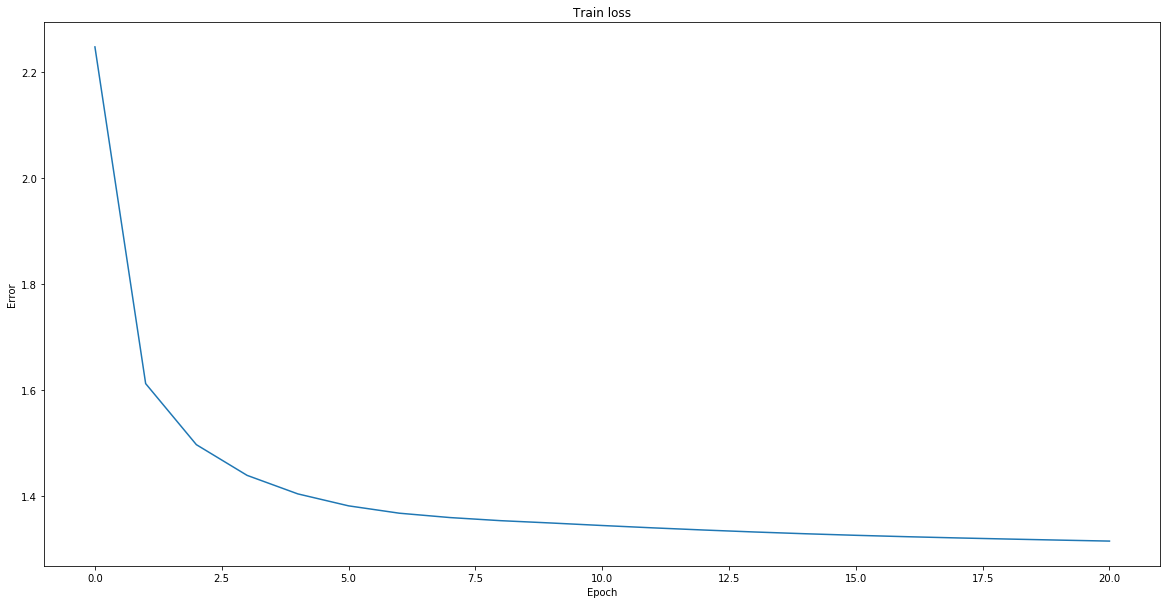

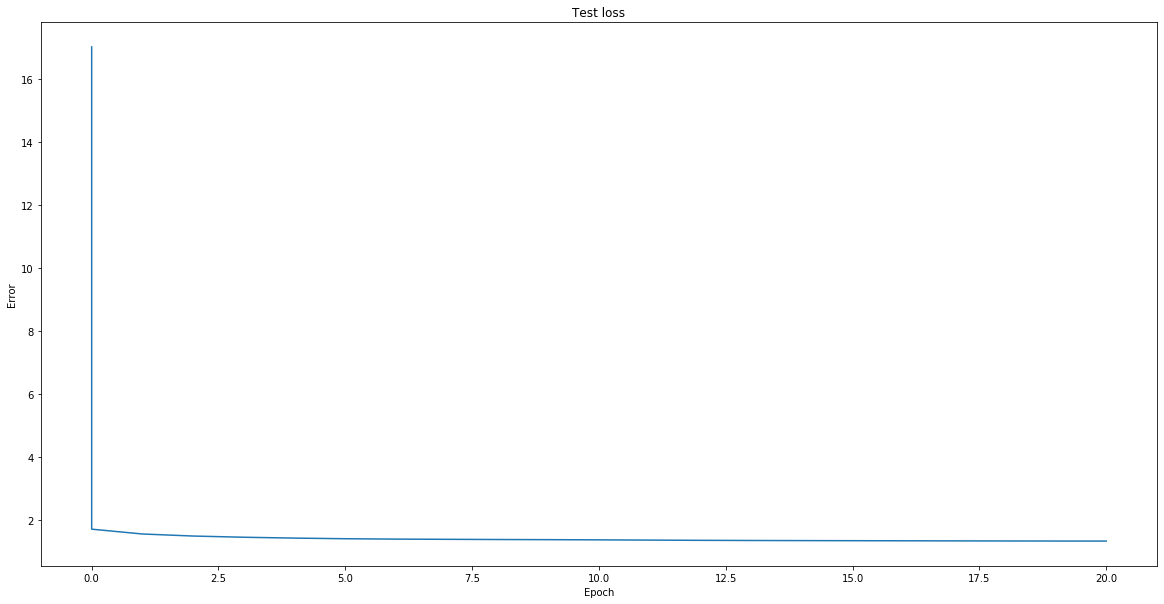

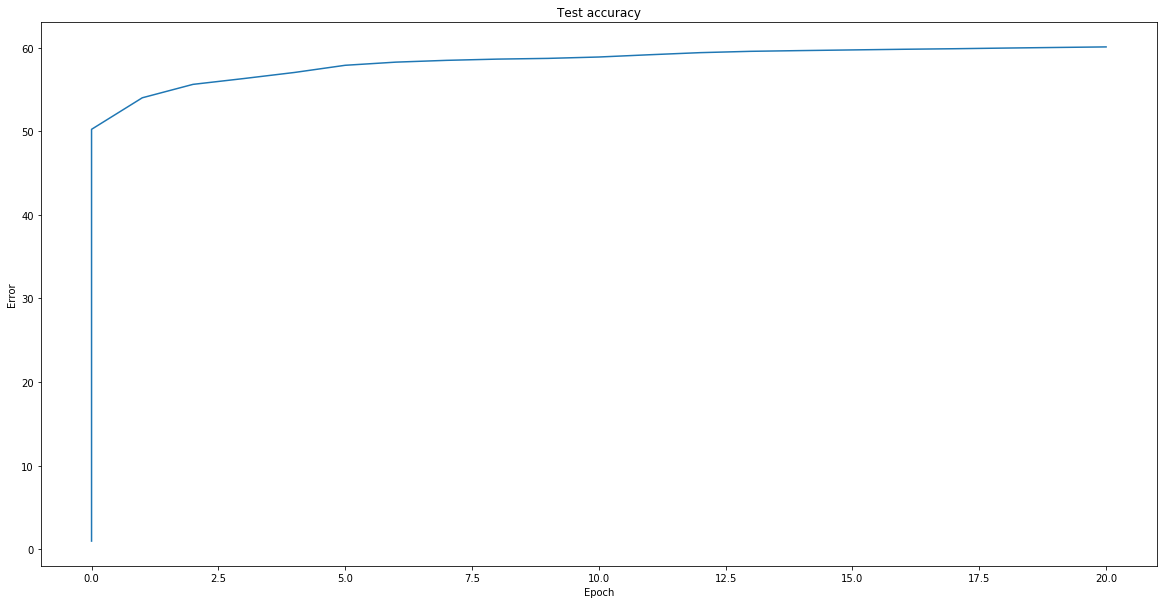

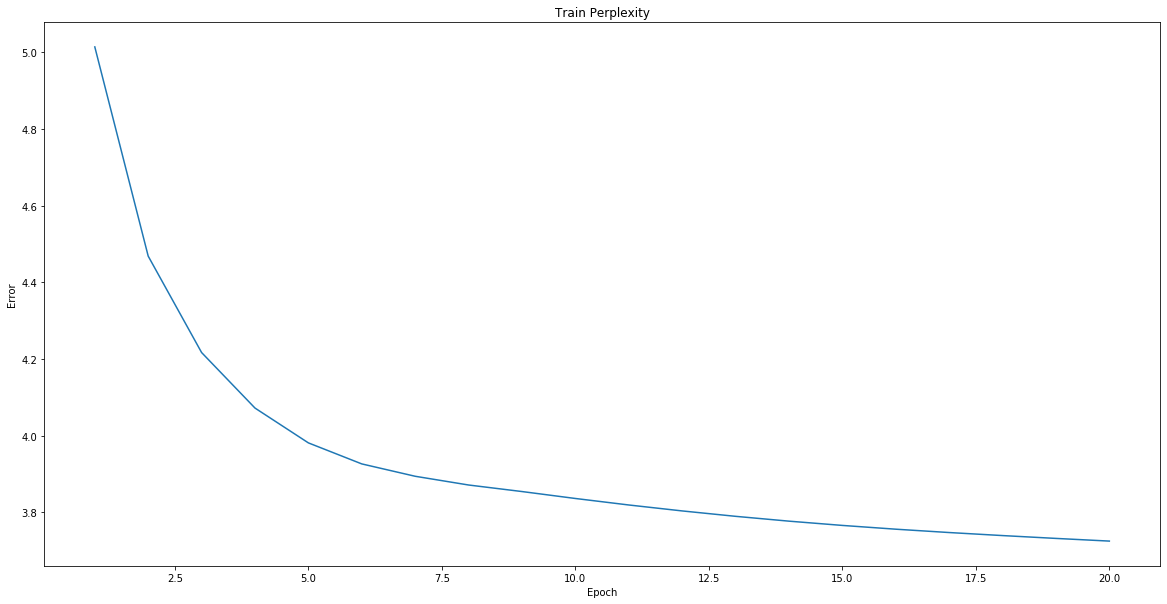

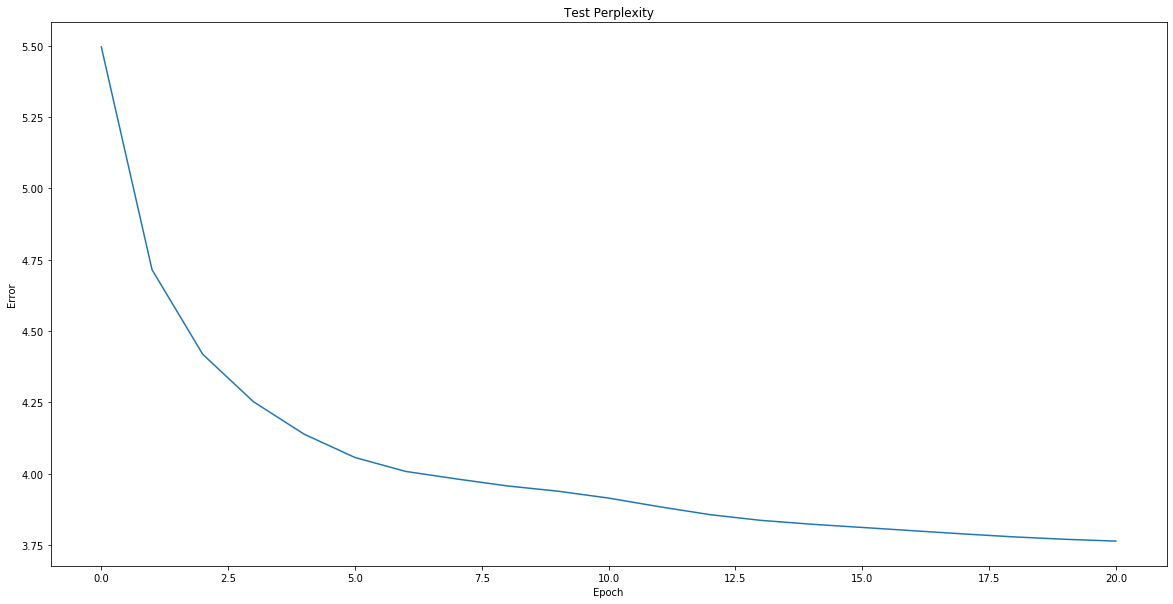

In [60]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 128
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 128
    EPOCHS = 20
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies, train_perplexities, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], [], []))
    test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))
    # train_perplexities.append((start_epoch, train_perplexity))
    test_perplexities.append((start_epoch, test_perplexity))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)
            train_perplexity = math.exp(train_loss)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            train_perplexities.append((epoch, train_perplexity))
            test_perplexities.append((epoch, test_perplexity))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, train_perplexities, test_perplexities))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            print("train perplexity =", train_perplexity)
            print("test perplexity =", test_perplexity)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        train_perplexities = train_perplexities[1:]
        test_perplexities = test_perplexities[1:]
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_perplexities)
        pt_util.plot(ep, val, 'Train Perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep, val, 'Test Perplexity', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

#Part 7: Experiments

In [56]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)
    
    print("FIN")

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and the stairs were still staring at the stairs and started at the stairs and started at the stairs and started at the stairs and started at the stairs and started at the stairs and started at the stairs and
generated with sample	 Harry Potter and the y would have seen to see the top of the way to Hagrid's one of the cried and pulled the students that the trunk rag and straightened the top of the crowd and shouldered round at him. "Well, they were 
generated with sample	 Harry Potter and the  point of the great barm and started back to something something in the rest of the first team. "I'm think it had been a ceiling way . . . . . There was not looking all the body of the stone castle an
generated with sample	 Harry Potter and thenir first prefects and then he had not made it. He was on the last cold lime a really for the back of the boy all the minute and helped the dark students so that he had started at the stairs and starte
generated with sample	 H

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



In [0]:
# 2. better architecture

class HarryPotterNet2(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True, num_layers=5, dropout=0.1)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.

        #@Helly: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
        output = self.encoder(x)
        output, hidden_state = self.gru(output, hidden_state)
        output = self.decoder(output)

        return output, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

SEQUENCE_LENGTH = 100
BATCH_SIZE = 128
FEATURE_SIZE = 256
TEST_BATCH_SIZE = 128
EPOCHS = 40
LEARNING_RATE = 0.00001
WEIGHT_DECAY = 0.00005

#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    